<a href="https://colab.research.google.com/github/covinolab/tomo_sbi/blob/main/Debug_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following commands install a virtual environment (cryoet_sbi) on Google drive

________________________________________________________________________________

In [ ]:
# pip install virtualenv

In [ ]:
# !virtualenv /content/drive/MyDrive/tomo_sbi/cryoet_sbi

In [ ]:
# !source /content/drive/MyDrive/tomo_sbi/cryoet_sbi/bin/activate; pip install lampe

In [ ]:
# !source /content/drive/MyDrive/tomo_sbi/cryoet_sbi/bin/activate; pip install mrcfile

In [ ]:
# !source /content/drive/MyDrive/tomo_sbi/cryoet_sbi/bin/activate; pip install mdanalysis

________________________________________________________________________________

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
# import MDAnalysis as mda


# import cryo_sbi.inference.train_npe_model as train_npe_model
# import cryo_sbi.utils.estimator_utils as est_utils
# import cryo_sbi.utils.image_utils as img_utils

import os
import sys

# Get the path to the directory containing the module you want to import
# module_dir = '../src/cryo_sbi/wpa_simulator/'
module_dir = '/content/drive/MyDrive/tomo_sbi/'
src_dir = '/content/drive/MyDrive/tomo_sbi/src/cryo_sbi/'
env_dir = '/content/drive/MyDrive/tomo_sbi/cryoet_sbi/lib/python3.10/site-packages/'


# Add this directory to the system path
sys.path.append(module_dir)
sys.path.append(src_dir)
sys.path.append(env_dir)

import mrcfile
# import umap

# from cryo_em_simulator import CryoEmSimulator
import train_npe_model_3d as train_npe_model
import utils_3d.estimator_utils_3d as est_utils_3d
from cryo_em_simulator_3d import CryoEmSimulator_3d


# # import utils.image_utils as img_utils
import utils_3d.generate_models_3d as generate_models



### Make the models

Here we are creating a simple molecular model.
In our model we will have two pseudo atoms with an unknown distance between them.
The goal is then to simulate cryo-EM images with these models and infer the distance between the two atoms from the images.

The first step is to create the model. We start by creating an array with the distances `distance_centers` between the atoms. We will use this array to create the models.
The models are then created by placing the atom centers along the y-axis at the given distances. The x and z coordinates are set to zero.

The models are saved into the file `models.pt`.



In [ ]:
## Define path string for colab notebook
tomosbi_path = '/content/drive/MyDrive/tomo_sbi/'
os.chdir(tomosbi_path)

In [ ]:
# Generate the pytorch tensor from PDB file
generate_models.pdb_parser("8A9B.pdb", 1, 'P116_8a9b.pt')

##### Visualize the models

### Run first simulation

We will now simulate the cryo-EM images with our generated models.
The simulation is done by the class `CryoEmSimulator`. And the simulation is run by the function `simulate` function.
The class `CryoEmSimulator` takes as input a config file with the simulation parameters. The config file used here is `simulation_parameters.json`.

The following parameters are used in the simulation:

```
simulation_parameters.json

{
    "N_PIXELS": 64,             --> size of the image
    "PIXEL_SIZE": 2.0,          --> pixel size in angstroms
    "SIGMA": [2.0, 2.0],        --> standard deviation of the gaussian
    "MODEL_FILE": "models.pt",  --> file which contains the models
    "SHIFT": 0.0,               --> shift of model center
    "DEFOCUS": [2.0, 2.0],      --> defocus range for the simulation
    "SNR": [0.01, 0.5],         --> signal to noise ratio  for the simulation
    "AMP": 0.1,                 --> amplitude for the ctf
    "B_FACTOR": [1.0, 1.0]      --> b factor for the ctf
}
```

## 3d

In [ ]:

# downsample the models (every 4 atoms)
hsp_90 = torch.load("hsp90_models.pt")[:,:,::4]
torch.save(hsp_90,"hsp90_models_3d.pt")

In [ ]:
simulator_3d = CryoEmSimulator_3d(
    "simulation_parameters_3d.json", device='cuda'
)  # creating simulator with simulation parameters

In [ ]:
volumes, parameters = simulator_3d.simulate(
    num_sim=10, return_parameters=True
)  # simulating images and save parameters

In [ ]:
dist = parameters[0]  # extracting distance from parameters
snr = parameters[-1]  # extracting snr from parameters

#### Visualize the simulated volumes

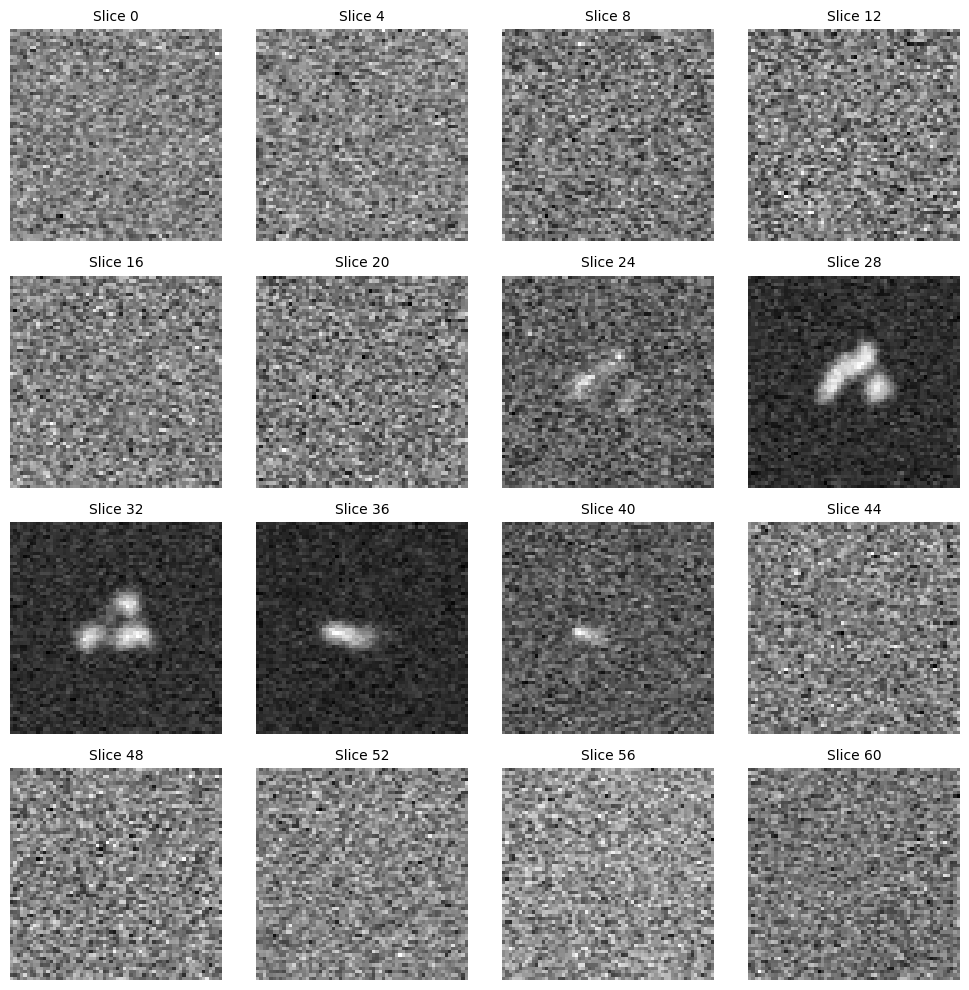

In [ ]:
single_volume = volumes[2]  # Shape: [depth, height, width]

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Choose slices to display - for example, evenly spaced through the volume
depth = single_volume.shape[2]
slice_indices = torch.linspace(0, depth, 64).long()  # 16 evenly spaced slices



for ax, idx in zip(axes.flatten(), slice_indices[::4]):
    slice_2d = single_volume[:, idx, :].float().numpy()  # Get a 2D slice of the volume

    # Plot the slice
    ax.imshow(slice_2d, cmap='gray',)# vmin=-0.00005, vmax=0.00005)
    ax.set_title(f'Slice {idx.item()}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

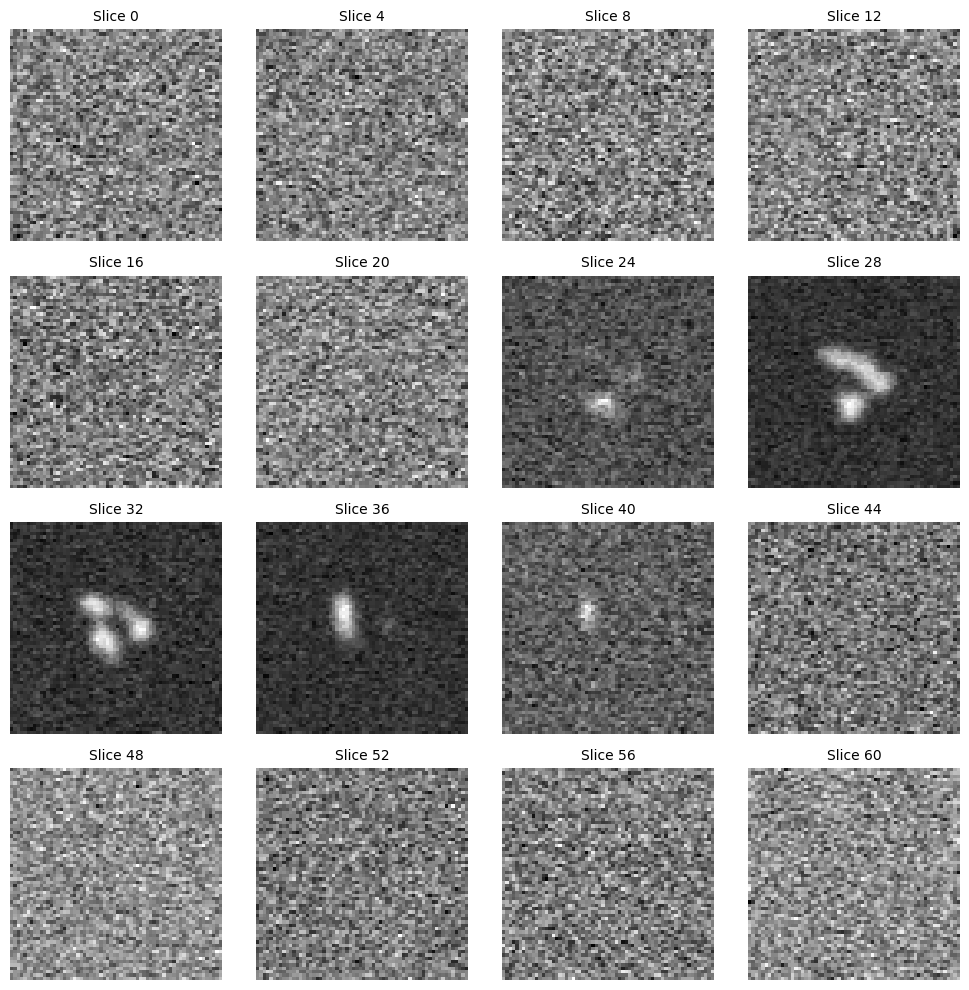

In [ ]:
single_volume = volumes[5]  # Shape: [depth, height, width]

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Choose slices to display - for example, evenly spaced through the volume
depth = single_volume.shape[2]
slice_indices = torch.linspace(0, depth, 64).long()  # 16 evenly spaced slices



for ax, idx in zip(axes.flatten(), slice_indices[::4]):
    slice_2d = single_volume[:, idx, :].float().numpy()  # Get a 2D slice of the volume

    # Plot the slice
    ax.imshow(slice_2d, cmap='gray',)# vmin=-0.00005, vmax=0.00005)
    ax.set_title(f'Slice {idx.item()}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# with mrcfile.new("test_volumes/missingwedge.mrc", overwrite=True) as mrc:
#     mrc.set_data(single_volume.numpy().astype(np.float32))

In [ ]:
# with mrcfile.new("test_volumes/single_volume_hsp90.mrc", overwrite=True) as mrc:
#     mrc.set_data(single_volume.numpy().astype(np.float32))


In [ ]:
# with mrcfile.open("test_volumes/single_volume.mrc", mode='r') as mrc:
#     print(mrc.data.shape)

### Train cryoSBI posterior

We will now train the cryoSBI posterior to infer the distance between the atoms from the simulated images.
The training is done with the function `npe_train_no_saving` which simulates images and simultaneously trains the posterior.
The function takes as input the config file `training_parameters.json` which contains the training and neural network parameters.
The function also takes as input the config file `simulation_parameters.json` which contains the simulation parameters used to simulate the images.


```
training_parameters.json
```

```
{
    "EMBEDDING": "ConvEncoder_Tutorial",    --> embedding network for the images
    "OUT_DIM": 128,                         --> dimension of the embedding
    "NUM_TRANSFORM": 5,                     --> number of transformations
    "NUM_HIDDEN_FLOW": 5,                   --> number of hidden layers in the flow
    "HIDDEN_DIM_FLOW": 128,                 --> dimension of the hidden layers in the flow
    "MODEL": "NSF",                         --> type of flow
    "LEARNING_RATE": 0.0003,                --> learning rate
    "CLIP_GRADIENT": 5.0,                   --> gradient clipping
    "THETA_SHIFT": 50,                      --> shift of the model center
    "THETA_SCALE": 50,                      --> scale of the model
    "BATCH_SIZE": 32                        --> batch size
}
```


In [ ]:
train_npe_model.npe_train_no_saving(
    "simulation_parameters_3d.json",
    "training_parameters.json",
    1000,
    "tutorial_estimator_carreira.pt",  # name of the estimator file
    "tutorial_carreira.loss",  # name of the loss file
    n_workers=4,  # number of workers for data loading
    device="cuda",  # device to use for training and simulation
    saving_frequency=5,  # frequency of saving the model
    simulation_batch_size=10,  # batch size for simulation
)

Training neural netowrk:



  0%|          | 0/1000 [00:00<?, ?epoch/s]

/home/arghittu/anaconda3/envs/cryoet_sbi/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608885084/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



  0%|          | 0/1000 [01:31<?, ?epoch/s, loss=-0.157]


  0%|          | 1/1000 [01:32<25:35:11, 92.20s/epoch, loss=-0.157]


  0%|          | 1/1000 [03:05<25:35:11, 92.20s/epoch, loss=-0.653]


  0%|          | 2/1000 [03:05<25:40:08, 92.59s/epoch, loss=-0.653]


  0%|          | 2/1000 [04:38<25:40:08, 92.59s/epoch, loss=-0.811]


  0%|          | 3/1000 [04:38<25:41:40, 92.78s/epoch, loss=-0.811]


  0%|          | 3/1000 [06:11<25:41:40, 92.78s/epoch, loss=-0.669]


  0%|          | 4/1000 [06:11<25:41:18, 92.85s/epoch, loss=-0.669]


  0%|          | 4/1000 [07:43<25:41:18, 92.85s/epoch, loss=-0.946]


  0%|          | 5/1000 [07:43<25:40:26, 92.89s/epoch, loss=-0.946]


  0%|          | 5/1000 [09:16<25:40:26, 92.89s/epoch, loss=-0.83] 


  1%|          | 6/1000 [09:17<25:40:42, 93.00s/epoch, loss=-0.83]


  1%|          | 6/1000 [10:50<25:40:42, 93.00s/epoch, loss=-0.807]


  1%|          | 7/1000 [10:50<25:38:11, 92.94s/epoch, loss=-0.807]


  1%|          | 7/1000 [12:23<25:38:11, 92.94s/epoch, loss=-0.778]


  1%|          | 8/1000 [12:23<25:36:56, 92.96s/epoch, loss=-0.778]


  1%|          | 8/1000 [13:55<25:36:56, 92.96s/epoch, loss=-0.984]


  1%|          | 9/1000 [13:55<25:35:09, 92.95s/epoch, loss=-0.984]


  1%|          | 9/1000 [15:28<25:35:09, 92.95s/epoch, loss=-0.966]


  1%|          | 10/1000 [15:28<25:33:25, 92.93s/epoch, loss=-0.966]


  1%|          | 10/1000 [17:01<25:33:25, 92.93s/epoch, loss=-0.948]


  1%|          | 11/1000 [17:02<25:33:21, 93.02s/epoch, loss=-0.948]


  1%|          | 11/1000 [18:35<25:33:21, 93.02s/epoch, loss=-0.968]


  1%|          | 12/1000 [18:35<25:31:30, 93.01s/epoch, loss=-0.968]


  1%|          | 12/1000 [20:08<25:31:30, 93.01s/epoch, loss=-1.06] 


  1%|▏         | 13/1000 [20:08<25:30:09, 93.02s/epoch, loss=-1.06]


  1%|▏         | 13/1000 [21:41<25:30:09, 93.02s/epoch, loss=-1.05]


  1%|▏         | 14/1000 [21:41<25:28:45, 93.03s/epoch, loss=-1.05]


  1%|▏         | 14/1000 [23:14<25:28:45, 93.03s/epoch, loss=-0.866]


  2%|▏         | 15/1000 [23:14<25:26:32, 92.99s/epoch, loss=-0.866]


  2%|▏         | 15/1000 [24:46<25:26:32, 92.99s/epoch, loss=-0.974]


  2%|▏         | 16/1000 [24:47<25:25:07, 92.99s/epoch, loss=-0.974]


  2%|▏         | 16/1000 [26:20<25:25:07, 92.99s/epoch, loss=-1.05] 


  2%|▏         | 17/1000 [26:20<25:23:24, 92.99s/epoch, loss=-1.05]


  2%|▏         | 17/1000 [27:52<25:23:24, 92.99s/epoch, loss=-1.15]


  2%|▏         | 18/1000 [27:52<25:21:51, 92.99s/epoch, loss=-1.15]


  2%|▏         | 18/1000 [29:25<25:21:51, 92.99s/epoch, loss=-1.08]


  2%|▏         | 19/1000 [29:25<25:20:12, 92.98s/epoch, loss=-1.08]


  2%|▏         | 19/1000 [30:58<25:20:12, 92.98s/epoch, loss=-1.04]


  2%|▏         | 20/1000 [30:58<25:17:59, 92.94s/epoch, loss=-1.04]


  2%|▏         | 20/1000 [32:31<25:17:59, 92.94s/epoch, loss=-1.03]


  2%|▏         | 21/1000 [32:32<25:18:30, 93.06s/epoch, loss=-1.03]


  2%|▏         | 21/1000 [34:05<25:18:30, 93.06s/epoch, loss=-1.09]


  2%|▏         | 22/1000 [34:05<25:16:26, 93.03s/epoch, loss=-1.09]


  2%|▏         | 22/1000 [35:38<25:16:26, 93.03s/epoch, loss=-1.26]


  2%|▏         | 23/1000 [35:38<25:15:03, 93.04s/epoch, loss=-1.26]


  2%|▏         | 23/1000 [37:10<25:15:03, 93.04s/epoch, loss=-1.1] 


  2%|▏         | 24/1000 [37:10<25:12:13, 92.96s/epoch, loss=-1.1]


  2%|▏         | 24/1000 [38:43<25:12:13, 92.96s/epoch, loss=-1.19]


  2%|▎         | 25/1000 [38:43<25:10:38, 92.96s/epoch, loss=-1.19]


  2%|▎         | 25/1000 [40:16<25:10:38, 92.96s/epoch, loss=-1.24]


  3%|▎         | 26/1000 [40:17<25:10:55, 93.08s/epoch, loss=-1.24]


  3%|▎         | 26/1000 [41:50<25:10:55, 93.08s/epoch, loss=-1.23]


  3%|▎         | 27/1000 [41:50<25:08:22, 93.01s/epoch, loss=-1.23]


  3%|▎         | 27/1000 [43:23<25:08:22, 93.01s/epoch, loss=-1.23]


  3%|▎         | 28/1000 [43:23<25:07:02, 93.03s/epoch, loss=-1.23]


  3%|▎         | 28/1000 [44:56<25:07:02, 93.03s/epoch, loss=-1.27]


  3%|▎         | 29/1000 [44:56<25:04:30, 92.97s/epoch, loss=-1.27]


  3%|▎         | 29/1000 [46:28<25:04:30, 92.97s/epoch, loss=-1.44]


  3%|▎         | 30/1000 [46:28<25:02:22, 92.93s/epoch, loss=-1.44]


  3%|▎         | 30/1000 [48:01<25:02:22, 92.93s/epoch, loss=-1.38]


  3%|▎         | 31/1000 [48:01<25:01:46, 92.99s/epoch, loss=-1.38]


  3%|▎         | 31/1000 [49:34<25:01:46, 92.99s/epoch, loss=-1.29]


  3%|▎         | 32/1000 [49:34<24:59:13, 92.93s/epoch, loss=-1.29]


  3%|▎         | 32/1000 [51:07<24:59:13, 92.93s/epoch, loss=-1.39]


  3%|▎         | 33/1000 [51:07<24:57:13, 92.90s/epoch, loss=-1.39]


  3%|▎         | 33/1000 [52:40<24:57:13, 92.90s/epoch, loss=-1.33]


  3%|▎         | 34/1000 [52:40<24:55:32, 92.89s/epoch, loss=-1.33]


  3%|▎         | 34/1000 [54:13<24:55:32, 92.89s/epoch, loss=-1.45]


  4%|▎         | 35/1000 [54:13<24:54:47, 92.94s/epoch, loss=-1.45]


  4%|▎         | 35/1000 [55:46<24:54:47, 92.94s/epoch, loss=-1.36]


  4%|▎         | 36/1000 [55:46<24:53:48, 92.98s/epoch, loss=-1.36]


  4%|▎         | 36/1000 [57:19<24:53:48, 92.98s/epoch, loss=-1.37]


  4%|▎         | 37/1000 [57:19<24:51:52, 92.95s/epoch, loss=-1.37]


  4%|▎         | 37/1000 [58:52<24:51:52, 92.95s/epoch, loss=-1.51]


  4%|▍         | 38/1000 [58:52<24:49:48, 92.92s/epoch, loss=-1.51]


  4%|▍         | 38/1000 [1:00:25<24:49:48, 92.92s/epoch, loss=-1.54]


  4%|▍         | 39/1000 [1:00:25<24:47:12, 92.85s/epoch, loss=-1.54]


  4%|▍         | 39/1000 [1:01:57<24:47:12, 92.85s/epoch, loss=-1.4] 


  4%|▍         | 40/1000 [1:01:57<24:45:48, 92.86s/epoch, loss=-1.4]


  4%|▍         | 40/1000 [1:03:30<24:45:48, 92.86s/epoch, loss=-1.35]


  4%|▍         | 41/1000 [1:03:31<24:46:12, 92.98s/epoch, loss=-1.35]


  4%|▍         | 41/1000 [1:05:03<24:46:12, 92.98s/epoch, loss=-1.38]


  4%|▍         | 42/1000 [1:05:03<24:42:59, 92.88s/epoch, loss=-1.38]


  4%|▍         | 42/1000 [1:06:36<24:42:59, 92.88s/epoch, loss=-1.42]


  4%|▍         | 43/1000 [1:06:36<24:41:01, 92.85s/epoch, loss=-1.42]


  4%|▍         | 43/1000 [1:08:09<24:41:01, 92.85s/epoch, loss=-1.46]


  4%|▍         | 44/1000 [1:08:09<24:39:10, 92.84s/epoch, loss=-1.46]


  4%|▍         | 44/1000 [1:09:42<24:39:10, 92.84s/epoch, loss=-1.4] 


  4%|▍         | 45/1000 [1:09:42<24:37:27, 92.82s/epoch, loss=-1.4]


  4%|▍         | 45/1000 [1:11:14<24:37:27, 92.82s/epoch, loss=-1.46]


  5%|▍         | 46/1000 [1:11:15<24:36:54, 92.89s/epoch, loss=-1.46]


  5%|▍         | 46/1000 [1:12:48<24:36:54, 92.89s/epoch, loss=-1.62]


  5%|▍         | 47/1000 [1:12:48<24:35:15, 92.88s/epoch, loss=-1.62]


  5%|▍         | 47/1000 [1:14:21<24:35:15, 92.88s/epoch, loss=-1.42]


  5%|▍         | 48/1000 [1:14:21<24:33:47, 92.89s/epoch, loss=-1.42]


  5%|▍         | 48/1000 [1:15:53<24:33:47, 92.89s/epoch, loss=-1.51]


  5%|▍         | 49/1000 [1:15:53<24:31:43, 92.85s/epoch, loss=-1.51]


  5%|▍         | 49/1000 [1:17:26<24:31:43, 92.85s/epoch, loss=-1.62]


  5%|▌         | 50/1000 [1:17:26<24:29:32, 92.81s/epoch, loss=-1.62]


  5%|▌         | 50/1000 [1:18:59<24:29:32, 92.81s/epoch, loss=-1.44]


  5%|▌         | 51/1000 [1:18:59<24:29:20, 92.90s/epoch, loss=-1.44]


  5%|▌         | 51/1000 [1:20:32<24:29:20, 92.90s/epoch, loss=-1.51]


  5%|▌         | 52/1000 [1:20:32<24:26:56, 92.84s/epoch, loss=-1.51]


  5%|▌         | 52/1000 [1:22:05<24:26:56, 92.84s/epoch, loss=-1.57]


  5%|▌         | 53/1000 [1:22:05<24:25:25, 92.85s/epoch, loss=-1.57]


  5%|▌         | 53/1000 [1:23:37<24:25:25, 92.85s/epoch, loss=-1.55]


  5%|▌         | 54/1000 [1:23:37<24:23:44, 92.84s/epoch, loss=-1.55]


  5%|▌         | 54/1000 [1:25:10<24:23:44, 92.84s/epoch, loss=-1.46]


  6%|▌         | 55/1000 [1:25:10<24:21:51, 92.82s/epoch, loss=-1.46]


  6%|▌         | 55/1000 [1:26:43<24:21:51, 92.82s/epoch, loss=-1.62]


  6%|▌         | 56/1000 [1:26:43<24:21:25, 92.89s/epoch, loss=-1.62]


  6%|▌         | 56/1000 [1:28:16<24:21:25, 92.89s/epoch, loss=-1.52]


  6%|▌         | 57/1000 [1:28:16<24:19:28, 92.86s/epoch, loss=-1.52]


  6%|▌         | 57/1000 [1:29:49<24:19:28, 92.86s/epoch, loss=-1.63]


  6%|▌         | 58/1000 [1:29:49<24:17:24, 92.83s/epoch, loss=-1.63]


  6%|▌         | 58/1000 [1:31:22<24:17:24, 92.83s/epoch, loss=-1.72]


  6%|▌         | 59/1000 [1:31:22<24:15:19, 92.79s/epoch, loss=-1.72]


  6%|▌         | 59/1000 [1:32:54<24:15:19, 92.79s/epoch, loss=-1.59]


  6%|▌         | 60/1000 [1:32:54<24:13:43, 92.79s/epoch, loss=-1.59]


  6%|▌         | 60/1000 [1:34:27<24:13:43, 92.79s/epoch, loss=-1.33]


  6%|▌         | 61/1000 [1:34:27<24:13:07, 92.85s/epoch, loss=-1.33]


  6%|▌         | 61/1000 [1:36:00<24:13:07, 92.85s/epoch, loss=-1.6] 


  6%|▌         | 62/1000 [1:36:00<24:11:21, 92.84s/epoch, loss=-1.6]


  6%|▌         | 62/1000 [1:37:33<24:11:21, 92.84s/epoch, loss=-1.44]


  6%|▋         | 63/1000 [1:37:33<24:09:19, 92.81s/epoch, loss=-1.44]


  6%|▋         | 63/1000 [1:39:06<24:09:19, 92.81s/epoch, loss=-1.34]


  6%|▋         | 64/1000 [1:39:06<24:06:57, 92.75s/epoch, loss=-1.34]


  6%|▋         | 64/1000 [1:40:38<24:06:57, 92.75s/epoch, loss=-1.55]


  6%|▋         | 65/1000 [1:40:38<24:05:49, 92.78s/epoch, loss=-1.55]


  6%|▋         | 65/1000 [1:42:11<24:05:49, 92.78s/epoch, loss=-1.65]


  7%|▋         | 66/1000 [1:42:11<24:05:13, 92.84s/epoch, loss=-1.65]


  7%|▋         | 66/1000 [1:43:44<24:05:13, 92.84s/epoch, loss=-1.64]


  7%|▋         | 67/1000 [1:43:44<24:03:45, 92.85s/epoch, loss=-1.64]


  7%|▋         | 67/1000 [1:45:17<24:03:45, 92.85s/epoch, loss=-1.63]


  7%|▋         | 68/1000 [1:45:17<24:01:51, 92.82s/epoch, loss=-1.63]


  7%|▋         | 68/1000 [1:46:50<24:01:51, 92.82s/epoch, loss=-1.57]


  7%|▋         | 69/1000 [1:46:50<24:00:01, 92.81s/epoch, loss=-1.57]


  7%|▋         | 69/1000 [1:48:23<24:00:01, 92.81s/epoch, loss=-1.63]


  7%|▋         | 70/1000 [1:48:23<23:59:02, 92.84s/epoch, loss=-1.63]


  7%|▋         | 70/1000 [1:49:55<23:59:02, 92.84s/epoch, loss=-1.62]


  7%|▋         | 71/1000 [1:49:56<23:57:38, 92.85s/epoch, loss=-1.62]


  7%|▋         | 71/1000 [1:51:28<23:57:38, 92.85s/epoch, loss=-1.61]


  7%|▋         | 72/1000 [1:51:28<23:56:11, 92.86s/epoch, loss=-1.61]


  7%|▋         | 72/1000 [1:53:01<23:56:11, 92.86s/epoch, loss=-1.6] 


  7%|▋         | 73/1000 [1:53:01<23:54:38, 92.86s/epoch, loss=-1.6]


  7%|▋         | 73/1000 [1:54:34<23:54:38, 92.86s/epoch, loss=-1.68]


  7%|▋         | 74/1000 [1:54:34<23:52:52, 92.84s/epoch, loss=-1.68]


  7%|▋         | 74/1000 [1:56:07<23:52:52, 92.84s/epoch, loss=-1.64]


  8%|▊         | 75/1000 [1:56:07<23:50:53, 92.81s/epoch, loss=-1.64]


  8%|▊         | 75/1000 [1:57:40<23:50:53, 92.81s/epoch, loss=-1.66]


  8%|▊         | 76/1000 [1:57:40<23:52:02, 92.99s/epoch, loss=-1.66]


  8%|▊         | 76/1000 [1:59:13<23:52:02, 92.99s/epoch, loss=-1.57]


  8%|▊         | 77/1000 [1:59:13<23:49:07, 92.90s/epoch, loss=-1.57]


  8%|▊         | 77/1000 [2:00:46<23:49:07, 92.90s/epoch, loss=-1.65]


  8%|▊         | 78/1000 [2:00:46<23:48:01, 92.93s/epoch, loss=-1.65]


  8%|▊         | 78/1000 [2:02:19<23:48:01, 92.93s/epoch, loss=-1.73]


  8%|▊         | 79/1000 [2:02:19<23:46:00, 92.90s/epoch, loss=-1.73]


  8%|▊         | 79/1000 [2:03:52<23:46:00, 92.90s/epoch, loss=-1.7] 


  8%|▊         | 80/1000 [2:03:52<23:44:21, 92.89s/epoch, loss=-1.7]


  8%|▊         | 80/1000 [2:05:24<23:44:21, 92.89s/epoch, loss=-1.73]


  8%|▊         | 81/1000 [2:05:25<23:43:52, 92.96s/epoch, loss=-1.73]


  8%|▊         | 81/1000 [2:06:58<23:43:52, 92.96s/epoch, loss=-1.57]


  8%|▊         | 82/1000 [2:06:58<23:41:50, 92.93s/epoch, loss=-1.57]


  8%|▊         | 82/1000 [2:08:30<23:41:50, 92.93s/epoch, loss=-1.48]


  8%|▊         | 83/1000 [2:08:30<23:39:54, 92.91s/epoch, loss=-1.48]


  8%|▊         | 83/1000 [2:10:03<23:39:54, 92.91s/epoch, loss=-1.59]


  8%|▊         | 84/1000 [2:10:03<23:38:01, 92.88s/epoch, loss=-1.59]


  8%|▊         | 84/1000 [2:11:36<23:38:01, 92.88s/epoch, loss=-1.77]


  8%|▊         | 85/1000 [2:11:36<23:36:26, 92.88s/epoch, loss=-1.77]


  8%|▊         | 85/1000 [2:13:09<23:36:26, 92.88s/epoch, loss=-1.77]


  9%|▊         | 86/1000 [2:13:09<23:36:09, 92.96s/epoch, loss=-1.77]


  9%|▊         | 86/1000 [2:14:42<23:36:09, 92.96s/epoch, loss=-1.75]


  9%|▊         | 87/1000 [2:14:42<23:34:27, 92.95s/epoch, loss=-1.75]


  9%|▊         | 87/1000 [2:16:15<23:34:27, 92.95s/epoch, loss=-1.73]


  9%|▉         | 88/1000 [2:16:15<23:32:41, 92.94s/epoch, loss=-1.73]


  9%|▉         | 88/1000 [2:17:48<23:32:41, 92.94s/epoch, loss=-1.55]


  9%|▉         | 89/1000 [2:17:48<23:30:29, 92.90s/epoch, loss=-1.55]


  9%|▉         | 89/1000 [2:19:21<23:30:29, 92.90s/epoch, loss=-1.72]


  9%|▉         | 90/1000 [2:19:21<23:28:48, 92.89s/epoch, loss=-1.72]


  9%|▉         | 90/1000 [2:20:53<23:28:48, 92.89s/epoch, loss=-1.67]


  9%|▉         | 91/1000 [2:20:54<23:27:31, 92.91s/epoch, loss=-1.67]


  9%|▉         | 91/1000 [2:22:26<23:27:31, 92.91s/epoch, loss=-1.7] 


  9%|▉         | 92/1000 [2:22:26<23:24:47, 92.83s/epoch, loss=-1.7]


  9%|▉         | 92/1000 [2:23:59<23:24:47, 92.83s/epoch, loss=-1.82]


  9%|▉         | 93/1000 [2:23:59<23:23:18, 92.83s/epoch, loss=-1.82]


  9%|▉         | 93/1000 [2:25:32<23:23:18, 92.83s/epoch, loss=-1.43]


  9%|▉         | 94/1000 [2:25:32<23:20:38, 92.76s/epoch, loss=-1.43]


  9%|▉         | 94/1000 [2:27:05<23:20:38, 92.76s/epoch, loss=-1.61]


 10%|▉         | 95/1000 [2:27:05<23:19:32, 92.79s/epoch, loss=-1.61]


 10%|▉         | 95/1000 [2:28:37<23:19:32, 92.79s/epoch, loss=-1.73]


 10%|▉         | 96/1000 [2:28:38<23:18:30, 92.82s/epoch, loss=-1.73]


 10%|▉         | 96/1000 [2:30:10<23:18:30, 92.82s/epoch, loss=-1.72]


 10%|▉         | 97/1000 [2:30:10<23:16:55, 92.82s/epoch, loss=-1.72]


 10%|▉         | 97/1000 [2:31:43<23:16:55, 92.82s/epoch, loss=-1.72]


 10%|▉         | 98/1000 [2:31:43<23:15:09, 92.80s/epoch, loss=-1.72]


 10%|▉         | 98/1000 [2:33:16<23:15:09, 92.80s/epoch, loss=-1.78]


 10%|▉         | 99/1000 [2:33:16<23:13:36, 92.80s/epoch, loss=-1.78]


 10%|▉         | 99/1000 [2:34:49<23:13:36, 92.80s/epoch, loss=-1.79]


 10%|█         | 100/1000 [2:34:49<23:12:05, 92.81s/epoch, loss=-1.79]


 10%|█         | 100/1000 [2:36:22<23:12:05, 92.81s/epoch, loss=-1.8] 


 10%|█         | 101/1000 [2:36:22<23:12:02, 92.91s/epoch, loss=-1.8]


 10%|█         | 101/1000 [2:37:55<23:12:02, 92.91s/epoch, loss=-1.76]


 10%|█         | 102/1000 [2:37:55<23:09:48, 92.86s/epoch, loss=-1.76]


 10%|█         | 102/1000 [2:39:27<23:09:48, 92.86s/epoch, loss=-1.77]


 10%|█         | 103/1000 [2:39:27<23:07:51, 92.83s/epoch, loss=-1.77]


 10%|█         | 103/1000 [2:41:00<23:07:51, 92.83s/epoch, loss=-1.64]


 10%|█         | 104/1000 [2:41:00<23:06:16, 92.83s/epoch, loss=-1.64]


 10%|█         | 104/1000 [2:42:33<23:06:16, 92.83s/epoch, loss=-1.8] 


 10%|█         | 105/1000 [2:42:33<23:04:17, 92.80s/epoch, loss=-1.8]


 10%|█         | 105/1000 [2:44:06<23:04:17, 92.80s/epoch, loss=-1.92]


 11%|█         | 106/1000 [2:44:06<23:03:22, 92.84s/epoch, loss=-1.92]


 11%|█         | 106/1000 [2:45:39<23:03:22, 92.84s/epoch, loss=-1.73]


 11%|█         | 107/1000 [2:45:39<23:01:26, 92.82s/epoch, loss=-1.73]


 11%|█         | 107/1000 [2:47:12<23:01:26, 92.82s/epoch, loss=-1.74]


 11%|█         | 108/1000 [2:47:12<23:00:05, 92.83s/epoch, loss=-1.74]


 11%|█         | 108/1000 [2:48:44<23:00:05, 92.83s/epoch, loss=-1.82]


 11%|█         | 109/1000 [2:48:44<22:57:59, 92.79s/epoch, loss=-1.82]


 11%|█         | 109/1000 [2:50:17<22:57:59, 92.79s/epoch, loss=-1.79]


 11%|█         | 110/1000 [2:50:17<22:56:21, 92.79s/epoch, loss=-1.79]


 11%|█         | 110/1000 [2:51:50<22:56:21, 92.79s/epoch, loss=-1.75]


 11%|█         | 111/1000 [2:51:50<22:55:26, 92.83s/epoch, loss=-1.75]


 11%|█         | 111/1000 [2:53:23<22:55:26, 92.83s/epoch, loss=-1.79]


 11%|█         | 112/1000 [2:53:23<22:53:03, 92.77s/epoch, loss=-1.79]


 11%|█         | 112/1000 [2:54:55<22:53:03, 92.77s/epoch, loss=-1.84]


 11%|█▏        | 113/1000 [2:54:55<22:51:43, 92.79s/epoch, loss=-1.84]


 11%|█▏        | 113/1000 [2:56:28<22:51:43, 92.79s/epoch, loss=-1.77]


 11%|█▏        | 114/1000 [2:56:28<22:50:12, 92.79s/epoch, loss=-1.77]


 11%|█▏        | 114/1000 [2:58:01<22:50:12, 92.79s/epoch, loss=-1.67]


 12%|█▏        | 115/1000 [2:58:01<22:48:26, 92.78s/epoch, loss=-1.67]


 12%|█▏        | 115/1000 [2:59:34<22:48:26, 92.78s/epoch, loss=-1.88]


 12%|█▏        | 116/1000 [2:59:34<22:48:53, 92.91s/epoch, loss=-1.88]


 12%|█▏        | 116/1000 [3:01:07<22:48:53, 92.91s/epoch, loss=-1.94]


 12%|█▏        | 117/1000 [3:01:07<22:47:13, 92.90s/epoch, loss=-1.94]


 12%|█▏        | 117/1000 [3:02:40<22:47:13, 92.90s/epoch, loss=-1.76]


 12%|█▏        | 118/1000 [3:02:40<22:46:00, 92.93s/epoch, loss=-1.76]


 12%|█▏        | 118/1000 [3:04:13<22:46:00, 92.93s/epoch, loss=-2.02]


 12%|█▏        | 119/1000 [3:04:13<22:43:05, 92.83s/epoch, loss=-2.02]


 12%|█▏        | 119/1000 [3:05:45<22:43:05, 92.83s/epoch, loss=-1.83]


 12%|█▏        | 120/1000 [3:05:45<22:40:53, 92.79s/epoch, loss=-1.83]


 12%|█▏        | 120/1000 [3:07:18<22:40:53, 92.79s/epoch, loss=-2]   


 12%|█▏        | 121/1000 [3:07:18<22:39:55, 92.83s/epoch, loss=-2]


 12%|█▏        | 121/1000 [3:08:51<22:39:55, 92.83s/epoch, loss=-1.79]


 12%|█▏        | 122/1000 [3:08:51<22:37:11, 92.75s/epoch, loss=-1.79]


 12%|█▏        | 122/1000 [3:10:24<22:37:11, 92.75s/epoch, loss=-1.8] 


 12%|█▏        | 123/1000 [3:10:24<22:36:07, 92.78s/epoch, loss=-1.8]


 12%|█▏        | 123/1000 [3:11:56<22:36:07, 92.78s/epoch, loss=-1.83]


 12%|█▏        | 124/1000 [3:11:56<22:33:50, 92.73s/epoch, loss=-1.83]


 12%|█▏        | 124/1000 [3:13:29<22:33:50, 92.73s/epoch, loss=-1.71]


 12%|█▎        | 125/1000 [3:13:29<22:32:23, 92.74s/epoch, loss=-1.71]


 12%|█▎        | 125/1000 [3:15:02<22:32:23, 92.74s/epoch, loss=-1.76]


 13%|█▎        | 126/1000 [3:15:02<22:32:02, 92.82s/epoch, loss=-1.76]


 13%|█▎        | 126/1000 [3:16:35<22:32:02, 92.82s/epoch, loss=-1.96]


 13%|█▎        | 127/1000 [3:16:35<22:29:52, 92.77s/epoch, loss=-1.96]


 13%|█▎        | 127/1000 [3:18:08<22:29:52, 92.77s/epoch, loss=-1.95]


 13%|█▎        | 128/1000 [3:18:08<22:28:23, 92.78s/epoch, loss=-1.95]


 13%|█▎        | 128/1000 [3:19:40<22:28:23, 92.78s/epoch, loss=-1.63]


 13%|█▎        | 129/1000 [3:19:40<22:26:29, 92.75s/epoch, loss=-1.63]


 13%|█▎        | 129/1000 [3:21:13<22:26:29, 92.75s/epoch, loss=-1.76]


 13%|█▎        | 130/1000 [3:21:13<22:24:58, 92.76s/epoch, loss=-1.76]


 13%|█▎        | 130/1000 [3:22:46<22:24:58, 92.76s/epoch, loss=-1.95]


 13%|█▎        | 131/1000 [3:22:46<22:23:57, 92.79s/epoch, loss=-1.95]


 13%|█▎        | 131/1000 [3:24:19<22:23:57, 92.79s/epoch, loss=-1.8] 


 13%|█▎        | 132/1000 [3:24:19<22:22:09, 92.78s/epoch, loss=-1.8]


 13%|█▎        | 132/1000 [3:25:51<22:22:09, 92.78s/epoch, loss=-1.81]


 13%|█▎        | 133/1000 [3:25:51<22:20:36, 92.78s/epoch, loss=-1.81]


 13%|█▎        | 133/1000 [3:27:24<22:20:36, 92.78s/epoch, loss=-1.79]


 13%|█▎        | 134/1000 [3:27:24<22:19:21, 92.80s/epoch, loss=-1.79]


 13%|█▎        | 134/1000 [3:28:57<22:19:21, 92.80s/epoch, loss=-1.63]


 14%|█▎        | 135/1000 [3:28:57<22:17:18, 92.76s/epoch, loss=-1.63]


 14%|█▎        | 135/1000 [3:30:30<22:17:18, 92.76s/epoch, loss=-1.96]


 14%|█▎        | 136/1000 [3:30:30<22:16:50, 92.84s/epoch, loss=-1.96]


 14%|█▎        | 136/1000 [3:32:03<22:16:50, 92.84s/epoch, loss=-1.95]


 14%|█▎        | 137/1000 [3:32:03<22:14:39, 92.79s/epoch, loss=-1.95]


 14%|█▎        | 137/1000 [3:33:35<22:14:39, 92.79s/epoch, loss=-1.64]


 14%|█▍        | 138/1000 [3:33:35<22:13:12, 92.80s/epoch, loss=-1.64]


 14%|█▍        | 138/1000 [3:35:08<22:13:12, 92.80s/epoch, loss=-1.99]


 14%|█▍        | 139/1000 [3:35:08<22:11:43, 92.80s/epoch, loss=-1.99]


 14%|█▍        | 139/1000 [3:36:41<22:11:43, 92.80s/epoch, loss=-2.09]


 14%|█▍        | 140/1000 [3:36:41<22:10:11, 92.80s/epoch, loss=-2.09]


 14%|█▍        | 140/1000 [3:38:14<22:10:11, 92.80s/epoch, loss=-1.56]


 14%|█▍        | 141/1000 [3:38:14<22:09:24, 92.86s/epoch, loss=-1.56]


 14%|█▍        | 141/1000 [3:39:47<22:09:24, 92.86s/epoch, loss=-2.06]


 14%|█▍        | 142/1000 [3:39:47<22:07:05, 92.80s/epoch, loss=-2.06]


 14%|█▍        | 142/1000 [3:41:20<22:07:05, 92.80s/epoch, loss=-1.99]


 14%|█▍        | 143/1000 [3:41:20<22:05:43, 92.82s/epoch, loss=-1.99]


 14%|█▍        | 143/1000 [3:42:52<22:05:43, 92.82s/epoch, loss=-1.88]


 14%|█▍        | 144/1000 [3:42:52<22:03:27, 92.77s/epoch, loss=-1.88]


 14%|█▍        | 144/1000 [3:44:25<22:03:27, 92.77s/epoch, loss=-1.83]


 14%|█▍        | 145/1000 [3:44:25<22:01:40, 92.75s/epoch, loss=-1.83]


 14%|█▍        | 145/1000 [3:45:58<22:01:40, 92.75s/epoch, loss=-1.91]


 15%|█▍        | 146/1000 [3:45:58<22:01:11, 92.82s/epoch, loss=-1.91]


 15%|█▍        | 146/1000 [3:47:31<22:01:11, 92.82s/epoch, loss=-1.75]


 15%|█▍        | 147/1000 [3:47:31<21:59:32, 92.82s/epoch, loss=-1.75]


 15%|█▍        | 147/1000 [3:49:03<21:59:32, 92.82s/epoch, loss=-1.93]


 15%|█▍        | 148/1000 [3:49:03<21:57:17, 92.77s/epoch, loss=-1.93]


 15%|█▍        | 148/1000 [3:50:36<21:57:17, 92.77s/epoch, loss=-1.82]


 15%|█▍        | 149/1000 [3:50:36<21:55:14, 92.73s/epoch, loss=-1.82]


 15%|█▍        | 149/1000 [3:52:09<21:55:14, 92.73s/epoch, loss=-1.84]


 15%|█▌        | 150/1000 [3:52:09<21:53:47, 92.74s/epoch, loss=-1.84]


 15%|█▌        | 150/1000 [3:53:41<21:53:47, 92.74s/epoch, loss=-1.98]


 15%|█▌        | 151/1000 [3:53:42<21:52:20, 92.74s/epoch, loss=-1.98]


 15%|█▌        | 151/1000 [3:55:14<21:52:20, 92.74s/epoch, loss=-1.95]


 15%|█▌        | 152/1000 [3:55:14<21:51:04, 92.76s/epoch, loss=-1.95]


 15%|█▌        | 152/1000 [3:56:47<21:51:04, 92.76s/epoch, loss=-1.93]


 15%|█▌        | 153/1000 [3:56:47<21:49:13, 92.74s/epoch, loss=-1.93]


 15%|█▌        | 153/1000 [3:58:20<21:49:13, 92.74s/epoch, loss=-2.04]


 15%|█▌        | 154/1000 [3:58:20<21:47:53, 92.76s/epoch, loss=-2.04]


 15%|█▌        | 154/1000 [3:59:53<21:47:53, 92.76s/epoch, loss=-1.85]


 16%|█▌        | 155/1000 [3:59:53<21:46:06, 92.74s/epoch, loss=-1.85]


 16%|█▌        | 155/1000 [4:01:25<21:46:06, 92.74s/epoch, loss=-2]   


 16%|█▌        | 156/1000 [4:01:26<21:45:49, 92.83s/epoch, loss=-2]


 16%|█▌        | 156/1000 [4:02:58<21:45:49, 92.83s/epoch, loss=-1.99]


 16%|█▌        | 157/1000 [4:02:58<21:43:57, 92.81s/epoch, loss=-1.99]


 16%|█▌        | 157/1000 [4:04:31<21:43:57, 92.81s/epoch, loss=-1.9] 


 16%|█▌        | 158/1000 [4:04:31<21:41:53, 92.77s/epoch, loss=-1.9]


 16%|█▌        | 158/1000 [4:06:04<21:41:53, 92.77s/epoch, loss=-2.01]


 16%|█▌        | 159/1000 [4:06:04<21:40:40, 92.80s/epoch, loss=-2.01]


 16%|█▌        | 159/1000 [4:07:36<21:40:40, 92.80s/epoch, loss=-2.08]


 16%|█▌        | 160/1000 [4:07:36<21:38:28, 92.75s/epoch, loss=-2.08]


 16%|█▌        | 160/1000 [4:09:09<21:38:28, 92.75s/epoch, loss=-1.92]


 16%|█▌        | 161/1000 [4:09:10<21:38:22, 92.85s/epoch, loss=-1.92]


 16%|█▌        | 161/1000 [4:10:42<21:38:22, 92.85s/epoch, loss=-1.99]


 16%|█▌        | 162/1000 [4:10:42<21:36:44, 92.85s/epoch, loss=-1.99]


 16%|█▌        | 162/1000 [4:12:15<21:36:44, 92.85s/epoch, loss=-1.88]


 16%|█▋        | 163/1000 [4:12:15<21:34:52, 92.82s/epoch, loss=-1.88]


 16%|█▋        | 163/1000 [4:13:48<21:34:52, 92.82s/epoch, loss=-1.95]


 16%|█▋        | 164/1000 [4:13:48<21:33:05, 92.81s/epoch, loss=-1.95]


 16%|█▋        | 164/1000 [4:15:21<21:33:05, 92.81s/epoch, loss=-2.13]


 16%|█▋        | 165/1000 [4:15:21<21:31:01, 92.77s/epoch, loss=-2.13]


 16%|█▋        | 165/1000 [4:16:53<21:31:01, 92.77s/epoch, loss=-1.98]


 17%|█▋        | 166/1000 [4:16:54<21:30:10, 92.82s/epoch, loss=-1.98]


 17%|█▋        | 166/1000 [4:18:26<21:30:10, 92.82s/epoch, loss=-1.85]


 17%|█▋        | 167/1000 [4:18:26<21:27:58, 92.77s/epoch, loss=-1.85]


 17%|█▋        | 167/1000 [4:19:59<21:27:58, 92.77s/epoch, loss=-2.16]


 17%|█▋        | 168/1000 [4:19:59<21:25:36, 92.71s/epoch, loss=-2.16]


 17%|█▋        | 168/1000 [4:21:31<21:25:36, 92.71s/epoch, loss=-2.12]


 17%|█▋        | 169/1000 [4:21:31<21:23:58, 92.71s/epoch, loss=-2.12]


 17%|█▋        | 169/1000 [4:23:04<21:23:58, 92.71s/epoch, loss=-2.21]


 17%|█▋        | 170/1000 [4:23:04<21:21:49, 92.66s/epoch, loss=-2.21]


 17%|█▋        | 170/1000 [4:24:37<21:21:49, 92.66s/epoch, loss=-2.12]


 17%|█▋        | 171/1000 [4:24:37<21:21:12, 92.73s/epoch, loss=-2.12]


 17%|█▋        | 171/1000 [4:26:10<21:21:12, 92.73s/epoch, loss=-2.18]


 17%|█▋        | 172/1000 [4:26:10<21:19:02, 92.68s/epoch, loss=-2.18]


 17%|█▋        | 172/1000 [4:27:42<21:19:02, 92.68s/epoch, loss=-2.08]


 17%|█▋        | 173/1000 [4:27:42<21:18:07, 92.73s/epoch, loss=-2.08]


 17%|█▋        | 173/1000 [4:29:15<21:18:07, 92.73s/epoch, loss=-2.15]


 17%|█▋        | 174/1000 [4:29:15<21:16:42, 92.74s/epoch, loss=-2.15]


 17%|█▋        | 174/1000 [4:30:48<21:16:42, 92.74s/epoch, loss=-2.04]


 18%|█▊        | 175/1000 [4:30:48<21:15:17, 92.75s/epoch, loss=-2.04]


 18%|█▊        | 175/1000 [4:32:21<21:15:17, 92.75s/epoch, loss=-1.85]


 18%|█▊        | 176/1000 [4:32:21<21:14:36, 92.81s/epoch, loss=-1.85]


 18%|█▊        | 176/1000 [4:33:54<21:14:36, 92.81s/epoch, loss=-2.16]


 18%|█▊        | 177/1000 [4:33:54<21:13:01, 92.81s/epoch, loss=-2.16]


 18%|█▊        | 177/1000 [4:35:26<21:13:01, 92.81s/epoch, loss=-2.26]


 18%|█▊        | 178/1000 [4:35:26<21:11:20, 92.80s/epoch, loss=-2.26]


 18%|█▊        | 178/1000 [4:36:59<21:11:20, 92.80s/epoch, loss=-2.15]


 18%|█▊        | 179/1000 [4:36:59<21:09:20, 92.77s/epoch, loss=-2.15]


 18%|█▊        | 179/1000 [4:38:32<21:09:20, 92.77s/epoch, loss=-2.02]


 18%|█▊        | 180/1000 [4:38:32<21:07:32, 92.75s/epoch, loss=-2.02]


 18%|█▊        | 180/1000 [4:40:05<21:07:32, 92.75s/epoch, loss=-2.09]


 18%|█▊        | 181/1000 [4:40:05<21:06:37, 92.79s/epoch, loss=-2.09]


 18%|█▊        | 181/1000 [4:41:37<21:06:37, 92.79s/epoch, loss=-2.1] 


 18%|█▊        | 182/1000 [4:41:37<21:04:26, 92.75s/epoch, loss=-2.1]


 18%|█▊        | 182/1000 [4:43:10<21:04:26, 92.75s/epoch, loss=-1.76]


 18%|█▊        | 183/1000 [4:43:10<21:03:30, 92.79s/epoch, loss=-1.76]


 18%|█▊        | 183/1000 [4:44:43<21:03:30, 92.79s/epoch, loss=-2.01]


 18%|█▊        | 184/1000 [4:44:43<21:01:54, 92.79s/epoch, loss=-2.01]


 18%|█▊        | 184/1000 [4:46:16<21:01:54, 92.79s/epoch, loss=-2.19]


 18%|█▊        | 185/1000 [4:46:16<21:00:20, 92.79s/epoch, loss=-2.19]


 18%|█▊        | 185/1000 [4:47:49<21:00:20, 92.79s/epoch, loss=-2.18]


 19%|█▊        | 186/1000 [4:47:49<21:01:03, 92.95s/epoch, loss=-2.18]


 19%|█▊        | 186/1000 [4:49:22<21:01:03, 92.95s/epoch, loss=-2.06]


 19%|█▊        | 187/1000 [4:49:22<20:58:49, 92.90s/epoch, loss=-2.06]


 19%|█▊        | 187/1000 [4:50:55<20:58:49, 92.90s/epoch, loss=-2.04]


 19%|█▉        | 188/1000 [4:50:55<20:56:14, 92.83s/epoch, loss=-2.04]


 19%|█▉        | 188/1000 [4:52:27<20:56:14, 92.83s/epoch, loss=-2.1] 


 19%|█▉        | 189/1000 [4:52:27<20:54:28, 92.81s/epoch, loss=-2.1]


 19%|█▉        | 189/1000 [4:54:00<20:54:28, 92.81s/epoch, loss=-2.13]


 19%|█▉        | 190/1000 [4:54:00<20:52:22, 92.77s/epoch, loss=-2.13]


 19%|█▉        | 190/1000 [4:55:33<20:52:22, 92.77s/epoch, loss=-2.16]


 19%|█▉        | 191/1000 [4:55:33<20:51:38, 92.83s/epoch, loss=-2.16]


 19%|█▉        | 191/1000 [4:57:06<20:51:38, 92.83s/epoch, loss=-2.17]


 19%|█▉        | 192/1000 [4:57:06<20:49:01, 92.75s/epoch, loss=-2.17]


 19%|█▉        | 192/1000 [4:58:38<20:49:01, 92.75s/epoch, loss=-2.38]


 19%|█▉        | 193/1000 [4:58:38<20:47:14, 92.73s/epoch, loss=-2.38]


 19%|█▉        | 193/1000 [5:00:11<20:47:14, 92.73s/epoch, loss=-2.15]


 19%|█▉        | 194/1000 [5:00:11<20:45:40, 92.73s/epoch, loss=-2.15]


 19%|█▉        | 194/1000 [5:01:44<20:45:40, 92.73s/epoch, loss=-2.08]


 20%|█▉        | 195/1000 [5:01:44<20:44:15, 92.74s/epoch, loss=-2.08]


 20%|█▉        | 195/1000 [5:03:17<20:44:15, 92.74s/epoch, loss=-2.15]


 20%|█▉        | 196/1000 [5:03:17<20:43:52, 92.83s/epoch, loss=-2.15]


 20%|█▉        | 196/1000 [5:04:50<20:43:52, 92.83s/epoch, loss=-2.01]


 20%|█▉        | 197/1000 [5:04:50<20:42:08, 92.81s/epoch, loss=-2.01]


 20%|█▉        | 197/1000 [5:06:22<20:42:08, 92.81s/epoch, loss=-2.19]


 20%|█▉        | 198/1000 [5:06:22<20:39:59, 92.77s/epoch, loss=-2.19]


 20%|█▉        | 198/1000 [5:07:55<20:39:59, 92.77s/epoch, loss=-2.09]


 20%|█▉        | 199/1000 [5:07:55<20:38:12, 92.75s/epoch, loss=-2.09]


 20%|█▉        | 199/1000 [5:09:28<20:38:12, 92.75s/epoch, loss=-2.01]


 20%|██        | 200/1000 [5:09:28<20:36:38, 92.75s/epoch, loss=-2.01]


 20%|██        | 200/1000 [5:11:00<20:36:38, 92.75s/epoch, loss=-1.94]


 20%|██        | 201/1000 [5:11:01<20:35:33, 92.78s/epoch, loss=-1.94]


 20%|██        | 201/1000 [5:12:33<20:35:33, 92.78s/epoch, loss=-2.26]


 20%|██        | 202/1000 [5:12:33<20:33:45, 92.76s/epoch, loss=-2.26]


 20%|██        | 202/1000 [5:14:06<20:33:45, 92.76s/epoch, loss=-2.17]


 20%|██        | 203/1000 [5:14:06<20:32:22, 92.78s/epoch, loss=-2.17]


 20%|██        | 203/1000 [5:15:39<20:32:22, 92.78s/epoch, loss=-2.34]


 20%|██        | 204/1000 [5:15:39<20:30:16, 92.73s/epoch, loss=-2.34]


 20%|██        | 204/1000 [5:17:11<20:30:16, 92.73s/epoch, loss=-2.11]


 20%|██        | 205/1000 [5:17:11<20:28:48, 92.74s/epoch, loss=-2.11]


 20%|██        | 205/1000 [5:18:44<20:28:48, 92.74s/epoch, loss=-2.12]


 21%|██        | 206/1000 [5:18:44<20:28:24, 92.83s/epoch, loss=-2.12]


 21%|██        | 206/1000 [5:20:17<20:28:24, 92.83s/epoch, loss=-2.09]


 21%|██        | 207/1000 [5:20:17<20:27:13, 92.85s/epoch, loss=-2.09]


 21%|██        | 207/1000 [5:21:50<20:27:13, 92.85s/epoch, loss=-2.17]


 21%|██        | 208/1000 [5:21:50<20:26:12, 92.89s/epoch, loss=-2.17]


 21%|██        | 208/1000 [5:23:23<20:26:12, 92.89s/epoch, loss=-2.26]


 21%|██        | 209/1000 [5:23:23<20:24:04, 92.85s/epoch, loss=-2.26]


 21%|██        | 209/1000 [5:24:56<20:24:04, 92.85s/epoch, loss=-2.23]


 21%|██        | 210/1000 [5:24:56<20:22:19, 92.83s/epoch, loss=-2.23]


 21%|██        | 210/1000 [5:26:29<20:22:19, 92.83s/epoch, loss=-2.28]


 21%|██        | 211/1000 [5:26:29<20:20:54, 92.84s/epoch, loss=-2.28]


 21%|██        | 211/1000 [5:28:01<20:20:54, 92.84s/epoch, loss=-2.15]


 21%|██        | 212/1000 [5:28:01<20:18:36, 92.79s/epoch, loss=-2.15]


 21%|██        | 212/1000 [5:29:34<20:18:36, 92.79s/epoch, loss=-2.23]


 21%|██▏       | 213/1000 [5:29:34<20:16:11, 92.72s/epoch, loss=-2.23]


 21%|██▏       | 213/1000 [5:31:07<20:16:11, 92.72s/epoch, loss=-2.1] 


 21%|██▏       | 214/1000 [5:31:07<20:15:00, 92.75s/epoch, loss=-2.1]


 21%|██▏       | 214/1000 [5:32:39<20:15:00, 92.75s/epoch, loss=-2.27]


 22%|██▏       | 215/1000 [5:32:39<20:12:49, 92.70s/epoch, loss=-2.27]


 22%|██▏       | 215/1000 [5:34:12<20:12:49, 92.70s/epoch, loss=-2.13]


 22%|██▏       | 216/1000 [5:34:12<20:12:02, 92.76s/epoch, loss=-2.13]


 22%|██▏       | 216/1000 [5:35:45<20:12:02, 92.76s/epoch, loss=-2.14]


 22%|██▏       | 217/1000 [5:35:45<20:10:29, 92.76s/epoch, loss=-2.14]


 22%|██▏       | 217/1000 [5:37:18<20:10:29, 92.76s/epoch, loss=-2.19]


 22%|██▏       | 218/1000 [5:37:18<20:08:42, 92.74s/epoch, loss=-2.19]


 22%|██▏       | 218/1000 [5:38:51<20:08:42, 92.74s/epoch, loss=-2.06]


 22%|██▏       | 219/1000 [5:38:51<20:07:56, 92.80s/epoch, loss=-2.06]


 22%|██▏       | 219/1000 [5:40:23<20:07:56, 92.80s/epoch, loss=-2.23]


 22%|██▏       | 220/1000 [5:40:23<20:06:15, 92.79s/epoch, loss=-2.23]


 22%|██▏       | 220/1000 [5:41:56<20:06:15, 92.79s/epoch, loss=-2.4] 


 22%|██▏       | 221/1000 [5:41:57<20:06:00, 92.89s/epoch, loss=-2.4]


 22%|██▏       | 221/1000 [5:43:29<20:06:00, 92.89s/epoch, loss=-2.16]


 22%|██▏       | 222/1000 [5:43:29<20:03:52, 92.84s/epoch, loss=-2.16]


 22%|██▏       | 222/1000 [5:45:02<20:03:52, 92.84s/epoch, loss=-2.19]


 22%|██▏       | 223/1000 [5:45:02<20:01:58, 92.82s/epoch, loss=-2.19]


 22%|██▏       | 223/1000 [5:46:35<20:01:58, 92.82s/epoch, loss=-2.12]


 22%|██▏       | 224/1000 [5:46:35<20:00:43, 92.84s/epoch, loss=-2.12]


 22%|██▏       | 224/1000 [5:48:08<20:00:43, 92.84s/epoch, loss=-2.24]


 22%|██▎       | 225/1000 [5:48:08<19:59:12, 92.84s/epoch, loss=-2.24]


 22%|██▎       | 225/1000 [5:49:41<19:59:12, 92.84s/epoch, loss=-2.29]


 23%|██▎       | 226/1000 [5:49:41<19:57:51, 92.86s/epoch, loss=-2.29]


 23%|██▎       | 226/1000 [5:51:14<19:57:51, 92.86s/epoch, loss=-2.24]


 23%|██▎       | 227/1000 [5:51:14<19:56:12, 92.85s/epoch, loss=-2.24]


 23%|██▎       | 227/1000 [5:52:46<19:56:12, 92.85s/epoch, loss=-2.19]


 23%|██▎       | 228/1000 [5:52:46<19:54:37, 92.85s/epoch, loss=-2.19]


 23%|██▎       | 228/1000 [5:54:19<19:54:37, 92.85s/epoch, loss=-1.95]


 23%|██▎       | 229/1000 [5:54:19<19:53:28, 92.88s/epoch, loss=-1.95]


 23%|██▎       | 229/1000 [5:55:52<19:53:28, 92.88s/epoch, loss=-2.19]


 23%|██▎       | 230/1000 [5:55:52<19:51:33, 92.85s/epoch, loss=-2.19]


 23%|██▎       | 230/1000 [5:57:25<19:51:33, 92.85s/epoch, loss=-2.22]


 23%|██▎       | 231/1000 [5:57:25<19:51:13, 92.94s/epoch, loss=-2.22]


 23%|██▎       | 231/1000 [5:58:58<19:51:13, 92.94s/epoch, loss=-2.32]


 23%|██▎       | 232/1000 [5:58:58<19:49:06, 92.90s/epoch, loss=-2.32]


 23%|██▎       | 232/1000 [6:00:31<19:49:06, 92.90s/epoch, loss=-2.22]


 23%|██▎       | 233/1000 [6:00:31<19:47:42, 92.91s/epoch, loss=-2.22]


 23%|██▎       | 233/1000 [6:02:04<19:47:42, 92.91s/epoch, loss=-2.42]


 23%|██▎       | 234/1000 [6:02:04<19:45:44, 92.88s/epoch, loss=-2.42]


 23%|██▎       | 234/1000 [6:03:37<19:45:44, 92.88s/epoch, loss=-2.29]


 24%|██▎       | 235/1000 [6:03:37<19:43:55, 92.86s/epoch, loss=-2.29]


 24%|██▎       | 235/1000 [6:05:10<19:43:55, 92.86s/epoch, loss=-2.31]


 24%|██▎       | 236/1000 [6:05:10<19:43:26, 92.94s/epoch, loss=-2.31]


 24%|██▎       | 236/1000 [6:06:43<19:43:26, 92.94s/epoch, loss=-2.22]


 24%|██▎       | 237/1000 [6:06:43<19:41:59, 92.95s/epoch, loss=-2.22]


 24%|██▎       | 237/1000 [6:08:15<19:41:59, 92.95s/epoch, loss=-2.22]


 24%|██▍       | 238/1000 [6:08:15<19:39:46, 92.90s/epoch, loss=-2.22]


 24%|██▍       | 238/1000 [6:09:48<19:39:46, 92.90s/epoch, loss=-2.21]


 24%|██▍       | 239/1000 [6:09:48<19:37:45, 92.86s/epoch, loss=-2.21]


 24%|██▍       | 239/1000 [6:11:21<19:37:45, 92.86s/epoch, loss=-2.42]


 24%|██▍       | 240/1000 [6:11:21<19:36:22, 92.87s/epoch, loss=-2.42]


 24%|██▍       | 240/1000 [6:12:54<19:36:22, 92.87s/epoch, loss=-2.23]


 24%|██▍       | 241/1000 [6:12:54<19:35:01, 92.89s/epoch, loss=-2.23]


 24%|██▍       | 241/1000 [6:14:27<19:35:01, 92.89s/epoch, loss=-2.07]


 24%|██▍       | 242/1000 [6:14:27<19:33:05, 92.86s/epoch, loss=-2.07]


 24%|██▍       | 242/1000 [6:16:00<19:33:05, 92.86s/epoch, loss=-2.33]


 24%|██▍       | 243/1000 [6:16:00<19:30:56, 92.81s/epoch, loss=-2.33]


 24%|██▍       | 243/1000 [6:17:32<19:30:56, 92.81s/epoch, loss=-2.41]


 24%|██▍       | 244/1000 [6:17:32<19:29:06, 92.79s/epoch, loss=-2.41]


 24%|██▍       | 244/1000 [6:19:05<19:29:06, 92.79s/epoch, loss=-2.31]


 24%|██▍       | 245/1000 [6:19:05<19:28:10, 92.84s/epoch, loss=-2.31]


 24%|██▍       | 245/1000 [6:20:38<19:28:10, 92.84s/epoch, loss=-2.31]


 25%|██▍       | 246/1000 [6:20:38<19:27:59, 92.94s/epoch, loss=-2.31]


 25%|██▍       | 246/1000 [6:22:11<19:27:59, 92.94s/epoch, loss=-2.25]


 25%|██▍       | 247/1000 [6:22:11<19:26:09, 92.92s/epoch, loss=-2.25]


 25%|██▍       | 247/1000 [6:23:44<19:26:09, 92.92s/epoch, loss=-2.42]


 25%|██▍       | 248/1000 [6:23:44<19:23:52, 92.86s/epoch, loss=-2.42]


 25%|██▍       | 248/1000 [6:25:17<19:23:52, 92.86s/epoch, loss=-2.42]


 25%|██▍       | 249/1000 [6:25:17<19:22:29, 92.88s/epoch, loss=-2.42]


 25%|██▍       | 249/1000 [6:26:50<19:22:29, 92.88s/epoch, loss=-2.4] 


 25%|██▌       | 250/1000 [6:26:50<19:20:43, 92.86s/epoch, loss=-2.4]


 25%|██▌       | 250/1000 [6:28:22<19:20:43, 92.86s/epoch, loss=-2.31]


 25%|██▌       | 251/1000 [6:28:23<19:19:34, 92.89s/epoch, loss=-2.31]


 25%|██▌       | 251/1000 [6:29:55<19:19:34, 92.89s/epoch, loss=-2.51]


 25%|██▌       | 252/1000 [6:29:55<19:17:31, 92.85s/epoch, loss=-2.51]


 25%|██▌       | 252/1000 [6:31:28<19:17:31, 92.85s/epoch, loss=-2.32]


 25%|██▌       | 253/1000 [6:31:28<19:16:16, 92.87s/epoch, loss=-2.32]


 25%|██▌       | 253/1000 [6:33:01<19:16:16, 92.87s/epoch, loss=-2.32]


 25%|██▌       | 254/1000 [6:33:01<19:14:14, 92.83s/epoch, loss=-2.32]


 25%|██▌       | 254/1000 [6:34:34<19:14:14, 92.83s/epoch, loss=-2.37]


 26%|██▌       | 255/1000 [6:34:34<19:11:45, 92.76s/epoch, loss=-2.37]


 26%|██▌       | 255/1000 [6:36:07<19:11:45, 92.76s/epoch, loss=-2.33]


 26%|██▌       | 256/1000 [6:36:07<19:11:58, 92.90s/epoch, loss=-2.33]


 26%|██▌       | 256/1000 [6:37:40<19:11:58, 92.90s/epoch, loss=-2.36]


 26%|██▌       | 257/1000 [6:37:40<19:09:59, 92.87s/epoch, loss=-2.36]


 26%|██▌       | 257/1000 [6:39:13<19:09:59, 92.87s/epoch, loss=-2.48]


 26%|██▌       | 258/1000 [6:39:13<19:08:21, 92.86s/epoch, loss=-2.48]


 26%|██▌       | 258/1000 [6:40:45<19:08:21, 92.86s/epoch, loss=-2.46]


 26%|██▌       | 259/1000 [6:40:45<19:06:44, 92.85s/epoch, loss=-2.46]


 26%|██▌       | 259/1000 [6:42:18<19:06:44, 92.85s/epoch, loss=-2.44]


 26%|██▌       | 260/1000 [6:42:18<19:05:16, 92.86s/epoch, loss=-2.44]


 26%|██▌       | 260/1000 [6:43:51<19:05:16, 92.86s/epoch, loss=-2.31]


 26%|██▌       | 261/1000 [6:43:52<19:05:04, 92.97s/epoch, loss=-2.31]


 26%|██▌       | 261/1000 [6:45:24<19:05:04, 92.97s/epoch, loss=-2.38]


 26%|██▌       | 262/1000 [6:45:24<19:03:15, 92.95s/epoch, loss=-2.38]


 26%|██▌       | 262/1000 [6:46:57<19:03:15, 92.95s/epoch, loss=-2.31]


 26%|██▋       | 263/1000 [6:46:57<19:01:48, 92.96s/epoch, loss=-2.31]


 26%|██▋       | 263/1000 [6:48:30<19:01:48, 92.96s/epoch, loss=-2.18]


 26%|██▋       | 264/1000 [6:48:30<19:00:10, 92.95s/epoch, loss=-2.18]


 26%|██▋       | 264/1000 [6:50:03<19:00:10, 92.95s/epoch, loss=-2.47]


 26%|██▋       | 265/1000 [6:50:03<18:58:00, 92.90s/epoch, loss=-2.47]


 26%|██▋       | 265/1000 [6:51:36<18:58:00, 92.90s/epoch, loss=-2.28]


 27%|██▋       | 266/1000 [6:51:37<18:59:11, 93.12s/epoch, loss=-2.28]


 27%|██▋       | 266/1000 [6:53:10<18:59:11, 93.12s/epoch, loss=-2.28]


 27%|██▋       | 267/1000 [6:53:10<18:56:49, 93.06s/epoch, loss=-2.28]


 27%|██▋       | 267/1000 [6:54:43<18:56:49, 93.06s/epoch, loss=-2.31]


 27%|██▋       | 268/1000 [6:54:43<18:55:02, 93.04s/epoch, loss=-2.31]


 27%|██▋       | 268/1000 [6:56:15<18:55:02, 93.04s/epoch, loss=-2.3] 


 27%|██▋       | 269/1000 [6:56:15<18:52:39, 92.97s/epoch, loss=-2.3]


 27%|██▋       | 269/1000 [6:57:48<18:52:39, 92.97s/epoch, loss=-2.29]


 27%|██▋       | 270/1000 [6:57:48<18:50:54, 92.95s/epoch, loss=-2.29]


 27%|██▋       | 270/1000 [6:59:21<18:50:54, 92.95s/epoch, loss=-2.39]


 27%|██▋       | 271/1000 [6:59:21<18:49:46, 92.99s/epoch, loss=-2.39]


 27%|██▋       | 271/1000 [7:00:54<18:49:46, 92.99s/epoch, loss=-2.36]


 27%|██▋       | 272/1000 [7:00:54<18:47:52, 92.96s/epoch, loss=-2.36]


 27%|██▋       | 272/1000 [7:02:27<18:47:52, 92.96s/epoch, loss=-2.19]


 27%|██▋       | 273/1000 [7:02:27<18:45:45, 92.91s/epoch, loss=-2.19]


 27%|██▋       | 273/1000 [7:04:00<18:45:45, 92.91s/epoch, loss=-2.39]


 27%|██▋       | 274/1000 [7:04:00<18:43:48, 92.88s/epoch, loss=-2.39]


 27%|██▋       | 274/1000 [7:05:33<18:43:48, 92.88s/epoch, loss=-2.41]


 28%|██▊       | 275/1000 [7:05:33<18:42:10, 92.87s/epoch, loss=-2.41]


 28%|██▊       | 275/1000 [7:07:06<18:42:10, 92.87s/epoch, loss=-2.47]


 28%|██▊       | 276/1000 [7:07:06<18:41:25, 92.94s/epoch, loss=-2.47]


 28%|██▊       | 276/1000 [7:08:39<18:41:25, 92.94s/epoch, loss=-2.29]


 28%|██▊       | 277/1000 [7:08:39<18:40:00, 92.95s/epoch, loss=-2.29]


 28%|██▊       | 277/1000 [7:10:12<18:40:00, 92.95s/epoch, loss=-2.12]


 28%|██▊       | 278/1000 [7:10:12<18:38:01, 92.91s/epoch, loss=-2.12]


 28%|██▊       | 278/1000 [7:11:44<18:38:01, 92.91s/epoch, loss=-2.32]


 28%|██▊       | 279/1000 [7:11:44<18:35:44, 92.85s/epoch, loss=-2.32]


 28%|██▊       | 279/1000 [7:13:17<18:35:44, 92.85s/epoch, loss=-2.25]


 28%|██▊       | 280/1000 [7:13:17<18:34:21, 92.86s/epoch, loss=-2.25]


 28%|██▊       | 280/1000 [7:14:50<18:34:21, 92.86s/epoch, loss=-2.39]


 28%|██▊       | 281/1000 [7:14:50<18:33:09, 92.89s/epoch, loss=-2.39]


 28%|██▊       | 281/1000 [7:16:23<18:33:09, 92.89s/epoch, loss=-2.4] 


 28%|██▊       | 282/1000 [7:16:23<18:31:18, 92.87s/epoch, loss=-2.4]


 28%|██▊       | 282/1000 [7:17:56<18:31:18, 92.87s/epoch, loss=-2.34]


 28%|██▊       | 283/1000 [7:17:56<18:29:38, 92.86s/epoch, loss=-2.34]


 28%|██▊       | 283/1000 [7:19:29<18:29:38, 92.86s/epoch, loss=-2.43]


 28%|██▊       | 284/1000 [7:19:29<18:27:54, 92.84s/epoch, loss=-2.43]


 28%|██▊       | 284/1000 [7:21:01<18:27:54, 92.84s/epoch, loss=-2.2] 


 28%|██▊       | 285/1000 [7:21:01<18:25:43, 92.79s/epoch, loss=-2.2]


 28%|██▊       | 285/1000 [7:22:34<18:25:43, 92.79s/epoch, loss=-2.26]


 29%|██▊       | 286/1000 [7:22:34<18:25:19, 92.88s/epoch, loss=-2.26]


 29%|██▊       | 286/1000 [7:24:07<18:25:19, 92.88s/epoch, loss=-2.43]


 29%|██▊       | 287/1000 [7:24:07<18:23:03, 92.82s/epoch, loss=-2.43]


 29%|██▊       | 287/1000 [7:25:40<18:23:03, 92.82s/epoch, loss=-2.51]


 29%|██▉       | 288/1000 [7:25:40<18:21:00, 92.78s/epoch, loss=-2.51]


 29%|██▉       | 288/1000 [7:27:13<18:21:00, 92.78s/epoch, loss=-2.28]


 29%|██▉       | 289/1000 [7:27:13<18:19:23, 92.77s/epoch, loss=-2.28]


 29%|██▉       | 289/1000 [7:28:45<18:19:23, 92.77s/epoch, loss=-2.38]


 29%|██▉       | 290/1000 [7:28:45<18:17:35, 92.75s/epoch, loss=-2.38]


 29%|██▉       | 290/1000 [7:30:18<18:17:35, 92.75s/epoch, loss=-2.43]


 29%|██▉       | 291/1000 [7:30:18<18:17:20, 92.86s/epoch, loss=-2.43]


 29%|██▉       | 291/1000 [7:31:51<18:17:20, 92.86s/epoch, loss=-2.31]


 29%|██▉       | 292/1000 [7:31:51<18:15:19, 92.82s/epoch, loss=-2.31]


 29%|██▉       | 292/1000 [7:33:24<18:15:19, 92.82s/epoch, loss=-2.3] 


 29%|██▉       | 293/1000 [7:33:24<18:13:34, 92.81s/epoch, loss=-2.3]


 29%|██▉       | 293/1000 [7:34:57<18:13:34, 92.81s/epoch, loss=-2.37]


 29%|██▉       | 294/1000 [7:34:57<18:11:29, 92.76s/epoch, loss=-2.37]


 29%|██▉       | 294/1000 [7:36:29<18:11:29, 92.76s/epoch, loss=-2.44]


 30%|██▉       | 295/1000 [7:36:29<18:09:40, 92.74s/epoch, loss=-2.44]


 30%|██▉       | 295/1000 [7:38:02<18:09:40, 92.74s/epoch, loss=-2.4] 


 30%|██▉       | 296/1000 [7:38:03<18:10:56, 92.98s/epoch, loss=-2.4]


 30%|██▉       | 296/1000 [7:39:36<18:10:56, 92.98s/epoch, loss=-2.27]


 30%|██▉       | 297/1000 [7:39:36<18:09:28, 92.99s/epoch, loss=-2.27]


 30%|██▉       | 297/1000 [7:41:09<18:09:28, 92.99s/epoch, loss=-2.3] 


 30%|██▉       | 298/1000 [7:41:09<18:08:11, 93.01s/epoch, loss=-2.3]


 30%|██▉       | 298/1000 [7:42:42<18:08:11, 93.01s/epoch, loss=-2.25]


 30%|██▉       | 299/1000 [7:42:42<18:06:08, 92.97s/epoch, loss=-2.25]


 30%|██▉       | 299/1000 [7:44:15<18:06:08, 92.97s/epoch, loss=-2.24]


 30%|███       | 300/1000 [7:44:15<18:04:06, 92.92s/epoch, loss=-2.24]


 30%|███       | 300/1000 [7:45:47<18:04:06, 92.92s/epoch, loss=-2.28]


 30%|███       | 301/1000 [7:45:48<18:03:07, 92.97s/epoch, loss=-2.28]


 30%|███       | 301/1000 [7:47:20<18:03:07, 92.97s/epoch, loss=-2.22]


 30%|███       | 302/1000 [7:47:20<18:01:08, 92.94s/epoch, loss=-2.22]


 30%|███       | 302/1000 [7:48:53<18:01:08, 92.94s/epoch, loss=-2.51]


 30%|███       | 303/1000 [7:48:53<17:59:18, 92.91s/epoch, loss=-2.51]


 30%|███       | 303/1000 [7:50:26<17:59:18, 92.91s/epoch, loss=-2.48]


 30%|███       | 304/1000 [7:50:26<17:57:36, 92.90s/epoch, loss=-2.48]


 30%|███       | 304/1000 [7:51:59<17:57:36, 92.90s/epoch, loss=-2.43]


 30%|███       | 305/1000 [7:51:59<17:55:34, 92.86s/epoch, loss=-2.43]


 30%|███       | 305/1000 [7:53:32<17:55:34, 92.86s/epoch, loss=-2.47]


 31%|███       | 306/1000 [7:53:33<17:56:38, 93.08s/epoch, loss=-2.47]


 31%|███       | 306/1000 [7:55:05<17:56:38, 93.08s/epoch, loss=-2.38]


 31%|███       | 307/1000 [7:55:05<17:54:12, 93.01s/epoch, loss=-2.38]


 31%|███       | 307/1000 [7:56:38<17:54:12, 93.01s/epoch, loss=-2.5] 


 31%|███       | 308/1000 [7:56:38<17:52:16, 92.97s/epoch, loss=-2.5]


 31%|███       | 308/1000 [7:58:11<17:52:16, 92.97s/epoch, loss=-2.39]


 31%|███       | 309/1000 [7:58:11<17:49:43, 92.88s/epoch, loss=-2.39]


 31%|███       | 309/1000 [7:59:44<17:49:43, 92.88s/epoch, loss=-2.42]


 31%|███       | 310/1000 [7:59:44<17:47:19, 92.81s/epoch, loss=-2.42]


 31%|███       | 310/1000 [8:01:16<17:47:19, 92.81s/epoch, loss=-2.5] 


 31%|███       | 311/1000 [8:01:17<17:46:39, 92.89s/epoch, loss=-2.5]


 31%|███       | 311/1000 [8:02:49<17:46:39, 92.89s/epoch, loss=-2.35]


 31%|███       | 312/1000 [8:02:49<17:44:25, 92.83s/epoch, loss=-2.35]


 31%|███       | 312/1000 [8:04:22<17:44:25, 92.83s/epoch, loss=-2.37]


 31%|███▏      | 313/1000 [8:04:22<17:42:56, 92.83s/epoch, loss=-2.37]


 31%|███▏      | 313/1000 [8:05:55<17:42:56, 92.83s/epoch, loss=-2.46]


 31%|███▏      | 314/1000 [8:05:55<17:41:14, 92.82s/epoch, loss=-2.46]


 31%|███▏      | 314/1000 [8:07:28<17:41:14, 92.82s/epoch, loss=-2.47]


 32%|███▏      | 315/1000 [8:07:28<17:39:36, 92.81s/epoch, loss=-2.47]


 32%|███▏      | 315/1000 [8:09:01<17:39:36, 92.81s/epoch, loss=-2.52]


 32%|███▏      | 316/1000 [8:09:01<17:38:34, 92.86s/epoch, loss=-2.52]


 32%|███▏      | 316/1000 [8:10:34<17:38:34, 92.86s/epoch, loss=-2.54]


 32%|███▏      | 317/1000 [8:10:34<17:36:48, 92.84s/epoch, loss=-2.54]


 32%|███▏      | 317/1000 [8:12:06<17:36:48, 92.84s/epoch, loss=-2.5] 


 32%|███▏      | 318/1000 [8:12:06<17:35:11, 92.83s/epoch, loss=-2.5]


 32%|███▏      | 318/1000 [8:13:39<17:35:11, 92.83s/epoch, loss=-2.37]


 32%|███▏      | 319/1000 [8:13:39<17:33:58, 92.86s/epoch, loss=-2.37]


 32%|███▏      | 319/1000 [8:15:12<17:33:58, 92.86s/epoch, loss=-2.53]


 32%|███▏      | 320/1000 [8:15:12<17:32:23, 92.86s/epoch, loss=-2.53]


 32%|███▏      | 320/1000 [8:16:45<17:32:23, 92.86s/epoch, loss=-2.42]


 32%|███▏      | 321/1000 [8:16:46<17:33:57, 93.13s/epoch, loss=-2.42]


 32%|███▏      | 321/1000 [8:18:19<17:33:57, 93.13s/epoch, loss=-2.44]


 32%|███▏      | 322/1000 [8:18:19<17:31:16, 93.03s/epoch, loss=-2.44]


 32%|███▏      | 322/1000 [8:19:51<17:31:16, 93.03s/epoch, loss=-2.53]


 32%|███▏      | 323/1000 [8:19:51<17:28:35, 92.93s/epoch, loss=-2.53]


 32%|███▏      | 323/1000 [8:21:24<17:28:35, 92.93s/epoch, loss=-2.51]


 32%|███▏      | 324/1000 [8:21:24<17:27:00, 92.93s/epoch, loss=-2.51]


 32%|███▏      | 324/1000 [8:22:57<17:27:00, 92.93s/epoch, loss=-2.21]


 32%|███▎      | 325/1000 [8:22:57<17:25:01, 92.89s/epoch, loss=-2.21]


 32%|███▎      | 325/1000 [8:24:30<17:25:01, 92.89s/epoch, loss=-2.43]


 33%|███▎      | 326/1000 [8:24:30<17:23:35, 92.90s/epoch, loss=-2.43]


 33%|███▎      | 326/1000 [8:26:03<17:23:35, 92.90s/epoch, loss=-2.47]


 33%|███▎      | 327/1000 [8:26:03<17:22:13, 92.92s/epoch, loss=-2.47]


 33%|███▎      | 327/1000 [8:27:36<17:22:13, 92.92s/epoch, loss=-2.43]


 33%|███▎      | 328/1000 [8:27:36<17:19:55, 92.85s/epoch, loss=-2.43]


 33%|███▎      | 328/1000 [8:29:08<17:19:55, 92.85s/epoch, loss=-2.55]


 33%|███▎      | 329/1000 [8:29:08<17:17:41, 92.79s/epoch, loss=-2.55]


 33%|███▎      | 329/1000 [8:30:41<17:17:41, 92.79s/epoch, loss=-2.51]


 33%|███▎      | 330/1000 [8:30:41<17:15:54, 92.77s/epoch, loss=-2.51]


 33%|███▎      | 330/1000 [8:32:14<17:15:54, 92.77s/epoch, loss=-2.52]


 33%|███▎      | 331/1000 [8:32:14<17:14:58, 92.82s/epoch, loss=-2.52]


 33%|███▎      | 331/1000 [8:33:47<17:14:58, 92.82s/epoch, loss=-2.38]


 33%|███▎      | 332/1000 [8:33:47<17:12:55, 92.78s/epoch, loss=-2.38]


 33%|███▎      | 332/1000 [8:35:20<17:12:55, 92.78s/epoch, loss=-2.46]


 33%|███▎      | 333/1000 [8:35:20<17:12:02, 92.84s/epoch, loss=-2.46]


 33%|███▎      | 333/1000 [8:36:53<17:12:02, 92.84s/epoch, loss=-2.4] 


 33%|███▎      | 334/1000 [8:36:53<17:10:35, 92.85s/epoch, loss=-2.4]


 33%|███▎      | 334/1000 [8:38:25<17:10:35, 92.85s/epoch, loss=-2.51]


 34%|███▎      | 335/1000 [8:38:25<17:08:33, 92.80s/epoch, loss=-2.51]


 34%|███▎      | 335/1000 [8:39:58<17:08:33, 92.80s/epoch, loss=-2.58]


 34%|███▎      | 336/1000 [8:39:58<17:07:48, 92.87s/epoch, loss=-2.58]


 34%|███▎      | 336/1000 [8:41:31<17:07:48, 92.87s/epoch, loss=-2.33]


 34%|███▎      | 337/1000 [8:41:31<17:06:17, 92.88s/epoch, loss=-2.33]


 34%|███▎      | 337/1000 [8:43:04<17:06:17, 92.88s/epoch, loss=-2.52]


 34%|███▍      | 338/1000 [8:43:04<17:04:38, 92.87s/epoch, loss=-2.52]


 34%|███▍      | 338/1000 [8:44:37<17:04:38, 92.87s/epoch, loss=-2.48]


 34%|███▍      | 339/1000 [8:44:37<17:03:06, 92.87s/epoch, loss=-2.48]


 34%|███▍      | 339/1000 [8:46:10<17:03:06, 92.87s/epoch, loss=-2.41]


 34%|███▍      | 340/1000 [8:46:10<17:01:49, 92.89s/epoch, loss=-2.41]


 34%|███▍      | 340/1000 [8:47:43<17:01:49, 92.89s/epoch, loss=-2.23]


 34%|███▍      | 341/1000 [8:47:43<17:01:03, 92.96s/epoch, loss=-2.23]


 34%|███▍      | 341/1000 [8:49:16<17:01:03, 92.96s/epoch, loss=-2.48]


 34%|███▍      | 342/1000 [8:49:16<16:59:03, 92.92s/epoch, loss=-2.48]


 34%|███▍      | 342/1000 [8:50:49<16:59:03, 92.92s/epoch, loss=-2.46]


 34%|███▍      | 343/1000 [8:50:49<16:57:06, 92.89s/epoch, loss=-2.46]


 34%|███▍      | 343/1000 [8:52:21<16:57:06, 92.89s/epoch, loss=-2.54]


 34%|███▍      | 344/1000 [8:52:21<16:55:32, 92.88s/epoch, loss=-2.54]


 34%|███▍      | 344/1000 [8:53:54<16:55:32, 92.88s/epoch, loss=-2.32]


 34%|███▍      | 345/1000 [8:53:54<16:53:40, 92.86s/epoch, loss=-2.32]


 34%|███▍      | 345/1000 [8:55:27<16:53:40, 92.86s/epoch, loss=-2.43]


 35%|███▍      | 346/1000 [8:55:27<16:52:53, 92.93s/epoch, loss=-2.43]


 35%|███▍      | 346/1000 [8:57:00<16:52:53, 92.93s/epoch, loss=-2.47]


 35%|███▍      | 347/1000 [8:57:00<16:50:56, 92.89s/epoch, loss=-2.47]


 35%|███▍      | 347/1000 [8:58:33<16:50:56, 92.89s/epoch, loss=-2.4] 


 35%|███▍      | 348/1000 [8:58:33<16:49:16, 92.88s/epoch, loss=-2.4]


 35%|███▍      | 348/1000 [9:00:06<16:49:16, 92.88s/epoch, loss=-2.59]


 35%|███▍      | 349/1000 [9:00:06<16:47:34, 92.86s/epoch, loss=-2.59]


 35%|███▍      | 349/1000 [9:01:39<16:47:34, 92.86s/epoch, loss=-2.5] 


 35%|███▌      | 350/1000 [9:01:39<16:46:00, 92.86s/epoch, loss=-2.5]


 35%|███▌      | 350/1000 [9:03:11<16:46:00, 92.86s/epoch, loss=-2.39]


 35%|███▌      | 351/1000 [9:03:12<16:44:44, 92.89s/epoch, loss=-2.39]


 35%|███▌      | 351/1000 [9:04:44<16:44:44, 92.89s/epoch, loss=-2.49]


 35%|███▌      | 352/1000 [9:04:44<16:42:42, 92.84s/epoch, loss=-2.49]


 35%|███▌      | 352/1000 [9:06:17<16:42:42, 92.84s/epoch, loss=-2.51]


 35%|███▌      | 353/1000 [9:06:17<16:41:28, 92.87s/epoch, loss=-2.51]


 35%|███▌      | 353/1000 [9:07:50<16:41:28, 92.87s/epoch, loss=-2.38]


 35%|███▌      | 354/1000 [9:07:50<16:40:25, 92.92s/epoch, loss=-2.38]


 35%|███▌      | 354/1000 [9:09:23<16:40:25, 92.92s/epoch, loss=-2.44]


 36%|███▌      | 355/1000 [9:09:23<16:38:43, 92.90s/epoch, loss=-2.44]


 36%|███▌      | 355/1000 [9:10:56<16:38:43, 92.90s/epoch, loss=-2.47]


 36%|███▌      | 356/1000 [9:10:56<16:37:59, 92.98s/epoch, loss=-2.47]


 36%|███▌      | 356/1000 [9:12:29<16:37:59, 92.98s/epoch, loss=-2.44]


 36%|███▌      | 357/1000 [9:12:29<16:35:47, 92.92s/epoch, loss=-2.44]


 36%|███▌      | 357/1000 [9:14:02<16:35:47, 92.92s/epoch, loss=-2.5] 


 36%|███▌      | 358/1000 [9:14:02<16:33:45, 92.88s/epoch, loss=-2.5]


 36%|███▌      | 358/1000 [9:15:35<16:33:45, 92.88s/epoch, loss=-2.49]


 36%|███▌      | 359/1000 [9:15:35<16:32:37, 92.91s/epoch, loss=-2.49]


 36%|███▌      | 359/1000 [9:17:08<16:32:37, 92.91s/epoch, loss=-2.51]


 36%|███▌      | 360/1000 [9:17:08<16:30:36, 92.87s/epoch, loss=-2.51]


 36%|███▌      | 360/1000 [9:18:40<16:30:36, 92.87s/epoch, loss=-2.43]


 36%|███▌      | 361/1000 [9:18:41<16:29:04, 92.87s/epoch, loss=-2.43]


 36%|███▌      | 361/1000 [9:20:13<16:29:04, 92.87s/epoch, loss=-2.39]


 36%|███▌      | 362/1000 [9:20:13<16:27:11, 92.84s/epoch, loss=-2.39]


 36%|███▌      | 362/1000 [9:21:46<16:27:11, 92.84s/epoch, loss=-2.56]


 36%|███▋      | 363/1000 [9:21:46<16:24:55, 92.77s/epoch, loss=-2.56]


 36%|███▋      | 363/1000 [9:23:19<16:24:55, 92.77s/epoch, loss=-2.38]


 36%|███▋      | 364/1000 [9:23:19<16:23:30, 92.78s/epoch, loss=-2.38]


 36%|███▋      | 364/1000 [9:24:51<16:23:30, 92.78s/epoch, loss=-2.55]


 36%|███▋      | 365/1000 [9:24:51<16:21:40, 92.76s/epoch, loss=-2.55]


 36%|███▋      | 365/1000 [9:26:24<16:21:40, 92.76s/epoch, loss=-2.57]


 37%|███▋      | 366/1000 [9:26:25<16:21:07, 92.85s/epoch, loss=-2.57]


 37%|███▋      | 366/1000 [9:27:57<16:21:07, 92.85s/epoch, loss=-2.49]


 37%|███▋      | 367/1000 [9:27:57<16:19:18, 92.83s/epoch, loss=-2.49]


 37%|███▋      | 367/1000 [9:29:30<16:19:18, 92.83s/epoch, loss=-2.35]


 37%|███▋      | 368/1000 [9:29:30<16:17:38, 92.81s/epoch, loss=-2.35]


 37%|███▋      | 368/1000 [9:31:03<16:17:38, 92.81s/epoch, loss=-2.5] 


 37%|███▋      | 369/1000 [9:31:03<16:16:09, 92.82s/epoch, loss=-2.5]


 37%|███▋      | 369/1000 [9:32:36<16:16:09, 92.82s/epoch, loss=-2.64]


 37%|███▋      | 370/1000 [9:32:36<16:14:25, 92.80s/epoch, loss=-2.64]


 37%|███▋      | 370/1000 [9:34:09<16:14:25, 92.80s/epoch, loss=-2.37]


 37%|███▋      | 371/1000 [9:34:09<16:14:17, 92.94s/epoch, loss=-2.37]


 37%|███▋      | 371/1000 [9:35:42<16:14:17, 92.94s/epoch, loss=-2.47]


 37%|███▋      | 372/1000 [9:35:42<16:12:19, 92.90s/epoch, loss=-2.47]


 37%|███▋      | 372/1000 [9:37:15<16:12:19, 92.90s/epoch, loss=-2.5] 


 37%|███▋      | 373/1000 [9:37:15<16:10:43, 92.89s/epoch, loss=-2.5]


 37%|███▋      | 373/1000 [9:38:48<16:10:43, 92.89s/epoch, loss=-2.57]


 37%|███▋      | 374/1000 [9:38:48<16:09:25, 92.92s/epoch, loss=-2.57]


 37%|███▋      | 374/1000 [9:40:20<16:09:25, 92.92s/epoch, loss=-2.44]


 38%|███▊      | 375/1000 [9:40:20<16:07:23, 92.87s/epoch, loss=-2.44]


 38%|███▊      | 375/1000 [9:41:53<16:07:23, 92.87s/epoch, loss=-2.55]


 38%|███▊      | 376/1000 [9:41:53<16:06:37, 92.94s/epoch, loss=-2.55]


 38%|███▊      | 376/1000 [9:43:26<16:06:37, 92.94s/epoch, loss=-2.5] 


 38%|███▊      | 377/1000 [9:43:26<16:04:34, 92.90s/epoch, loss=-2.5]


 38%|███▊      | 377/1000 [9:44:59<16:04:34, 92.90s/epoch, loss=-2.54]


 38%|███▊      | 378/1000 [9:44:59<16:02:36, 92.86s/epoch, loss=-2.54]


 38%|███▊      | 378/1000 [9:46:32<16:02:36, 92.86s/epoch, loss=-2.51]


 38%|███▊      | 379/1000 [9:46:32<16:01:02, 92.85s/epoch, loss=-2.51]


 38%|███▊      | 379/1000 [9:48:05<16:01:02, 92.85s/epoch, loss=-2.5] 


 38%|███▊      | 380/1000 [9:48:05<15:59:05, 92.81s/epoch, loss=-2.5]


 38%|███▊      | 380/1000 [9:49:37<15:59:05, 92.81s/epoch, loss=-2.66]


 38%|███▊      | 381/1000 [9:49:38<15:58:03, 92.86s/epoch, loss=-2.66]


 38%|███▊      | 381/1000 [9:51:10<15:58:03, 92.86s/epoch, loss=-2.61]


 38%|███▊      | 382/1000 [9:51:10<15:56:08, 92.83s/epoch, loss=-2.61]


 38%|███▊      | 382/1000 [9:52:43<15:56:08, 92.83s/epoch, loss=-2.48]


 38%|███▊      | 383/1000 [9:52:43<15:53:48, 92.75s/epoch, loss=-2.48]


 38%|███▊      | 383/1000 [9:54:15<15:53:48, 92.75s/epoch, loss=-2.53]


 38%|███▊      | 384/1000 [9:54:15<15:51:46, 92.71s/epoch, loss=-2.53]


 38%|███▊      | 384/1000 [9:55:48<15:51:46, 92.71s/epoch, loss=-2.64]


 38%|███▊      | 385/1000 [9:55:48<15:50:06, 92.69s/epoch, loss=-2.64]


 38%|███▊      | 385/1000 [9:57:21<15:50:06, 92.69s/epoch, loss=-2.58]


 39%|███▊      | 386/1000 [9:57:21<15:49:45, 92.81s/epoch, loss=-2.58]


 39%|███▊      | 386/1000 [9:58:54<15:49:45, 92.81s/epoch, loss=-2.51]


 39%|███▊      | 387/1000 [9:58:54<15:47:58, 92.79s/epoch, loss=-2.51]


 39%|███▊      | 387/1000 [10:00:27<15:47:58, 92.79s/epoch, loss=-2.25]


 39%|███▉      | 388/1000 [10:00:27<15:46:30, 92.80s/epoch, loss=-2.25]


 39%|███▉      | 388/1000 [10:02:00<15:46:30, 92.80s/epoch, loss=-2.52]


 39%|███▉      | 389/1000 [10:02:00<15:45:15, 92.82s/epoch, loss=-2.52]


 39%|███▉      | 389/1000 [10:03:33<15:45:15, 92.82s/epoch, loss=-2.35]


 39%|███▉      | 390/1000 [10:03:33<15:43:43, 92.83s/epoch, loss=-2.35]


 39%|███▉      | 390/1000 [10:05:05<15:43:43, 92.83s/epoch, loss=-2.52]


 39%|███▉      | 391/1000 [10:05:06<15:44:14, 93.03s/epoch, loss=-2.52]


 39%|███▉      | 391/1000 [10:06:39<15:44:14, 93.03s/epoch, loss=-2.39]


 39%|███▉      | 392/1000 [10:06:39<15:42:28, 93.01s/epoch, loss=-2.39]


 39%|███▉      | 392/1000 [10:08:12<15:42:28, 93.01s/epoch, loss=-2.51]


 39%|███▉      | 393/1000 [10:08:12<15:40:26, 92.96s/epoch, loss=-2.51]


 39%|███▉      | 393/1000 [10:09:45<15:40:26, 92.96s/epoch, loss=-2.6] 


 39%|███▉      | 394/1000 [10:09:45<15:38:30, 92.92s/epoch, loss=-2.6]


 39%|███▉      | 394/1000 [10:11:18<15:38:30, 92.92s/epoch, loss=-2.57]


 40%|███▉      | 395/1000 [10:11:18<15:36:47, 92.90s/epoch, loss=-2.57]


 40%|███▉      | 395/1000 [10:12:50<15:36:47, 92.90s/epoch, loss=-2.45]


 40%|███▉      | 396/1000 [10:12:51<15:36:14, 93.00s/epoch, loss=-2.45]


 40%|███▉      | 396/1000 [10:14:24<15:36:14, 93.00s/epoch, loss=-2.57]


 40%|███▉      | 397/1000 [10:14:24<15:34:06, 92.95s/epoch, loss=-2.57]


 40%|███▉      | 397/1000 [10:15:56<15:34:06, 92.95s/epoch, loss=-2.59]


 40%|███▉      | 398/1000 [10:15:56<15:32:33, 92.95s/epoch, loss=-2.59]


 40%|███▉      | 398/1000 [10:17:29<15:32:33, 92.95s/epoch, loss=-2.56]


 40%|███▉      | 399/1000 [10:17:29<15:30:51, 92.93s/epoch, loss=-2.56]


 40%|███▉      | 399/1000 [10:19:02<15:30:51, 92.93s/epoch, loss=-2.45]


 40%|████      | 400/1000 [10:19:02<15:29:27, 92.95s/epoch, loss=-2.45]


 40%|████      | 400/1000 [10:20:35<15:29:27, 92.95s/epoch, loss=-2.55]


 40%|████      | 401/1000 [10:20:35<15:28:17, 92.98s/epoch, loss=-2.55]


 40%|████      | 401/1000 [10:22:08<15:28:17, 92.98s/epoch, loss=-2.54]


 40%|████      | 402/1000 [10:22:08<15:25:49, 92.89s/epoch, loss=-2.54]


 40%|████      | 402/1000 [10:23:41<15:25:49, 92.89s/epoch, loss=-2.57]


 40%|████      | 403/1000 [10:23:41<15:23:22, 92.80s/epoch, loss=-2.57]


 40%|████      | 403/1000 [10:25:13<15:23:22, 92.80s/epoch, loss=-2.69]


 40%|████      | 404/1000 [10:25:13<15:21:37, 92.78s/epoch, loss=-2.69]


 40%|████      | 404/1000 [10:26:46<15:21:37, 92.78s/epoch, loss=-2.46]


 40%|████      | 405/1000 [10:26:46<15:20:26, 92.82s/epoch, loss=-2.46]


 40%|████      | 405/1000 [10:28:19<15:20:26, 92.82s/epoch, loss=-2.52]


 41%|████      | 406/1000 [10:28:19<15:19:17, 92.86s/epoch, loss=-2.52]


 41%|████      | 406/1000 [10:29:52<15:19:17, 92.86s/epoch, loss=-2.55]


 41%|████      | 407/1000 [10:29:52<15:17:19, 92.81s/epoch, loss=-2.55]


 41%|████      | 407/1000 [10:31:25<15:17:19, 92.81s/epoch, loss=-2.63]


 41%|████      | 408/1000 [10:31:25<15:15:28, 92.78s/epoch, loss=-2.63]


 41%|████      | 408/1000 [10:32:58<15:15:28, 92.78s/epoch, loss=-2.57]


 41%|████      | 409/1000 [10:32:58<15:14:08, 92.81s/epoch, loss=-2.57]


 41%|████      | 409/1000 [10:34:30<15:14:08, 92.81s/epoch, loss=-2.47]


 41%|████      | 410/1000 [10:34:30<15:12:46, 92.82s/epoch, loss=-2.47]


 41%|████      | 410/1000 [10:36:03<15:12:46, 92.82s/epoch, loss=-2.16]


 41%|████      | 411/1000 [10:36:04<15:12:12, 92.93s/epoch, loss=-2.16]


 41%|████      | 411/1000 [10:37:36<15:12:12, 92.93s/epoch, loss=-2.64]


 41%|████      | 412/1000 [10:37:36<15:10:03, 92.86s/epoch, loss=-2.64]


 41%|████      | 412/1000 [10:39:09<15:10:03, 92.86s/epoch, loss=-2.57]


 41%|████▏     | 413/1000 [10:39:09<15:08:48, 92.89s/epoch, loss=-2.57]


 41%|████▏     | 413/1000 [10:40:42<15:08:48, 92.89s/epoch, loss=-2.36]


 41%|████▏     | 414/1000 [10:40:42<15:07:04, 92.87s/epoch, loss=-2.36]


 41%|████▏     | 414/1000 [10:42:15<15:07:04, 92.87s/epoch, loss=-2.49]


 42%|████▏     | 415/1000 [10:42:15<15:05:33, 92.88s/epoch, loss=-2.49]


 42%|████▏     | 415/1000 [10:43:48<15:05:33, 92.88s/epoch, loss=-2.57]


 42%|████▏     | 416/1000 [10:43:48<15:04:33, 92.93s/epoch, loss=-2.57]


 42%|████▏     | 416/1000 [10:45:21<15:04:33, 92.93s/epoch, loss=-2.63]


 42%|████▏     | 417/1000 [10:45:21<15:02:28, 92.88s/epoch, loss=-2.63]


 42%|████▏     | 417/1000 [10:46:54<15:02:28, 92.88s/epoch, loss=-2.52]


 42%|████▏     | 418/1000 [10:46:54<15:00:37, 92.85s/epoch, loss=-2.52]


 42%|████▏     | 418/1000 [10:48:26<15:00:37, 92.85s/epoch, loss=-2.36]


 42%|████▏     | 419/1000 [10:48:26<14:58:48, 92.82s/epoch, loss=-2.36]


 42%|████▏     | 419/1000 [10:49:59<14:58:48, 92.82s/epoch, loss=-2.44]


 42%|████▏     | 420/1000 [10:49:59<14:56:45, 92.77s/epoch, loss=-2.44]


 42%|████▏     | 420/1000 [10:51:32<14:56:45, 92.77s/epoch, loss=-2.47]


 42%|████▏     | 421/1000 [10:51:32<14:55:53, 92.84s/epoch, loss=-2.47]


 42%|████▏     | 421/1000 [10:53:05<14:55:53, 92.84s/epoch, loss=-2.64]


 42%|████▏     | 422/1000 [10:53:05<14:54:14, 92.83s/epoch, loss=-2.64]


 42%|████▏     | 422/1000 [10:54:38<14:54:14, 92.83s/epoch, loss=-2.51]


 42%|████▏     | 423/1000 [10:54:38<14:52:25, 92.80s/epoch, loss=-2.51]


 42%|████▏     | 423/1000 [10:56:10<14:52:25, 92.80s/epoch, loss=-2.49]


 42%|████▏     | 424/1000 [10:56:10<14:50:44, 92.78s/epoch, loss=-2.49]


 42%|████▏     | 424/1000 [10:57:43<14:50:44, 92.78s/epoch, loss=-2.57]


 42%|████▎     | 425/1000 [10:57:43<14:49:33, 92.82s/epoch, loss=-2.57]


 42%|████▎     | 425/1000 [10:59:16<14:49:33, 92.82s/epoch, loss=-2.54]


 43%|████▎     | 426/1000 [10:59:16<14:48:54, 92.92s/epoch, loss=-2.54]


 43%|████▎     | 426/1000 [11:00:49<14:48:54, 92.92s/epoch, loss=-2.4] 


 43%|████▎     | 427/1000 [11:00:49<14:47:23, 92.92s/epoch, loss=-2.4]


 43%|████▎     | 427/1000 [11:02:22<14:47:23, 92.92s/epoch, loss=-2.6]


 43%|████▎     | 428/1000 [11:02:22<14:45:44, 92.91s/epoch, loss=-2.6]


 43%|████▎     | 428/1000 [11:03:55<14:45:44, 92.91s/epoch, loss=-2.52]


 43%|████▎     | 429/1000 [11:03:55<14:43:52, 92.88s/epoch, loss=-2.52]


 43%|████▎     | 429/1000 [11:05:28<14:43:52, 92.88s/epoch, loss=-2.62]


 43%|████▎     | 430/1000 [11:05:28<14:41:52, 92.83s/epoch, loss=-2.62]


 43%|████▎     | 430/1000 [11:07:00<14:41:52, 92.83s/epoch, loss=-2.44]


 43%|████▎     | 431/1000 [11:07:01<14:40:58, 92.90s/epoch, loss=-2.44]


 43%|████▎     | 431/1000 [11:08:34<14:40:58, 92.90s/epoch, loss=-2.52]


 43%|████▎     | 432/1000 [11:08:34<14:39:21, 92.89s/epoch, loss=-2.52]


 43%|████▎     | 432/1000 [11:10:06<14:39:21, 92.89s/epoch, loss=-2.44]


 43%|████▎     | 433/1000 [11:10:06<14:37:47, 92.89s/epoch, loss=-2.44]


 43%|████▎     | 433/1000 [11:11:39<14:37:47, 92.89s/epoch, loss=-2.58]


 43%|████▎     | 434/1000 [11:11:39<14:36:23, 92.90s/epoch, loss=-2.58]


 43%|████▎     | 434/1000 [11:13:12<14:36:23, 92.90s/epoch, loss=-2.65]


 44%|████▎     | 435/1000 [11:13:12<14:35:11, 92.94s/epoch, loss=-2.65]


 44%|████▎     | 435/1000 [11:14:45<14:35:11, 92.94s/epoch, loss=-2.4] 


 44%|████▎     | 436/1000 [11:14:45<14:33:50, 92.96s/epoch, loss=-2.4]


 44%|████▎     | 436/1000 [11:16:18<14:33:50, 92.96s/epoch, loss=-2.65]


 44%|████▎     | 437/1000 [11:16:18<14:32:09, 92.95s/epoch, loss=-2.65]


 44%|████▎     | 437/1000 [11:17:51<14:32:09, 92.95s/epoch, loss=-2.64]


 44%|████▍     | 438/1000 [11:17:51<14:29:57, 92.88s/epoch, loss=-2.64]


 44%|████▍     | 438/1000 [11:19:24<14:29:57, 92.88s/epoch, loss=-2.61]


 44%|████▍     | 439/1000 [11:19:24<14:28:12, 92.86s/epoch, loss=-2.61]


 44%|████▍     | 439/1000 [11:20:57<14:28:12, 92.86s/epoch, loss=-2.69]


 44%|████▍     | 440/1000 [11:20:57<14:26:40, 92.86s/epoch, loss=-2.69]


 44%|████▍     | 440/1000 [11:22:29<14:26:40, 92.86s/epoch, loss=-2.52]


 44%|████▍     | 441/1000 [11:22:30<14:25:12, 92.87s/epoch, loss=-2.52]


 44%|████▍     | 441/1000 [11:24:02<14:25:12, 92.87s/epoch, loss=-2.57]


 44%|████▍     | 442/1000 [11:24:02<14:23:19, 92.83s/epoch, loss=-2.57]


 44%|████▍     | 442/1000 [11:25:35<14:23:19, 92.83s/epoch, loss=-2.58]


 44%|████▍     | 443/1000 [11:25:35<14:21:34, 92.81s/epoch, loss=-2.58]


 44%|████▍     | 443/1000 [11:27:08<14:21:34, 92.81s/epoch, loss=-2.71]


 44%|████▍     | 444/1000 [11:27:08<14:20:14, 92.83s/epoch, loss=-2.71]


 44%|████▍     | 444/1000 [11:28:41<14:20:14, 92.83s/epoch, loss=-2.41]


 44%|████▍     | 445/1000 [11:28:41<14:18:49, 92.85s/epoch, loss=-2.41]


 44%|████▍     | 445/1000 [11:30:14<14:18:49, 92.85s/epoch, loss=-2.54]


 45%|████▍     | 446/1000 [11:30:14<14:19:12, 93.05s/epoch, loss=-2.54]


 45%|████▍     | 446/1000 [11:31:47<14:19:12, 93.05s/epoch, loss=-2.43]


 45%|████▍     | 447/1000 [11:31:47<14:17:21, 93.02s/epoch, loss=-2.43]


 45%|████▍     | 447/1000 [11:33:20<14:17:21, 93.02s/epoch, loss=-2.57]


 45%|████▍     | 448/1000 [11:33:20<14:15:06, 92.95s/epoch, loss=-2.57]


 45%|████▍     | 448/1000 [11:34:53<14:15:06, 92.95s/epoch, loss=-2.63]


 45%|████▍     | 449/1000 [11:34:53<14:12:58, 92.88s/epoch, loss=-2.63]


 45%|████▍     | 449/1000 [11:36:26<14:12:58, 92.88s/epoch, loss=-2.61]


 45%|████▌     | 450/1000 [11:36:26<14:11:09, 92.85s/epoch, loss=-2.61]


 45%|████▌     | 450/1000 [11:37:59<14:11:09, 92.85s/epoch, loss=-2.51]


 45%|████▌     | 451/1000 [11:37:59<14:10:29, 92.95s/epoch, loss=-2.51]


 45%|████▌     | 451/1000 [11:39:32<14:10:29, 92.95s/epoch, loss=-2.56]


 45%|████▌     | 452/1000 [11:39:32<14:08:25, 92.89s/epoch, loss=-2.56]


 45%|████▌     | 452/1000 [11:41:05<14:08:25, 92.89s/epoch, loss=-2.65]


 45%|████▌     | 453/1000 [11:41:05<14:06:49, 92.89s/epoch, loss=-2.65]


 45%|████▌     | 453/1000 [11:42:37<14:06:49, 92.89s/epoch, loss=-2.63]


 45%|████▌     | 454/1000 [11:42:37<14:04:43, 92.83s/epoch, loss=-2.63]


 45%|████▌     | 454/1000 [11:44:10<14:04:43, 92.83s/epoch, loss=-2.57]


 46%|████▌     | 455/1000 [11:44:10<14:03:33, 92.87s/epoch, loss=-2.57]


 46%|████▌     | 455/1000 [11:45:43<14:03:33, 92.87s/epoch, loss=-2.64]


 46%|████▌     | 456/1000 [11:45:43<14:02:12, 92.89s/epoch, loss=-2.64]


 46%|████▌     | 456/1000 [11:47:16<14:02:12, 92.89s/epoch, loss=-2.64]


 46%|████▌     | 457/1000 [11:47:16<14:01:23, 92.97s/epoch, loss=-2.64]


 46%|████▌     | 457/1000 [11:48:49<14:01:23, 92.97s/epoch, loss=-2.7] 


 46%|████▌     | 458/1000 [11:48:49<13:59:17, 92.91s/epoch, loss=-2.7]


 46%|████▌     | 458/1000 [11:50:22<13:59:17, 92.91s/epoch, loss=-2.46]


 46%|████▌     | 459/1000 [11:50:22<13:57:31, 92.89s/epoch, loss=-2.46]


 46%|████▌     | 459/1000 [11:51:55<13:57:31, 92.89s/epoch, loss=-2.61]


 46%|████▌     | 460/1000 [11:51:55<13:55:47, 92.87s/epoch, loss=-2.61]


 46%|████▌     | 460/1000 [11:53:28<13:55:47, 92.87s/epoch, loss=-2.48]


 46%|████▌     | 461/1000 [11:53:28<13:54:55, 92.94s/epoch, loss=-2.48]


 46%|████▌     | 461/1000 [11:55:01<13:54:55, 92.94s/epoch, loss=-2.6] 


 46%|████▌     | 462/1000 [11:55:01<13:53:00, 92.90s/epoch, loss=-2.6]


 46%|████▌     | 462/1000 [11:56:33<13:53:00, 92.90s/epoch, loss=-2.54]


 46%|████▋     | 463/1000 [11:56:33<13:51:13, 92.87s/epoch, loss=-2.54]


 46%|████▋     | 463/1000 [11:58:06<13:51:13, 92.87s/epoch, loss=-2.7] 


 46%|████▋     | 464/1000 [11:58:06<13:49:20, 92.84s/epoch, loss=-2.7]


 46%|████▋     | 464/1000 [11:59:39<13:49:20, 92.84s/epoch, loss=-2.65]


 46%|████▋     | 465/1000 [11:59:39<13:47:35, 92.81s/epoch, loss=-2.65]


 46%|████▋     | 465/1000 [12:01:12<13:47:35, 92.81s/epoch, loss=-2.53]


 47%|████▋     | 466/1000 [12:01:12<13:47:22, 92.96s/epoch, loss=-2.53]


 47%|████▋     | 466/1000 [12:02:45<13:47:22, 92.96s/epoch, loss=-2.64]


 47%|████▋     | 467/1000 [12:02:45<13:45:29, 92.93s/epoch, loss=-2.64]


 47%|████▋     | 467/1000 [12:04:18<13:45:29, 92.93s/epoch, loss=-2.48]


 47%|████▋     | 468/1000 [12:04:18<13:43:37, 92.89s/epoch, loss=-2.48]


 47%|████▋     | 468/1000 [12:05:50<13:43:37, 92.89s/epoch, loss=-2.61]


 47%|████▋     | 469/1000 [12:05:50<13:41:18, 92.80s/epoch, loss=-2.61]


 47%|████▋     | 469/1000 [12:07:23<13:41:18, 92.80s/epoch, loss=-2.62]


 47%|████▋     | 470/1000 [12:07:23<13:39:43, 92.80s/epoch, loss=-2.62]


 47%|████▋     | 470/1000 [12:08:56<13:39:43, 92.80s/epoch, loss=-2.56]


 47%|████▋     | 471/1000 [12:08:56<13:39:12, 92.92s/epoch, loss=-2.56]


 47%|████▋     | 471/1000 [12:10:29<13:39:12, 92.92s/epoch, loss=-2.63]


 47%|████▋     | 472/1000 [12:10:29<13:37:36, 92.91s/epoch, loss=-2.63]


 47%|████▋     | 472/1000 [12:12:02<13:37:36, 92.91s/epoch, loss=-2.61]


 47%|████▋     | 473/1000 [12:12:02<13:35:54, 92.89s/epoch, loss=-2.61]


 47%|████▋     | 473/1000 [12:13:35<13:35:54, 92.89s/epoch, loss=-2.55]


 47%|████▋     | 474/1000 [12:13:35<13:34:43, 92.93s/epoch, loss=-2.55]


 47%|████▋     | 474/1000 [12:15:08<13:34:43, 92.93s/epoch, loss=-2.56]


 48%|████▊     | 475/1000 [12:15:08<13:32:56, 92.91s/epoch, loss=-2.56]


 48%|████▊     | 475/1000 [12:16:41<13:32:56, 92.91s/epoch, loss=-2.63]


 48%|████▊     | 476/1000 [12:16:41<13:32:34, 93.04s/epoch, loss=-2.63]


 48%|████▊     | 476/1000 [12:18:14<13:32:34, 93.04s/epoch, loss=-2.66]


 48%|████▊     | 477/1000 [12:18:14<13:30:47, 93.02s/epoch, loss=-2.66]


 48%|████▊     | 477/1000 [12:19:47<13:30:47, 93.02s/epoch, loss=-2.71]


 48%|████▊     | 478/1000 [12:19:47<13:28:37, 92.94s/epoch, loss=-2.71]


 48%|████▊     | 478/1000 [12:21:20<13:28:37, 92.94s/epoch, loss=-2.68]


 48%|████▊     | 479/1000 [12:21:20<13:26:51, 92.92s/epoch, loss=-2.68]


 48%|████▊     | 479/1000 [12:22:53<13:26:51, 92.92s/epoch, loss=-2.72]


 48%|████▊     | 480/1000 [12:22:53<13:24:48, 92.86s/epoch, loss=-2.72]


 48%|████▊     | 480/1000 [12:24:26<13:24:48, 92.86s/epoch, loss=-2.67]


 48%|████▊     | 481/1000 [12:24:27<13:26:09, 93.20s/epoch, loss=-2.67]


 48%|████▊     | 481/1000 [12:26:00<13:26:09, 93.20s/epoch, loss=-2.47]


 48%|████▊     | 482/1000 [12:26:00<13:23:53, 93.11s/epoch, loss=-2.47]


 48%|████▊     | 482/1000 [12:27:33<13:23:53, 93.11s/epoch, loss=-2.58]


 48%|████▊     | 483/1000 [12:27:33<13:21:55, 93.07s/epoch, loss=-2.58]


 48%|████▊     | 483/1000 [12:29:05<13:21:55, 93.07s/epoch, loss=-2.55]


 48%|████▊     | 484/1000 [12:29:05<13:19:47, 93.00s/epoch, loss=-2.55]


 48%|████▊     | 484/1000 [12:30:38<13:19:47, 93.00s/epoch, loss=-2.6] 


 48%|████▊     | 485/1000 [12:30:38<13:17:29, 92.91s/epoch, loss=-2.6]


 48%|████▊     | 485/1000 [12:32:11<13:17:29, 92.91s/epoch, loss=-2.56]


 49%|████▊     | 486/1000 [12:32:11<13:16:35, 92.99s/epoch, loss=-2.56]


 49%|████▊     | 486/1000 [12:33:44<13:16:35, 92.99s/epoch, loss=-2.72]


 49%|████▊     | 487/1000 [12:33:44<13:14:49, 92.96s/epoch, loss=-2.72]


 49%|████▊     | 487/1000 [12:35:17<13:14:49, 92.96s/epoch, loss=-2.48]


 49%|████▉     | 488/1000 [12:35:17<13:13:27, 92.98s/epoch, loss=-2.48]


 49%|████▉     | 488/1000 [12:36:50<13:13:27, 92.98s/epoch, loss=-2.61]


 49%|████▉     | 489/1000 [12:36:50<13:11:39, 92.95s/epoch, loss=-2.61]


 49%|████▉     | 489/1000 [12:38:23<13:11:39, 92.95s/epoch, loss=-2.56]


 49%|████▉     | 490/1000 [12:38:23<13:10:10, 92.96s/epoch, loss=-2.56]


 49%|████▉     | 490/1000 [12:39:56<13:10:10, 92.96s/epoch, loss=-2.55]


 49%|████▉     | 491/1000 [12:39:56<13:09:17, 93.04s/epoch, loss=-2.55]


 49%|████▉     | 491/1000 [12:41:29<13:09:17, 93.04s/epoch, loss=-2.59]


 49%|████▉     | 492/1000 [12:41:29<13:07:20, 92.99s/epoch, loss=-2.59]


 49%|████▉     | 492/1000 [12:43:02<13:07:20, 92.99s/epoch, loss=-2.37]


 49%|████▉     | 493/1000 [12:43:02<13:05:14, 92.93s/epoch, loss=-2.37]


 49%|████▉     | 493/1000 [12:44:35<13:05:14, 92.93s/epoch, loss=-2.67]


 49%|████▉     | 494/1000 [12:44:35<13:03:04, 92.85s/epoch, loss=-2.67]


 49%|████▉     | 494/1000 [12:46:08<13:03:04, 92.85s/epoch, loss=-2.55]


 50%|████▉     | 495/1000 [12:46:08<13:01:27, 92.85s/epoch, loss=-2.55]


 50%|████▉     | 495/1000 [12:47:40<13:01:27, 92.85s/epoch, loss=-2.62]


 50%|████▉     | 496/1000 [12:47:41<13:01:10, 93.00s/epoch, loss=-2.62]


 50%|████▉     | 496/1000 [12:49:14<13:01:10, 93.00s/epoch, loss=-2.6] 


 50%|████▉     | 497/1000 [12:49:14<12:58:56, 92.92s/epoch, loss=-2.6]


 50%|████▉     | 497/1000 [12:50:46<12:58:56, 92.92s/epoch, loss=-2.53]


 50%|████▉     | 498/1000 [12:50:46<12:57:14, 92.90s/epoch, loss=-2.53]


 50%|████▉     | 498/1000 [12:52:19<12:57:14, 92.90s/epoch, loss=-2.69]


 50%|████▉     | 499/1000 [12:52:19<12:55:56, 92.93s/epoch, loss=-2.69]


 50%|████▉     | 499/1000 [12:53:52<12:55:56, 92.93s/epoch, loss=-2.58]


 50%|█████     | 500/1000 [12:53:52<12:54:34, 92.95s/epoch, loss=-2.58]


 50%|█████     | 500/1000 [12:55:25<12:54:34, 92.95s/epoch, loss=-2.63]


 50%|█████     | 501/1000 [12:55:25<12:53:06, 92.96s/epoch, loss=-2.63]


 50%|█████     | 501/1000 [12:56:58<12:53:06, 92.96s/epoch, loss=-2.66]


 50%|█████     | 502/1000 [12:56:58<12:51:12, 92.92s/epoch, loss=-2.66]


 50%|█████     | 502/1000 [12:58:31<12:51:12, 92.92s/epoch, loss=-2.64]


 50%|█████     | 503/1000 [12:58:31<12:49:35, 92.91s/epoch, loss=-2.64]


 50%|█████     | 503/1000 [13:00:04<12:49:35, 92.91s/epoch, loss=-2.35]


 50%|█████     | 504/1000 [13:00:04<12:47:49, 92.88s/epoch, loss=-2.35]


 50%|█████     | 504/1000 [13:01:37<12:47:49, 92.88s/epoch, loss=-2.49]


 50%|█████     | 505/1000 [13:01:37<12:46:02, 92.85s/epoch, loss=-2.49]


 50%|█████     | 505/1000 [13:03:10<12:46:02, 92.85s/epoch, loss=-2.62]


 51%|█████     | 506/1000 [13:03:10<12:45:39, 93.00s/epoch, loss=-2.62]


 51%|█████     | 506/1000 [13:04:43<12:45:39, 93.00s/epoch, loss=-2.53]


 51%|█████     | 507/1000 [13:04:43<12:43:36, 92.93s/epoch, loss=-2.53]


 51%|█████     | 507/1000 [13:06:16<12:43:36, 92.93s/epoch, loss=-2.61]


 51%|█████     | 508/1000 [13:06:16<12:41:44, 92.90s/epoch, loss=-2.61]


 51%|█████     | 508/1000 [13:07:49<12:41:44, 92.90s/epoch, loss=-2.64]


 51%|█████     | 509/1000 [13:07:49<12:40:39, 92.95s/epoch, loss=-2.64]


 51%|█████     | 509/1000 [13:09:22<12:40:39, 92.95s/epoch, loss=-2.68]


 51%|█████     | 510/1000 [13:09:22<12:38:58, 92.94s/epoch, loss=-2.68]


 51%|█████     | 510/1000 [13:10:55<12:38:58, 92.94s/epoch, loss=-2.79]


 51%|█████     | 511/1000 [13:10:55<12:37:50, 92.99s/epoch, loss=-2.79]


 51%|█████     | 511/1000 [13:12:27<12:37:50, 92.99s/epoch, loss=-2.7] 


 51%|█████     | 512/1000 [13:12:27<12:35:35, 92.90s/epoch, loss=-2.7]


 51%|█████     | 512/1000 [13:14:00<12:35:35, 92.90s/epoch, loss=-2.68]


 51%|█████▏    | 513/1000 [13:14:00<12:33:31, 92.84s/epoch, loss=-2.68]


 51%|█████▏    | 513/1000 [13:15:33<12:33:31, 92.84s/epoch, loss=-2.59]


 51%|█████▏    | 514/1000 [13:15:33<12:32:05, 92.85s/epoch, loss=-2.59]


 51%|█████▏    | 514/1000 [13:17:06<12:32:05, 92.85s/epoch, loss=-2.58]


 52%|█████▏    | 515/1000 [13:17:06<12:30:26, 92.84s/epoch, loss=-2.58]


 52%|█████▏    | 515/1000 [13:18:39<12:30:26, 92.84s/epoch, loss=-2.64]


 52%|█████▏    | 516/1000 [13:18:39<12:29:52, 92.96s/epoch, loss=-2.64]


 52%|█████▏    | 516/1000 [13:20:12<12:29:52, 92.96s/epoch, loss=-2.63]


 52%|█████▏    | 517/1000 [13:20:12<12:27:58, 92.92s/epoch, loss=-2.63]


 52%|█████▏    | 517/1000 [13:21:45<12:27:58, 92.92s/epoch, loss=-2.7] 


 52%|█████▏    | 518/1000 [13:21:45<12:26:23, 92.91s/epoch, loss=-2.7]


 52%|█████▏    | 518/1000 [13:23:18<12:26:23, 92.91s/epoch, loss=-2.55]


 52%|█████▏    | 519/1000 [13:23:18<12:24:49, 92.91s/epoch, loss=-2.55]


 52%|█████▏    | 519/1000 [13:24:51<12:24:49, 92.91s/epoch, loss=-2.68]


 52%|█████▏    | 520/1000 [13:24:51<12:23:26, 92.93s/epoch, loss=-2.68]


 52%|█████▏    | 520/1000 [13:26:24<12:23:26, 92.93s/epoch, loss=-2.63]


 52%|█████▏    | 521/1000 [13:26:24<12:22:49, 93.05s/epoch, loss=-2.63]


 52%|█████▏    | 521/1000 [13:27:57<12:22:49, 93.05s/epoch, loss=-2.61]


 52%|█████▏    | 522/1000 [13:27:57<12:20:40, 92.97s/epoch, loss=-2.61]


 52%|█████▏    | 522/1000 [13:29:30<12:20:40, 92.97s/epoch, loss=-2.54]


 52%|█████▏    | 523/1000 [13:29:30<12:19:18, 93.00s/epoch, loss=-2.54]


 52%|█████▏    | 523/1000 [13:31:03<12:19:18, 93.00s/epoch, loss=-2.4] 


 52%|█████▏    | 524/1000 [13:31:03<12:17:35, 92.97s/epoch, loss=-2.4]


 52%|█████▏    | 524/1000 [13:32:36<12:17:35, 92.97s/epoch, loss=-2.65]


 52%|█████▎    | 525/1000 [13:32:36<12:16:19, 93.01s/epoch, loss=-2.65]


 52%|█████▎    | 525/1000 [13:34:09<12:16:19, 93.01s/epoch, loss=-2.68]


 53%|█████▎    | 526/1000 [13:34:09<12:15:43, 93.13s/epoch, loss=-2.68]


 53%|█████▎    | 526/1000 [13:35:42<12:15:43, 93.13s/epoch, loss=-2.62]


 53%|█████▎    | 527/1000 [13:35:42<12:13:48, 93.08s/epoch, loss=-2.62]


 53%|█████▎    | 527/1000 [13:37:15<12:13:48, 93.08s/epoch, loss=-2.51]


 53%|█████▎    | 528/1000 [13:37:15<12:11:48, 93.03s/epoch, loss=-2.51]


 53%|█████▎    | 528/1000 [13:38:48<12:11:48, 93.03s/epoch, loss=-2.54]


 53%|█████▎    | 529/1000 [13:38:48<12:09:53, 92.98s/epoch, loss=-2.54]


 53%|█████▎    | 529/1000 [13:40:21<12:09:53, 92.98s/epoch, loss=-2.54]


 53%|█████▎    | 530/1000 [13:40:21<12:07:40, 92.90s/epoch, loss=-2.54]


 53%|█████▎    | 530/1000 [13:41:54<12:07:40, 92.90s/epoch, loss=-2.71]


 53%|█████▎    | 531/1000 [13:41:54<12:06:45, 92.97s/epoch, loss=-2.71]


 53%|█████▎    | 531/1000 [13:43:27<12:06:45, 92.97s/epoch, loss=-2.68]


 53%|█████▎    | 532/1000 [13:43:27<12:04:51, 92.93s/epoch, loss=-2.68]


 53%|█████▎    | 532/1000 [13:45:00<12:04:51, 92.93s/epoch, loss=-2.7] 


 53%|█████▎    | 533/1000 [13:45:00<12:03:17, 92.93s/epoch, loss=-2.7]


 53%|█████▎    | 533/1000 [13:46:32<12:03:17, 92.93s/epoch, loss=-2.62]


 53%|█████▎    | 534/1000 [13:46:32<12:01:23, 92.88s/epoch, loss=-2.62]


 53%|█████▎    | 534/1000 [13:48:05<12:01:23, 92.88s/epoch, loss=-2.62]


 54%|█████▎    | 535/1000 [13:48:05<11:59:34, 92.85s/epoch, loss=-2.62]


 54%|█████▎    | 535/1000 [13:49:38<11:59:34, 92.85s/epoch, loss=-2.7] 


 54%|█████▎    | 536/1000 [13:49:38<11:58:16, 92.88s/epoch, loss=-2.7]


 54%|█████▎    | 536/1000 [13:51:11<11:58:16, 92.88s/epoch, loss=-2.61]


 54%|█████▎    | 537/1000 [13:51:11<11:56:34, 92.86s/epoch, loss=-2.61]


 54%|█████▎    | 537/1000 [13:52:44<11:56:34, 92.86s/epoch, loss=-2.73]


 54%|█████▍    | 538/1000 [13:52:44<11:54:42, 92.82s/epoch, loss=-2.73]


 54%|█████▍    | 538/1000 [13:54:16<11:54:42, 92.82s/epoch, loss=-2.67]


 54%|█████▍    | 539/1000 [13:54:16<11:53:11, 92.82s/epoch, loss=-2.67]


 54%|█████▍    | 539/1000 [13:55:49<11:53:11, 92.82s/epoch, loss=-2.61]


 54%|█████▍    | 540/1000 [13:55:49<11:51:41, 92.83s/epoch, loss=-2.61]


 54%|█████▍    | 540/1000 [13:57:22<11:51:41, 92.83s/epoch, loss=-2.49]


 54%|█████▍    | 541/1000 [13:57:22<11:50:44, 92.91s/epoch, loss=-2.49]


 54%|█████▍    | 541/1000 [13:58:55<11:50:44, 92.91s/epoch, loss=-2.61]


 54%|█████▍    | 542/1000 [13:58:55<11:48:32, 92.82s/epoch, loss=-2.61]


 54%|█████▍    | 542/1000 [14:00:28<11:48:32, 92.82s/epoch, loss=-2.68]


 54%|█████▍    | 543/1000 [14:00:28<11:46:35, 92.77s/epoch, loss=-2.68]


 54%|█████▍    | 543/1000 [14:02:00<11:46:35, 92.77s/epoch, loss=-2.67]


 54%|█████▍    | 544/1000 [14:02:00<11:45:01, 92.77s/epoch, loss=-2.67]


 54%|█████▍    | 544/1000 [14:03:33<11:45:01, 92.77s/epoch, loss=-2.53]


 55%|█████▍    | 545/1000 [14:03:33<11:43:15, 92.74s/epoch, loss=-2.53]


 55%|█████▍    | 545/1000 [14:05:06<11:43:15, 92.74s/epoch, loss=-2.65]


 55%|█████▍    | 546/1000 [14:05:06<11:42:39, 92.86s/epoch, loss=-2.65]


 55%|█████▍    | 546/1000 [14:06:39<11:42:39, 92.86s/epoch, loss=-2.65]


 55%|█████▍    | 547/1000 [14:06:39<11:41:11, 92.87s/epoch, loss=-2.65]


 55%|█████▍    | 547/1000 [14:08:12<11:41:11, 92.87s/epoch, loss=-2.39]


 55%|█████▍    | 548/1000 [14:08:12<11:39:32, 92.86s/epoch, loss=-2.39]


 55%|█████▍    | 548/1000 [14:09:45<11:39:32, 92.86s/epoch, loss=-2.72]


 55%|█████▍    | 549/1000 [14:09:45<11:37:56, 92.85s/epoch, loss=-2.72]


 55%|█████▍    | 549/1000 [14:11:17<11:37:56, 92.85s/epoch, loss=-2.7] 


 55%|█████▌    | 550/1000 [14:11:18<11:35:58, 92.80s/epoch, loss=-2.7]


 55%|█████▌    | 550/1000 [14:12:50<11:35:58, 92.80s/epoch, loss=-2.68]


 55%|█████▌    | 551/1000 [14:12:51<11:35:03, 92.88s/epoch, loss=-2.68]


 55%|█████▌    | 551/1000 [14:14:23<11:35:03, 92.88s/epoch, loss=-2.83]


 55%|█████▌    | 552/1000 [14:14:23<11:33:25, 92.87s/epoch, loss=-2.83]


 55%|█████▌    | 552/1000 [14:15:56<11:33:25, 92.87s/epoch, loss=-2.63]


 55%|█████▌    | 553/1000 [14:15:56<11:31:29, 92.82s/epoch, loss=-2.63]


 55%|█████▌    | 553/1000 [14:17:29<11:31:29, 92.82s/epoch, loss=-2.68]


 55%|█████▌    | 554/1000 [14:17:29<11:30:00, 92.83s/epoch, loss=-2.68]


 55%|█████▌    | 554/1000 [14:19:02<11:30:00, 92.83s/epoch, loss=-2.6] 


 56%|█████▌    | 555/1000 [14:19:02<11:28:26, 92.82s/epoch, loss=-2.6]


 56%|█████▌    | 555/1000 [14:20:35<11:28:26, 92.82s/epoch, loss=-2.68]


 56%|█████▌    | 556/1000 [14:20:35<11:27:14, 92.87s/epoch, loss=-2.68]


 56%|█████▌    | 556/1000 [14:22:08<11:27:14, 92.87s/epoch, loss=-2.59]


 56%|█████▌    | 557/1000 [14:22:08<11:25:32, 92.85s/epoch, loss=-2.59]


 56%|█████▌    | 557/1000 [14:23:40<11:25:32, 92.85s/epoch, loss=-2.61]


 56%|█████▌    | 558/1000 [14:23:40<11:23:41, 92.81s/epoch, loss=-2.61]


 56%|█████▌    | 558/1000 [14:25:13<11:23:41, 92.81s/epoch, loss=-2.6] 


 56%|█████▌    | 559/1000 [14:25:13<11:21:58, 92.78s/epoch, loss=-2.6]


 56%|█████▌    | 559/1000 [14:26:46<11:21:58, 92.78s/epoch, loss=-2.76]


 56%|█████▌    | 560/1000 [14:26:46<11:20:35, 92.81s/epoch, loss=-2.76]


 56%|█████▌    | 560/1000 [14:28:19<11:20:35, 92.81s/epoch, loss=-2.7] 


 56%|█████▌    | 561/1000 [14:28:19<11:19:21, 92.85s/epoch, loss=-2.7]


 56%|█████▌    | 561/1000 [14:29:52<11:19:21, 92.85s/epoch, loss=-2.81]


 56%|█████▌    | 562/1000 [14:29:52<11:17:37, 92.83s/epoch, loss=-2.81]


 56%|█████▌    | 562/1000 [14:31:24<11:17:37, 92.83s/epoch, loss=-2.66]


 56%|█████▋    | 563/1000 [14:31:24<11:16:03, 92.82s/epoch, loss=-2.66]


 56%|█████▋    | 563/1000 [14:32:57<11:16:03, 92.82s/epoch, loss=-2.62]


 56%|█████▋    | 564/1000 [14:32:57<11:14:29, 92.82s/epoch, loss=-2.62]


 56%|█████▋    | 564/1000 [14:34:30<11:14:29, 92.82s/epoch, loss=-2.68]


 56%|█████▋    | 565/1000 [14:34:30<11:12:47, 92.80s/epoch, loss=-2.68]


 56%|█████▋    | 565/1000 [14:36:03<11:12:47, 92.80s/epoch, loss=-2.66]


 57%|█████▋    | 566/1000 [14:36:03<11:11:59, 92.90s/epoch, loss=-2.66]


 57%|█████▋    | 566/1000 [14:37:36<11:11:59, 92.90s/epoch, loss=-2.64]


 57%|█████▋    | 567/1000 [14:37:36<11:09:57, 92.83s/epoch, loss=-2.64]


 57%|█████▋    | 567/1000 [14:39:08<11:09:57, 92.83s/epoch, loss=-2.63]


 57%|█████▋    | 568/1000 [14:39:08<11:07:59, 92.78s/epoch, loss=-2.63]


 57%|█████▋    | 568/1000 [14:40:41<11:07:59, 92.78s/epoch, loss=-2.44]


 57%|█████▋    | 569/1000 [14:40:41<11:06:24, 92.77s/epoch, loss=-2.44]


 57%|█████▋    | 569/1000 [14:42:14<11:06:24, 92.77s/epoch, loss=-2.74]


 57%|█████▋    | 570/1000 [14:42:14<11:04:56, 92.78s/epoch, loss=-2.74]


 57%|█████▋    | 570/1000 [14:43:47<11:04:56, 92.78s/epoch, loss=-2.62]


 57%|█████▋    | 571/1000 [14:43:47<11:03:53, 92.85s/epoch, loss=-2.62]


 57%|█████▋    | 571/1000 [14:45:20<11:03:53, 92.85s/epoch, loss=-2.64]


 57%|█████▋    | 572/1000 [14:45:20<11:02:16, 92.84s/epoch, loss=-2.64]


 57%|█████▋    | 572/1000 [14:46:53<11:02:16, 92.84s/epoch, loss=-2.7] 


 57%|█████▋    | 573/1000 [14:46:53<11:00:50, 92.86s/epoch, loss=-2.7]


 57%|█████▋    | 573/1000 [14:48:26<11:00:50, 92.86s/epoch, loss=-2.56]


 57%|█████▋    | 574/1000 [14:48:26<10:59:23, 92.87s/epoch, loss=-2.56]


 57%|█████▋    | 574/1000 [14:49:58<10:59:23, 92.87s/epoch, loss=-2.75]


 57%|█████▊    | 575/1000 [14:49:58<10:57:45, 92.86s/epoch, loss=-2.75]


 57%|█████▊    | 575/1000 [14:51:31<10:57:45, 92.86s/epoch, loss=-2.72]


 58%|█████▊    | 576/1000 [14:51:32<10:56:56, 92.96s/epoch, loss=-2.72]


 58%|█████▊    | 576/1000 [14:53:05<10:56:56, 92.96s/epoch, loss=-2.76]


 58%|█████▊    | 577/1000 [14:53:05<10:55:13, 92.94s/epoch, loss=-2.76]


 58%|█████▊    | 577/1000 [14:54:38<10:55:13, 92.94s/epoch, loss=-2.65]


 58%|█████▊    | 578/1000 [14:54:38<10:53:57, 92.98s/epoch, loss=-2.65]


 58%|█████▊    | 578/1000 [14:56:10<10:53:57, 92.98s/epoch, loss=-2.75]


 58%|█████▊    | 579/1000 [14:56:10<10:51:56, 92.91s/epoch, loss=-2.75]


 58%|█████▊    | 579/1000 [14:57:43<10:51:56, 92.91s/epoch, loss=-2.67]


 58%|█████▊    | 580/1000 [14:57:43<10:50:16, 92.90s/epoch, loss=-2.67]


 58%|█████▊    | 580/1000 [14:59:16<10:50:16, 92.90s/epoch, loss=-2.7] 


 58%|█████▊    | 581/1000 [14:59:16<10:48:55, 92.93s/epoch, loss=-2.7]


 58%|█████▊    | 581/1000 [15:00:49<10:48:55, 92.93s/epoch, loss=-2.64]


 58%|█████▊    | 582/1000 [15:00:49<10:47:10, 92.90s/epoch, loss=-2.64]


 58%|█████▊    | 582/1000 [15:02:22<10:47:10, 92.90s/epoch, loss=-2.65]


 58%|█████▊    | 583/1000 [15:02:22<10:45:18, 92.85s/epoch, loss=-2.65]


 58%|█████▊    | 583/1000 [15:03:55<10:45:18, 92.85s/epoch, loss=-2.68]


 58%|█████▊    | 584/1000 [15:03:55<10:43:39, 92.84s/epoch, loss=-2.68]


 58%|█████▊    | 584/1000 [15:05:27<10:43:39, 92.84s/epoch, loss=-2.63]


 58%|█████▊    | 585/1000 [15:05:27<10:42:07, 92.84s/epoch, loss=-2.63]


 58%|█████▊    | 585/1000 [15:07:00<10:42:07, 92.84s/epoch, loss=-2.73]


 59%|█████▊    | 586/1000 [15:07:01<10:41:11, 92.93s/epoch, loss=-2.73]


 59%|█████▊    | 586/1000 [15:08:33<10:41:11, 92.93s/epoch, loss=-2.78]


 59%|█████▊    | 587/1000 [15:08:33<10:39:26, 92.90s/epoch, loss=-2.78]


 59%|█████▊    | 587/1000 [15:10:06<10:39:26, 92.90s/epoch, loss=-2.75]


 59%|█████▉    | 588/1000 [15:10:06<10:37:55, 92.90s/epoch, loss=-2.75]


 59%|█████▉    | 588/1000 [15:11:39<10:37:55, 92.90s/epoch, loss=-2.71]


 59%|█████▉    | 589/1000 [15:11:39<10:36:08, 92.87s/epoch, loss=-2.71]


 59%|█████▉    | 589/1000 [15:13:12<10:36:08, 92.87s/epoch, loss=-2.61]


 59%|█████▉    | 590/1000 [15:13:12<10:34:19, 92.83s/epoch, loss=-2.61]


 59%|█████▉    | 590/1000 [15:14:45<10:34:19, 92.83s/epoch, loss=-2.73]


 59%|█████▉    | 591/1000 [15:14:45<10:33:20, 92.91s/epoch, loss=-2.73]


 59%|█████▉    | 591/1000 [15:16:18<10:33:20, 92.91s/epoch, loss=-2.7] 


 59%|█████▉    | 592/1000 [15:16:18<10:31:37, 92.89s/epoch, loss=-2.7]


 59%|█████▉    | 592/1000 [15:17:51<10:31:37, 92.89s/epoch, loss=-2.65]


 59%|█████▉    | 593/1000 [15:17:51<10:29:51, 92.85s/epoch, loss=-2.65]


 59%|█████▉    | 593/1000 [15:19:23<10:29:51, 92.85s/epoch, loss=-2.67]


 59%|█████▉    | 594/1000 [15:19:23<10:28:05, 92.82s/epoch, loss=-2.67]


 59%|█████▉    | 594/1000 [15:20:56<10:28:05, 92.82s/epoch, loss=-2.77]


 60%|█████▉    | 595/1000 [15:20:56<10:26:23, 92.80s/epoch, loss=-2.77]


 60%|█████▉    | 595/1000 [15:22:29<10:26:23, 92.80s/epoch, loss=-2.72]


 60%|█████▉    | 596/1000 [15:22:29<10:25:11, 92.85s/epoch, loss=-2.72]


 60%|█████▉    | 596/1000 [15:24:02<10:25:11, 92.85s/epoch, loss=-2.6] 


 60%|█████▉    | 597/1000 [15:24:02<10:23:35, 92.84s/epoch, loss=-2.6]


 60%|█████▉    | 597/1000 [15:25:35<10:23:35, 92.84s/epoch, loss=-2.72]


 60%|█████▉    | 598/1000 [15:25:35<10:22:01, 92.84s/epoch, loss=-2.72]


 60%|█████▉    | 598/1000 [15:27:07<10:22:01, 92.84s/epoch, loss=-2.59]


 60%|█████▉    | 599/1000 [15:27:07<10:20:14, 92.80s/epoch, loss=-2.59]


 60%|█████▉    | 599/1000 [15:28:40<10:20:14, 92.80s/epoch, loss=-2.7] 


 60%|██████    | 600/1000 [15:28:40<10:18:26, 92.77s/epoch, loss=-2.7]


 60%|██████    | 600/1000 [15:30:13<10:18:26, 92.77s/epoch, loss=-2.65]


 60%|██████    | 601/1000 [15:30:13<10:17:05, 92.80s/epoch, loss=-2.65]


 60%|██████    | 601/1000 [15:31:46<10:17:05, 92.80s/epoch, loss=-2.56]


 60%|██████    | 602/1000 [15:31:46<10:15:29, 92.79s/epoch, loss=-2.56]


 60%|██████    | 602/1000 [15:33:18<10:15:29, 92.79s/epoch, loss=-2.54]


 60%|██████    | 603/1000 [15:33:18<10:13:40, 92.75s/epoch, loss=-2.54]


 60%|██████    | 603/1000 [15:34:51<10:13:40, 92.75s/epoch, loss=-2.55]


 60%|██████    | 604/1000 [15:34:51<10:12:00, 92.73s/epoch, loss=-2.55]


 60%|██████    | 604/1000 [15:36:24<10:12:00, 92.73s/epoch, loss=-2.71]


 60%|██████    | 605/1000 [15:36:24<10:10:40, 92.76s/epoch, loss=-2.71]


 60%|██████    | 605/1000 [15:37:57<10:10:40, 92.76s/epoch, loss=-2.68]


 61%|██████    | 606/1000 [15:37:57<10:09:34, 92.83s/epoch, loss=-2.68]


 61%|██████    | 606/1000 [15:39:30<10:09:34, 92.83s/epoch, loss=-2.69]


 61%|██████    | 607/1000 [15:39:30<10:07:53, 92.81s/epoch, loss=-2.69]


 61%|██████    | 607/1000 [15:41:02<10:07:53, 92.81s/epoch, loss=-2.64]


 61%|██████    | 608/1000 [15:41:02<10:06:06, 92.77s/epoch, loss=-2.64]


 61%|██████    | 608/1000 [15:42:35<10:06:06, 92.77s/epoch, loss=-2.82]


 61%|██████    | 609/1000 [15:42:35<10:04:37, 92.78s/epoch, loss=-2.82]


 61%|██████    | 609/1000 [15:44:08<10:04:37, 92.78s/epoch, loss=-2.68]


 61%|██████    | 610/1000 [15:44:08<10:02:37, 92.71s/epoch, loss=-2.68]


 61%|██████    | 610/1000 [15:45:40<10:02:37, 92.71s/epoch, loss=-2.67]


 61%|██████    | 611/1000 [15:45:41<10:01:41, 92.81s/epoch, loss=-2.67]


 61%|██████    | 611/1000 [15:47:13<10:01:41, 92.81s/epoch, loss=-2.73]


 61%|██████    | 612/1000 [15:47:13<9:59:47, 92.75s/epoch, loss=-2.73] 


 61%|██████    | 612/1000 [15:48:46<9:59:47, 92.75s/epoch, loss=-2.71]


 61%|██████▏   | 613/1000 [15:48:46<9:58:15, 92.75s/epoch, loss=-2.71]


 61%|██████▏   | 613/1000 [15:50:19<9:58:15, 92.75s/epoch, loss=-2.69]


 61%|██████▏   | 614/1000 [15:50:19<9:56:54, 92.78s/epoch, loss=-2.69]


 61%|██████▏   | 614/1000 [15:51:52<9:56:54, 92.78s/epoch, loss=-2.56]


 62%|██████▏   | 615/1000 [15:51:52<9:55:10, 92.75s/epoch, loss=-2.56]


 62%|██████▏   | 615/1000 [15:53:24<9:55:10, 92.75s/epoch, loss=-2.45]


 62%|██████▏   | 616/1000 [15:53:25<9:54:10, 92.84s/epoch, loss=-2.45]


 62%|██████▏   | 616/1000 [15:54:57<9:54:10, 92.84s/epoch, loss=-2.75]


 62%|██████▏   | 617/1000 [15:54:57<9:52:14, 92.78s/epoch, loss=-2.75]


 62%|██████▏   | 617/1000 [15:56:30<9:52:14, 92.78s/epoch, loss=-2.75]


 62%|██████▏   | 618/1000 [15:56:30<9:50:51, 92.81s/epoch, loss=-2.75]


 62%|██████▏   | 618/1000 [15:58:03<9:50:51, 92.81s/epoch, loss=-2.7] 


 62%|██████▏   | 619/1000 [15:58:03<9:49:17, 92.80s/epoch, loss=-2.7]


 62%|██████▏   | 619/1000 [15:59:36<9:49:17, 92.80s/epoch, loss=-2.7]


 62%|██████▏   | 620/1000 [15:59:36<9:47:47, 92.81s/epoch, loss=-2.7]


 62%|██████▏   | 620/1000 [16:01:08<9:47:47, 92.81s/epoch, loss=-2.78]


 62%|██████▏   | 621/1000 [16:01:09<9:46:36, 92.87s/epoch, loss=-2.78]


 62%|██████▏   | 621/1000 [16:02:42<9:46:36, 92.87s/epoch, loss=-2.68]


 62%|██████▏   | 622/1000 [16:02:42<9:44:58, 92.85s/epoch, loss=-2.68]


 62%|██████▏   | 622/1000 [16:04:14<9:44:58, 92.85s/epoch, loss=-2.7] 


 62%|██████▏   | 623/1000 [16:04:14<9:43:25, 92.85s/epoch, loss=-2.7]


 62%|██████▏   | 623/1000 [16:05:47<9:43:25, 92.85s/epoch, loss=-2.73]


 62%|██████▏   | 624/1000 [16:05:47<9:41:25, 92.78s/epoch, loss=-2.73]


 62%|██████▏   | 624/1000 [16:07:20<9:41:25, 92.78s/epoch, loss=-2.63]


 62%|██████▎   | 625/1000 [16:07:20<9:39:36, 92.74s/epoch, loss=-2.63]


 62%|██████▎   | 625/1000 [16:08:52<9:39:36, 92.74s/epoch, loss=-2.67]


 63%|██████▎   | 626/1000 [16:08:53<9:38:34, 92.82s/epoch, loss=-2.67]


 63%|██████▎   | 626/1000 [16:10:25<9:38:34, 92.82s/epoch, loss=-2.71]


 63%|██████▎   | 627/1000 [16:10:25<9:36:57, 92.81s/epoch, loss=-2.71]


 63%|██████▎   | 627/1000 [16:11:58<9:36:57, 92.81s/epoch, loss=-2.77]


 63%|██████▎   | 628/1000 [16:11:58<9:35:20, 92.80s/epoch, loss=-2.77]


 63%|██████▎   | 628/1000 [16:13:31<9:35:20, 92.80s/epoch, loss=-2.8] 


 63%|██████▎   | 629/1000 [16:13:31<9:33:40, 92.78s/epoch, loss=-2.8]


 63%|██████▎   | 629/1000 [16:15:04<9:33:40, 92.78s/epoch, loss=-2.79]


 63%|██████▎   | 630/1000 [16:15:04<9:32:04, 92.77s/epoch, loss=-2.79]


 63%|██████▎   | 630/1000 [16:16:37<9:32:04, 92.77s/epoch, loss=-2.78]


 63%|██████▎   | 631/1000 [16:16:37<9:30:54, 92.83s/epoch, loss=-2.78]


 63%|██████▎   | 631/1000 [16:18:10<9:30:54, 92.83s/epoch, loss=-2.71]


 63%|██████▎   | 632/1000 [16:18:10<9:29:18, 92.82s/epoch, loss=-2.71]


 63%|██████▎   | 632/1000 [16:19:42<9:29:18, 92.82s/epoch, loss=-2.72]


 63%|██████▎   | 633/1000 [16:19:42<9:27:38, 92.80s/epoch, loss=-2.72]


 63%|██████▎   | 633/1000 [16:21:15<9:27:38, 92.80s/epoch, loss=-2.72]


 63%|██████▎   | 634/1000 [16:21:15<9:25:51, 92.76s/epoch, loss=-2.72]


 63%|██████▎   | 634/1000 [16:22:48<9:25:51, 92.76s/epoch, loss=-2.79]


 64%|██████▎   | 635/1000 [16:22:48<9:24:11, 92.74s/epoch, loss=-2.79]


 64%|██████▎   | 635/1000 [16:24:20<9:24:11, 92.74s/epoch, loss=-2.74]


 64%|██████▎   | 636/1000 [16:24:21<9:23:05, 92.82s/epoch, loss=-2.74]


 64%|██████▎   | 636/1000 [16:25:53<9:23:05, 92.82s/epoch, loss=-2.73]


 64%|██████▎   | 637/1000 [16:25:53<9:21:18, 92.78s/epoch, loss=-2.73]


 64%|██████▎   | 637/1000 [16:27:26<9:21:18, 92.78s/epoch, loss=-2.63]


 64%|██████▍   | 638/1000 [16:27:26<9:19:38, 92.76s/epoch, loss=-2.63]


 64%|██████▍   | 638/1000 [16:28:59<9:19:38, 92.76s/epoch, loss=-2.75]


 64%|██████▍   | 639/1000 [16:28:59<9:17:51, 92.72s/epoch, loss=-2.75]


 64%|██████▍   | 639/1000 [16:30:31<9:17:51, 92.72s/epoch, loss=-2.72]


 64%|██████▍   | 640/1000 [16:30:31<9:16:16, 92.71s/epoch, loss=-2.72]


 64%|██████▍   | 640/1000 [16:32:04<9:16:16, 92.71s/epoch, loss=-2.6] 


 64%|██████▍   | 641/1000 [16:32:04<9:15:07, 92.78s/epoch, loss=-2.6]


 64%|██████▍   | 641/1000 [16:33:37<9:15:07, 92.78s/epoch, loss=-2.72]


 64%|██████▍   | 642/1000 [16:33:37<9:13:40, 92.79s/epoch, loss=-2.72]


 64%|██████▍   | 642/1000 [16:35:10<9:13:40, 92.79s/epoch, loss=-2.69]


 64%|██████▍   | 643/1000 [16:35:10<9:12:13, 92.81s/epoch, loss=-2.69]


 64%|██████▍   | 643/1000 [16:36:42<9:12:13, 92.81s/epoch, loss=-2.68]


 64%|██████▍   | 644/1000 [16:36:42<9:10:09, 92.72s/epoch, loss=-2.68]


 64%|██████▍   | 644/1000 [16:38:15<9:10:09, 92.72s/epoch, loss=-2.58]


 64%|██████▍   | 645/1000 [16:38:15<9:08:51, 92.77s/epoch, loss=-2.58]


 64%|██████▍   | 645/1000 [16:39:48<9:08:51, 92.77s/epoch, loss=-2.78]


 65%|██████▍   | 646/1000 [16:39:48<9:07:50, 92.85s/epoch, loss=-2.78]


 65%|██████▍   | 646/1000 [16:41:21<9:07:50, 92.85s/epoch, loss=-2.78]


 65%|██████▍   | 647/1000 [16:41:21<9:06:09, 92.83s/epoch, loss=-2.78]


 65%|██████▍   | 647/1000 [16:42:54<9:06:09, 92.83s/epoch, loss=-2.73]


 65%|██████▍   | 648/1000 [16:42:54<9:04:30, 92.81s/epoch, loss=-2.73]


 65%|██████▍   | 648/1000 [16:44:27<9:04:30, 92.81s/epoch, loss=-2.66]


 65%|██████▍   | 649/1000 [16:44:27<9:02:44, 92.77s/epoch, loss=-2.66]


 65%|██████▍   | 649/1000 [16:45:59<9:02:44, 92.77s/epoch, loss=-2.5] 


 65%|██████▌   | 650/1000 [16:45:59<9:01:16, 92.79s/epoch, loss=-2.5]


 65%|██████▌   | 650/1000 [16:47:32<9:01:16, 92.79s/epoch, loss=-2.72]


 65%|██████▌   | 651/1000 [16:47:32<9:00:05, 92.85s/epoch, loss=-2.72]


 65%|██████▌   | 651/1000 [16:49:05<9:00:05, 92.85s/epoch, loss=-2.67]


 65%|██████▌   | 652/1000 [16:49:05<8:58:23, 92.83s/epoch, loss=-2.67]


 65%|██████▌   | 652/1000 [16:50:38<8:58:23, 92.83s/epoch, loss=-2.7] 


 65%|██████▌   | 653/1000 [16:50:38<8:56:33, 92.78s/epoch, loss=-2.7]


 65%|██████▌   | 653/1000 [16:52:10<8:56:33, 92.78s/epoch, loss=-2.69]


 65%|██████▌   | 654/1000 [16:52:10<8:54:36, 92.71s/epoch, loss=-2.69]


 65%|██████▌   | 654/1000 [16:53:43<8:54:36, 92.71s/epoch, loss=-2.77]


 66%|██████▌   | 655/1000 [16:53:43<8:52:53, 92.68s/epoch, loss=-2.77]


 66%|██████▌   | 655/1000 [16:55:16<8:52:53, 92.68s/epoch, loss=-2.76]


 66%|██████▌   | 656/1000 [16:55:16<8:51:51, 92.77s/epoch, loss=-2.76]


 66%|██████▌   | 656/1000 [16:56:49<8:51:51, 92.77s/epoch, loss=-2.76]


 66%|██████▌   | 657/1000 [16:56:49<8:50:13, 92.75s/epoch, loss=-2.76]


 66%|██████▌   | 657/1000 [16:58:22<8:50:13, 92.75s/epoch, loss=-2.68]


 66%|██████▌   | 658/1000 [16:58:22<8:48:49, 92.78s/epoch, loss=-2.68]


 66%|██████▌   | 658/1000 [16:59:54<8:48:49, 92.78s/epoch, loss=-2.74]


 66%|██████▌   | 659/1000 [16:59:54<8:47:19, 92.78s/epoch, loss=-2.74]


 66%|██████▌   | 659/1000 [17:01:27<8:47:19, 92.78s/epoch, loss=-2.78]


 66%|██████▌   | 660/1000 [17:01:27<8:45:56, 92.81s/epoch, loss=-2.78]


 66%|██████▌   | 660/1000 [17:03:00<8:45:56, 92.81s/epoch, loss=-2.75]


 66%|██████▌   | 661/1000 [17:03:00<8:44:43, 92.87s/epoch, loss=-2.75]


 66%|██████▌   | 661/1000 [17:04:33<8:44:43, 92.87s/epoch, loss=-2.72]


 66%|██████▌   | 662/1000 [17:04:33<8:42:51, 92.81s/epoch, loss=-2.72]


 66%|██████▌   | 662/1000 [17:06:06<8:42:51, 92.81s/epoch, loss=-2.71]


 66%|██████▋   | 663/1000 [17:06:06<8:41:18, 92.81s/epoch, loss=-2.71]


 66%|██████▋   | 663/1000 [17:07:38<8:41:18, 92.81s/epoch, loss=-2.57]


 66%|██████▋   | 664/1000 [17:07:38<8:39:35, 92.78s/epoch, loss=-2.57]


 66%|██████▋   | 664/1000 [17:09:11<8:39:35, 92.78s/epoch, loss=-2.59]


 66%|██████▋   | 665/1000 [17:09:11<8:37:56, 92.77s/epoch, loss=-2.59]


 66%|██████▋   | 665/1000 [17:10:44<8:37:56, 92.77s/epoch, loss=-2.69]


 67%|██████▋   | 666/1000 [17:10:44<8:36:43, 92.83s/epoch, loss=-2.69]


 67%|██████▋   | 666/1000 [17:12:17<8:36:43, 92.83s/epoch, loss=-2.69]


 67%|██████▋   | 667/1000 [17:12:17<8:35:03, 92.80s/epoch, loss=-2.69]


 67%|██████▋   | 667/1000 [17:13:49<8:35:03, 92.80s/epoch, loss=-2.71]


 67%|██████▋   | 668/1000 [17:13:49<8:33:04, 92.72s/epoch, loss=-2.71]


 67%|██████▋   | 668/1000 [17:15:22<8:33:04, 92.72s/epoch, loss=-2.74]


 67%|██████▋   | 669/1000 [17:15:22<8:31:38, 92.75s/epoch, loss=-2.74]


 67%|██████▋   | 669/1000 [17:16:55<8:31:38, 92.75s/epoch, loss=-2.81]


 67%|██████▋   | 670/1000 [17:16:55<8:29:55, 92.72s/epoch, loss=-2.81]


 67%|██████▋   | 670/1000 [17:18:28<8:29:55, 92.72s/epoch, loss=-2.74]


 67%|██████▋   | 671/1000 [17:18:28<8:28:49, 92.80s/epoch, loss=-2.74]


 67%|██████▋   | 671/1000 [17:20:01<8:28:49, 92.80s/epoch, loss=-2.72]


 67%|██████▋   | 672/1000 [17:20:01<8:27:17, 92.80s/epoch, loss=-2.72]


 67%|██████▋   | 672/1000 [17:21:33<8:27:17, 92.80s/epoch, loss=-2.72]


 67%|██████▋   | 673/1000 [17:21:33<8:25:40, 92.78s/epoch, loss=-2.72]


 67%|██████▋   | 673/1000 [17:23:06<8:25:40, 92.78s/epoch, loss=-2.74]


 67%|██████▋   | 674/1000 [17:23:06<8:23:58, 92.75s/epoch, loss=-2.74]


 67%|██████▋   | 674/1000 [17:24:39<8:23:58, 92.75s/epoch, loss=-2.65]


 68%|██████▊   | 675/1000 [17:24:39<8:22:05, 92.70s/epoch, loss=-2.65]


 68%|██████▊   | 675/1000 [17:26:11<8:22:05, 92.70s/epoch, loss=-2.82]


 68%|██████▊   | 676/1000 [17:26:11<8:20:42, 92.72s/epoch, loss=-2.82]


 68%|██████▊   | 676/1000 [17:27:44<8:20:42, 92.72s/epoch, loss=-2.78]


 68%|██████▊   | 677/1000 [17:27:44<8:19:14, 92.74s/epoch, loss=-2.78]


 68%|██████▊   | 677/1000 [17:29:17<8:19:14, 92.74s/epoch, loss=-2.7] 


 68%|██████▊   | 678/1000 [17:29:17<8:17:45, 92.75s/epoch, loss=-2.7]


 68%|██████▊   | 678/1000 [17:30:50<8:17:45, 92.75s/epoch, loss=-2.74]


 68%|██████▊   | 679/1000 [17:30:50<8:16:11, 92.75s/epoch, loss=-2.74]


 68%|██████▊   | 679/1000 [17:32:22<8:16:11, 92.75s/epoch, loss=-2.75]


 68%|██████▊   | 680/1000 [17:32:22<8:14:35, 92.74s/epoch, loss=-2.75]


 68%|██████▊   | 680/1000 [17:33:55<8:14:35, 92.74s/epoch, loss=-2.71]


 68%|██████▊   | 681/1000 [17:33:55<8:13:27, 92.81s/epoch, loss=-2.71]


 68%|██████▊   | 681/1000 [17:35:28<8:13:27, 92.81s/epoch, loss=-2.76]


 68%|██████▊   | 682/1000 [17:35:28<8:11:46, 92.79s/epoch, loss=-2.76]


 68%|██████▊   | 682/1000 [17:37:01<8:11:46, 92.79s/epoch, loss=-2.7] 


 68%|██████▊   | 683/1000 [17:37:01<8:10:32, 92.85s/epoch, loss=-2.7]


 68%|██████▊   | 683/1000 [17:38:34<8:10:32, 92.85s/epoch, loss=-2.79]


 68%|██████▊   | 684/1000 [17:38:34<8:08:56, 92.84s/epoch, loss=-2.79]


 68%|██████▊   | 684/1000 [17:40:07<8:08:56, 92.84s/epoch, loss=-2.83]


 68%|██████▊   | 685/1000 [17:40:07<8:07:15, 92.81s/epoch, loss=-2.83]


 68%|██████▊   | 685/1000 [17:41:39<8:07:15, 92.81s/epoch, loss=-2.78]


 69%|██████▊   | 686/1000 [17:41:40<8:06:04, 92.88s/epoch, loss=-2.78]


 69%|██████▊   | 686/1000 [17:43:13<8:06:04, 92.88s/epoch, loss=-2.61]


 69%|██████▊   | 687/1000 [17:43:13<8:04:21, 92.85s/epoch, loss=-2.61]


 69%|██████▊   | 687/1000 [17:44:45<8:04:21, 92.85s/epoch, loss=-2.76]


 69%|██████▉   | 688/1000 [17:44:45<8:02:55, 92.87s/epoch, loss=-2.76]


 69%|██████▉   | 688/1000 [17:46:18<8:02:55, 92.87s/epoch, loss=-2.68]


 69%|██████▉   | 689/1000 [17:46:18<8:01:26, 92.88s/epoch, loss=-2.68]


 69%|██████▉   | 689/1000 [17:47:51<8:01:26, 92.88s/epoch, loss=-2.77]


 69%|██████▉   | 690/1000 [17:47:51<7:59:52, 92.88s/epoch, loss=-2.77]


 69%|██████▉   | 690/1000 [17:49:24<7:59:52, 92.88s/epoch, loss=-2.83]


 69%|██████▉   | 691/1000 [17:49:25<7:58:58, 93.00s/epoch, loss=-2.83]


 69%|██████▉   | 691/1000 [17:50:57<7:58:58, 93.00s/epoch, loss=-2.68]


 69%|██████▉   | 692/1000 [17:50:57<7:57:17, 92.98s/epoch, loss=-2.68]


 69%|██████▉   | 692/1000 [17:52:30<7:57:17, 92.98s/epoch, loss=-2.79]


 69%|██████▉   | 693/1000 [17:52:30<7:55:26, 92.92s/epoch, loss=-2.79]


 69%|██████▉   | 693/1000 [17:54:03<7:55:26, 92.92s/epoch, loss=-2.72]


 69%|██████▉   | 694/1000 [17:54:03<7:53:28, 92.84s/epoch, loss=-2.72]


 69%|██████▉   | 694/1000 [17:55:36<7:53:28, 92.84s/epoch, loss=-2.84]


 70%|██████▉   | 695/1000 [17:55:36<7:51:45, 92.80s/epoch, loss=-2.84]


 70%|██████▉   | 695/1000 [17:57:08<7:51:45, 92.80s/epoch, loss=-2.82]


 70%|██████▉   | 696/1000 [17:57:09<7:50:43, 92.91s/epoch, loss=-2.82]


 70%|██████▉   | 696/1000 [17:58:41<7:50:43, 92.91s/epoch, loss=-2.72]


 70%|██████▉   | 697/1000 [17:58:41<7:48:47, 92.83s/epoch, loss=-2.72]


 70%|██████▉   | 697/1000 [18:00:14<7:48:47, 92.83s/epoch, loss=-2.82]


 70%|██████▉   | 698/1000 [18:00:14<7:47:17, 92.84s/epoch, loss=-2.82]


 70%|██████▉   | 698/1000 [18:01:47<7:47:17, 92.84s/epoch, loss=-2.76]


 70%|██████▉   | 699/1000 [18:01:47<7:45:32, 92.80s/epoch, loss=-2.76]


 70%|██████▉   | 699/1000 [18:03:20<7:45:32, 92.80s/epoch, loss=-2.82]


 70%|███████   | 700/1000 [18:03:20<7:44:04, 92.82s/epoch, loss=-2.82]


 70%|███████   | 700/1000 [18:04:53<7:44:04, 92.82s/epoch, loss=-2.88]


 70%|███████   | 701/1000 [18:04:53<7:43:00, 92.91s/epoch, loss=-2.88]


 70%|███████   | 701/1000 [18:06:26<7:43:00, 92.91s/epoch, loss=-2.72]


 70%|███████   | 702/1000 [18:06:26<7:41:29, 92.92s/epoch, loss=-2.72]


 70%|███████   | 702/1000 [18:07:59<7:41:29, 92.92s/epoch, loss=-2.79]


 70%|███████   | 703/1000 [18:07:59<7:39:44, 92.88s/epoch, loss=-2.79]


 70%|███████   | 703/1000 [18:09:32<7:39:44, 92.88s/epoch, loss=-2.77]


 70%|███████   | 704/1000 [18:09:32<7:38:13, 92.88s/epoch, loss=-2.77]


 70%|███████   | 704/1000 [18:11:05<7:38:13, 92.88s/epoch, loss=-2.89]


 70%|███████   | 705/1000 [18:11:05<7:36:49, 92.91s/epoch, loss=-2.89]


 70%|███████   | 705/1000 [18:12:37<7:36:49, 92.91s/epoch, loss=-2.76]


 71%|███████   | 706/1000 [18:12:38<7:35:51, 93.03s/epoch, loss=-2.76]


 71%|███████   | 706/1000 [18:14:11<7:35:51, 93.03s/epoch, loss=-2.66]


 71%|███████   | 707/1000 [18:14:11<7:34:12, 93.01s/epoch, loss=-2.66]


 71%|███████   | 707/1000 [18:15:44<7:34:12, 93.01s/epoch, loss=-2.63]


 71%|███████   | 708/1000 [18:15:44<7:32:26, 92.97s/epoch, loss=-2.63]


 71%|███████   | 708/1000 [18:17:17<7:32:26, 92.97s/epoch, loss=-2.74]


 71%|███████   | 709/1000 [18:17:17<7:30:42, 92.93s/epoch, loss=-2.74]


 71%|███████   | 709/1000 [18:18:49<7:30:42, 92.93s/epoch, loss=-2.84]


 71%|███████   | 710/1000 [18:18:49<7:29:04, 92.91s/epoch, loss=-2.84]


 71%|███████   | 710/1000 [18:20:22<7:29:04, 92.91s/epoch, loss=-2.66]


 71%|███████   | 711/1000 [18:20:22<7:27:42, 92.95s/epoch, loss=-2.66]


 71%|███████   | 711/1000 [18:21:55<7:27:42, 92.95s/epoch, loss=-2.73]


 71%|███████   | 712/1000 [18:21:55<7:26:04, 92.93s/epoch, loss=-2.73]


 71%|███████   | 712/1000 [18:23:28<7:26:04, 92.93s/epoch, loss=-2.8] 


 71%|███████▏  | 713/1000 [18:23:28<7:24:05, 92.84s/epoch, loss=-2.8]


 71%|███████▏  | 713/1000 [18:25:01<7:24:05, 92.84s/epoch, loss=-2.79]


 71%|███████▏  | 714/1000 [18:25:01<7:22:24, 92.81s/epoch, loss=-2.79]


 71%|███████▏  | 714/1000 [18:26:33<7:22:24, 92.81s/epoch, loss=-2.75]


 72%|███████▏  | 715/1000 [18:26:33<7:20:40, 92.77s/epoch, loss=-2.75]


 72%|███████▏  | 715/1000 [18:28:06<7:20:40, 92.77s/epoch, loss=-2.81]


 72%|███████▏  | 716/1000 [18:28:06<7:19:28, 92.85s/epoch, loss=-2.81]


 72%|███████▏  | 716/1000 [18:29:39<7:19:28, 92.85s/epoch, loss=-2.76]


 72%|███████▏  | 717/1000 [18:29:39<7:17:39, 92.79s/epoch, loss=-2.76]


 72%|███████▏  | 717/1000 [18:31:12<7:17:39, 92.79s/epoch, loss=-2.73]


 72%|███████▏  | 718/1000 [18:31:12<7:15:56, 92.75s/epoch, loss=-2.73]


 72%|███████▏  | 718/1000 [18:32:45<7:15:56, 92.75s/epoch, loss=-2.75]


 72%|███████▏  | 719/1000 [18:32:45<7:14:30, 92.78s/epoch, loss=-2.75]


 72%|███████▏  | 719/1000 [18:34:17<7:14:30, 92.78s/epoch, loss=-2.66]


 72%|███████▏  | 720/1000 [18:34:17<7:12:57, 92.78s/epoch, loss=-2.66]


 72%|███████▏  | 720/1000 [18:35:50<7:12:57, 92.78s/epoch, loss=-2.67]


 72%|███████▏  | 721/1000 [18:35:50<7:11:41, 92.84s/epoch, loss=-2.67]


 72%|███████▏  | 721/1000 [18:37:23<7:11:41, 92.84s/epoch, loss=-2.79]


 72%|███████▏  | 722/1000 [18:37:23<7:10:07, 92.83s/epoch, loss=-2.79]


 72%|███████▏  | 722/1000 [18:38:56<7:10:07, 92.83s/epoch, loss=-2.78]


 72%|███████▏  | 723/1000 [18:38:56<7:08:22, 92.79s/epoch, loss=-2.78]


 72%|███████▏  | 723/1000 [18:40:29<7:08:22, 92.79s/epoch, loss=-2.85]


 72%|███████▏  | 724/1000 [18:40:29<7:06:52, 92.80s/epoch, loss=-2.85]


 72%|███████▏  | 724/1000 [18:42:02<7:06:52, 92.80s/epoch, loss=-2.83]


 72%|███████▎  | 725/1000 [18:42:02<7:05:25, 92.82s/epoch, loss=-2.83]


 72%|███████▎  | 725/1000 [18:43:34<7:05:25, 92.82s/epoch, loss=-2.75]


 73%|███████▎  | 726/1000 [18:43:35<7:04:13, 92.90s/epoch, loss=-2.75]


 73%|███████▎  | 726/1000 [18:45:07<7:04:13, 92.90s/epoch, loss=-2.87]


 73%|███████▎  | 727/1000 [18:45:07<7:02:16, 92.81s/epoch, loss=-2.87]


 73%|███████▎  | 727/1000 [18:46:40<7:02:16, 92.81s/epoch, loss=-2.66]


 73%|███████▎  | 728/1000 [18:46:40<7:00:30, 92.76s/epoch, loss=-2.66]


 73%|███████▎  | 728/1000 [18:48:13<7:00:30, 92.76s/epoch, loss=-2.81]


 73%|███████▎  | 729/1000 [18:48:13<6:58:51, 92.74s/epoch, loss=-2.81]


 73%|███████▎  | 729/1000 [18:49:45<6:58:51, 92.74s/epoch, loss=-2.81]


 73%|███████▎  | 730/1000 [18:49:45<6:57:22, 92.75s/epoch, loss=-2.81]


 73%|███████▎  | 730/1000 [18:51:18<6:57:22, 92.75s/epoch, loss=-2.73]


 73%|███████▎  | 731/1000 [18:51:18<6:55:54, 92.77s/epoch, loss=-2.73]


 73%|███████▎  | 731/1000 [18:52:51<6:55:54, 92.77s/epoch, loss=-2.8] 


 73%|███████▎  | 732/1000 [18:52:51<6:54:09, 92.72s/epoch, loss=-2.8]


 73%|███████▎  | 732/1000 [18:54:23<6:54:09, 92.72s/epoch, loss=-2.78]


 73%|███████▎  | 733/1000 [18:54:23<6:52:30, 92.70s/epoch, loss=-2.78]


 73%|███████▎  | 733/1000 [18:55:56<6:52:30, 92.70s/epoch, loss=-2.74]


 73%|███████▎  | 734/1000 [18:55:56<6:51:07, 92.73s/epoch, loss=-2.74]


 73%|███████▎  | 734/1000 [18:57:29<6:51:07, 92.73s/epoch, loss=-2.86]


 74%|███████▎  | 735/1000 [18:57:29<6:49:31, 92.72s/epoch, loss=-2.86]


 74%|███████▎  | 735/1000 [18:59:02<6:49:31, 92.72s/epoch, loss=-2.74]


 74%|███████▎  | 736/1000 [18:59:02<6:48:20, 92.80s/epoch, loss=-2.74]


 74%|███████▎  | 736/1000 [19:00:35<6:48:20, 92.80s/epoch, loss=-2.77]


 74%|███████▎  | 737/1000 [19:00:35<6:46:41, 92.78s/epoch, loss=-2.77]


 74%|███████▎  | 737/1000 [19:02:07<6:46:41, 92.78s/epoch, loss=-2.8] 


 74%|███████▍  | 738/1000 [19:02:07<6:44:58, 92.74s/epoch, loss=-2.8]


 74%|███████▍  | 738/1000 [19:03:40<6:44:58, 92.74s/epoch, loss=-2.73]


 74%|███████▍  | 739/1000 [19:03:40<6:43:45, 92.82s/epoch, loss=-2.73]


 74%|███████▍  | 739/1000 [19:05:13<6:43:45, 92.82s/epoch, loss=-2.76]


 74%|███████▍  | 740/1000 [19:05:13<6:42:15, 92.83s/epoch, loss=-2.76]


 74%|███████▍  | 740/1000 [19:06:46<6:42:15, 92.83s/epoch, loss=-2.74]


 74%|███████▍  | 741/1000 [19:06:46<6:40:59, 92.89s/epoch, loss=-2.74]


 74%|███████▍  | 741/1000 [19:08:19<6:40:59, 92.89s/epoch, loss=-2.88]


 74%|███████▍  | 742/1000 [19:08:19<6:39:12, 92.84s/epoch, loss=-2.88]


 74%|███████▍  | 742/1000 [19:09:52<6:39:12, 92.84s/epoch, loss=-2.82]


 74%|███████▍  | 743/1000 [19:09:52<6:37:30, 92.80s/epoch, loss=-2.82]


 74%|███████▍  | 743/1000 [19:11:24<6:37:30, 92.80s/epoch, loss=-2.76]


 74%|███████▍  | 744/1000 [19:11:24<6:35:48, 92.77s/epoch, loss=-2.76]


 74%|███████▍  | 744/1000 [19:12:57<6:35:48, 92.77s/epoch, loss=-2.85]


 74%|███████▍  | 745/1000 [19:12:57<6:34:17, 92.78s/epoch, loss=-2.85]


 74%|███████▍  | 745/1000 [19:14:30<6:34:17, 92.78s/epoch, loss=-2.71]


 75%|███████▍  | 746/1000 [19:14:30<6:32:59, 92.83s/epoch, loss=-2.71]


 75%|███████▍  | 746/1000 [19:16:03<6:32:59, 92.83s/epoch, loss=-2.87]


 75%|███████▍  | 747/1000 [19:16:03<6:31:07, 92.76s/epoch, loss=-2.87]


 75%|███████▍  | 747/1000 [19:17:35<6:31:07, 92.76s/epoch, loss=-2.84]


 75%|███████▍  | 748/1000 [19:17:35<6:29:37, 92.77s/epoch, loss=-2.84]


 75%|███████▍  | 748/1000 [19:19:08<6:29:37, 92.77s/epoch, loss=-2.81]


 75%|███████▍  | 749/1000 [19:19:08<6:28:03, 92.76s/epoch, loss=-2.81]


 75%|███████▍  | 749/1000 [19:20:41<6:28:03, 92.76s/epoch, loss=-2.91]


 75%|███████▌  | 750/1000 [19:20:41<6:26:32, 92.77s/epoch, loss=-2.91]


 75%|███████▌  | 750/1000 [19:22:14<6:26:32, 92.77s/epoch, loss=-2.79]


 75%|███████▌  | 751/1000 [19:22:14<6:25:11, 92.82s/epoch, loss=-2.79]


 75%|███████▌  | 751/1000 [19:23:47<6:25:11, 92.82s/epoch, loss=-2.77]


 75%|███████▌  | 752/1000 [19:23:47<6:23:34, 92.80s/epoch, loss=-2.77]


 75%|███████▌  | 752/1000 [19:25:19<6:23:34, 92.80s/epoch, loss=-2.84]


 75%|███████▌  | 753/1000 [19:25:19<6:21:54, 92.77s/epoch, loss=-2.84]


 75%|███████▌  | 753/1000 [19:26:52<6:21:54, 92.77s/epoch, loss=-2.67]


 75%|███████▌  | 754/1000 [19:26:52<6:20:15, 92.74s/epoch, loss=-2.67]


 75%|███████▌  | 754/1000 [19:28:25<6:20:15, 92.74s/epoch, loss=-2.76]


 76%|███████▌  | 755/1000 [19:28:25<6:18:45, 92.76s/epoch, loss=-2.76]


 76%|███████▌  | 755/1000 [19:29:58<6:18:45, 92.76s/epoch, loss=-2.72]


 76%|███████▌  | 756/1000 [19:29:58<6:17:35, 92.85s/epoch, loss=-2.72]


 76%|███████▌  | 756/1000 [19:31:31<6:17:35, 92.85s/epoch, loss=-2.8] 


 76%|███████▌  | 757/1000 [19:31:31<6:15:47, 92.79s/epoch, loss=-2.8]


 76%|███████▌  | 757/1000 [19:33:03<6:15:47, 92.79s/epoch, loss=-2.86]


 76%|███████▌  | 758/1000 [19:33:03<6:14:13, 92.79s/epoch, loss=-2.86]


 76%|███████▌  | 758/1000 [19:34:36<6:14:13, 92.79s/epoch, loss=-2.85]


 76%|███████▌  | 759/1000 [19:34:36<6:12:36, 92.77s/epoch, loss=-2.85]


 76%|███████▌  | 759/1000 [19:36:09<6:12:36, 92.77s/epoch, loss=-2.82]


 76%|███████▌  | 760/1000 [19:36:09<6:10:52, 92.72s/epoch, loss=-2.82]


 76%|███████▌  | 760/1000 [19:37:41<6:10:52, 92.72s/epoch, loss=-2.69]


 76%|███████▌  | 761/1000 [19:37:42<6:09:40, 92.81s/epoch, loss=-2.69]


 76%|███████▌  | 761/1000 [19:39:14<6:09:40, 92.81s/epoch, loss=-2.79]


 76%|███████▌  | 762/1000 [19:39:14<6:08:07, 92.81s/epoch, loss=-2.79]


 76%|███████▌  | 762/1000 [19:40:47<6:08:07, 92.81s/epoch, loss=-2.87]


 76%|███████▋  | 763/1000 [19:40:47<6:06:29, 92.78s/epoch, loss=-2.87]


 76%|███████▋  | 763/1000 [19:42:20<6:06:29, 92.78s/epoch, loss=-2.79]


 76%|███████▋  | 764/1000 [19:42:20<6:04:45, 92.74s/epoch, loss=-2.79]


 76%|███████▋  | 764/1000 [19:43:52<6:04:45, 92.74s/epoch, loss=-2.74]


 76%|███████▋  | 765/1000 [19:43:52<6:03:09, 92.72s/epoch, loss=-2.74]


 76%|███████▋  | 765/1000 [19:45:25<6:03:09, 92.72s/epoch, loss=-2.75]


 77%|███████▋  | 766/1000 [19:45:26<6:01:56, 92.81s/epoch, loss=-2.75]


 77%|███████▋  | 766/1000 [19:46:58<6:01:56, 92.81s/epoch, loss=-2.85]


 77%|███████▋  | 767/1000 [19:46:58<6:00:27, 92.82s/epoch, loss=-2.85]


 77%|███████▋  | 767/1000 [19:48:31<6:00:27, 92.82s/epoch, loss=-2.77]


 77%|███████▋  | 768/1000 [19:48:31<5:58:48, 92.80s/epoch, loss=-2.77]


 77%|███████▋  | 768/1000 [19:50:04<5:58:48, 92.80s/epoch, loss=-2.79]


 77%|███████▋  | 769/1000 [19:50:04<5:57:11, 92.78s/epoch, loss=-2.79]


 77%|███████▋  | 769/1000 [19:51:36<5:57:11, 92.78s/epoch, loss=-2.77]


 77%|███████▋  | 770/1000 [19:51:36<5:55:29, 92.74s/epoch, loss=-2.77]


 77%|███████▋  | 770/1000 [19:53:09<5:55:29, 92.74s/epoch, loss=-2.68]


 77%|███████▋  | 771/1000 [19:53:09<5:54:11, 92.80s/epoch, loss=-2.68]


 77%|███████▋  | 771/1000 [19:54:42<5:54:11, 92.80s/epoch, loss=-2.66]


 77%|███████▋  | 772/1000 [19:54:42<5:52:26, 92.75s/epoch, loss=-2.66]


 77%|███████▋  | 772/1000 [19:56:15<5:52:26, 92.75s/epoch, loss=-2.79]


 77%|███████▋  | 773/1000 [19:56:15<5:50:53, 92.75s/epoch, loss=-2.79]


 77%|███████▋  | 773/1000 [19:57:48<5:50:53, 92.75s/epoch, loss=-2.78]


 77%|███████▋  | 774/1000 [19:57:48<5:49:18, 92.74s/epoch, loss=-2.78]


 77%|███████▋  | 774/1000 [19:59:20<5:49:18, 92.74s/epoch, loss=-2.85]


 78%|███████▊  | 775/1000 [19:59:20<5:47:39, 92.71s/epoch, loss=-2.85]


 78%|███████▊  | 775/1000 [20:00:53<5:47:39, 92.71s/epoch, loss=-2.87]


 78%|███████▊  | 776/1000 [20:00:53<5:46:32, 92.82s/epoch, loss=-2.87]


 78%|███████▊  | 776/1000 [20:02:26<5:46:32, 92.82s/epoch, loss=-2.83]


 78%|███████▊  | 777/1000 [20:02:26<5:44:49, 92.78s/epoch, loss=-2.83]


 78%|███████▊  | 777/1000 [20:03:59<5:44:49, 92.78s/epoch, loss=-2.82]


 78%|███████▊  | 778/1000 [20:03:59<5:43:17, 92.78s/epoch, loss=-2.82]


 78%|███████▊  | 778/1000 [20:05:31<5:43:17, 92.78s/epoch, loss=-2.82]


 78%|███████▊  | 779/1000 [20:05:31<5:41:42, 92.77s/epoch, loss=-2.82]


 78%|███████▊  | 779/1000 [20:07:04<5:41:42, 92.77s/epoch, loss=-2.77]


 78%|███████▊  | 780/1000 [20:07:04<5:40:04, 92.75s/epoch, loss=-2.77]


 78%|███████▊  | 780/1000 [20:08:37<5:40:04, 92.75s/epoch, loss=-2.9] 


 78%|███████▊  | 781/1000 [20:08:38<5:39:46, 93.09s/epoch, loss=-2.9]


 78%|███████▊  | 781/1000 [20:10:11<5:39:46, 93.09s/epoch, loss=-2.78]


 78%|███████▊  | 782/1000 [20:10:11<5:37:54, 93.00s/epoch, loss=-2.78]


 78%|███████▊  | 782/1000 [20:11:43<5:37:54, 93.00s/epoch, loss=-2.81]


 78%|███████▊  | 783/1000 [20:11:43<5:35:53, 92.87s/epoch, loss=-2.81]


 78%|███████▊  | 783/1000 [20:13:16<5:35:53, 92.87s/epoch, loss=-2.82]


 78%|███████▊  | 784/1000 [20:13:16<5:34:07, 92.81s/epoch, loss=-2.82]


 78%|███████▊  | 784/1000 [20:14:49<5:34:07, 92.81s/epoch, loss=-2.8] 


 78%|███████▊  | 785/1000 [20:14:49<5:32:29, 92.79s/epoch, loss=-2.8]


 78%|███████▊  | 785/1000 [20:16:21<5:32:29, 92.79s/epoch, loss=-2.84]


 79%|███████▊  | 786/1000 [20:16:22<5:31:07, 92.84s/epoch, loss=-2.84]


 79%|███████▊  | 786/1000 [20:17:55<5:31:07, 92.84s/epoch, loss=-2.86]


 79%|███████▊  | 787/1000 [20:17:55<5:29:33, 92.83s/epoch, loss=-2.86]


 79%|███████▊  | 787/1000 [20:19:27<5:29:33, 92.83s/epoch, loss=-2.76]


 79%|███████▉  | 788/1000 [20:19:27<5:27:48, 92.78s/epoch, loss=-2.76]


 79%|███████▉  | 788/1000 [20:21:00<5:27:48, 92.78s/epoch, loss=-2.83]


 79%|███████▉  | 789/1000 [20:21:00<5:26:15, 92.78s/epoch, loss=-2.83]


 79%|███████▉  | 789/1000 [20:22:33<5:26:15, 92.78s/epoch, loss=-2.75]


 79%|███████▉  | 790/1000 [20:22:33<5:24:37, 92.75s/epoch, loss=-2.75]


 79%|███████▉  | 790/1000 [20:24:05<5:24:37, 92.75s/epoch, loss=-2.83]


 79%|███████▉  | 791/1000 [20:24:06<5:23:25, 92.85s/epoch, loss=-2.83]


 79%|███████▉  | 791/1000 [20:25:38<5:23:25, 92.85s/epoch, loss=-2.74]


 79%|███████▉  | 792/1000 [20:25:38<5:21:41, 92.79s/epoch, loss=-2.74]


 79%|███████▉  | 792/1000 [20:27:11<5:21:41, 92.79s/epoch, loss=-2.77]


 79%|███████▉  | 793/1000 [20:27:11<5:20:11, 92.81s/epoch, loss=-2.77]


 79%|███████▉  | 793/1000 [20:28:44<5:20:11, 92.81s/epoch, loss=-2.82]


 79%|███████▉  | 794/1000 [20:28:44<5:18:30, 92.77s/epoch, loss=-2.82]


 79%|███████▉  | 794/1000 [20:30:17<5:18:30, 92.77s/epoch, loss=-2.79]


 80%|███████▉  | 795/1000 [20:30:17<5:16:58, 92.77s/epoch, loss=-2.79]


 80%|███████▉  | 795/1000 [20:31:50<5:16:58, 92.77s/epoch, loss=-2.84]


 80%|███████▉  | 796/1000 [20:31:50<5:15:36, 92.83s/epoch, loss=-2.84]


 80%|███████▉  | 796/1000 [20:33:22<5:15:36, 92.83s/epoch, loss=-2.88]


 80%|███████▉  | 797/1000 [20:33:22<5:13:55, 92.79s/epoch, loss=-2.88]


 80%|███████▉  | 797/1000 [20:34:55<5:13:55, 92.79s/epoch, loss=-2.74]


 80%|███████▉  | 798/1000 [20:34:55<5:12:14, 92.75s/epoch, loss=-2.74]


 80%|███████▉  | 798/1000 [20:36:28<5:12:14, 92.75s/epoch, loss=-2.83]


 80%|███████▉  | 799/1000 [20:36:28<5:10:37, 92.72s/epoch, loss=-2.83]


 80%|███████▉  | 799/1000 [20:38:00<5:10:37, 92.72s/epoch, loss=-2.77]


 80%|████████  | 800/1000 [20:38:00<5:09:08, 92.74s/epoch, loss=-2.77]


 80%|████████  | 800/1000 [20:39:33<5:09:08, 92.74s/epoch, loss=-2.78]


 80%|████████  | 801/1000 [20:39:33<5:07:52, 92.83s/epoch, loss=-2.78]


 80%|████████  | 801/1000 [20:41:06<5:07:52, 92.83s/epoch, loss=-2.86]


 80%|████████  | 802/1000 [20:41:06<5:06:13, 92.80s/epoch, loss=-2.86]


 80%|████████  | 802/1000 [20:42:39<5:06:13, 92.80s/epoch, loss=-2.51]


 80%|████████  | 803/1000 [20:42:39<5:04:37, 92.78s/epoch, loss=-2.51]


 80%|████████  | 803/1000 [20:44:12<5:04:37, 92.78s/epoch, loss=-2.83]


 80%|████████  | 804/1000 [20:44:12<5:03:05, 92.78s/epoch, loss=-2.83]


 80%|████████  | 804/1000 [20:45:44<5:03:05, 92.78s/epoch, loss=-2.72]


 80%|████████  | 805/1000 [20:45:44<5:01:27, 92.76s/epoch, loss=-2.72]


 80%|████████  | 805/1000 [20:47:17<5:01:27, 92.76s/epoch, loss=-2.85]


 81%|████████  | 806/1000 [20:47:17<5:00:05, 92.81s/epoch, loss=-2.85]


 81%|████████  | 806/1000 [20:48:50<5:00:05, 92.81s/epoch, loss=-2.84]


 81%|████████  | 807/1000 [20:48:50<4:58:36, 92.83s/epoch, loss=-2.84]


 81%|████████  | 807/1000 [20:50:23<4:58:36, 92.83s/epoch, loss=-2.71]


 81%|████████  | 808/1000 [20:50:23<4:56:54, 92.78s/epoch, loss=-2.71]


 81%|████████  | 808/1000 [20:51:56<4:56:54, 92.78s/epoch, loss=-2.78]


 81%|████████  | 809/1000 [20:51:56<4:55:20, 92.78s/epoch, loss=-2.78]


 81%|████████  | 809/1000 [20:53:28<4:55:20, 92.78s/epoch, loss=-2.8] 


 81%|████████  | 810/1000 [20:53:28<4:53:45, 92.76s/epoch, loss=-2.8]


 81%|████████  | 810/1000 [20:55:01<4:53:45, 92.76s/epoch, loss=-2.91]


 81%|████████  | 811/1000 [20:55:01<4:52:23, 92.82s/epoch, loss=-2.91]


 81%|████████  | 811/1000 [20:56:34<4:52:23, 92.82s/epoch, loss=-2.85]


 81%|████████  | 812/1000 [20:56:34<4:50:37, 92.75s/epoch, loss=-2.85]


 81%|████████  | 812/1000 [20:58:07<4:50:37, 92.75s/epoch, loss=-2.78]


 81%|████████▏ | 813/1000 [20:58:07<4:48:59, 92.73s/epoch, loss=-2.78]


 81%|████████▏ | 813/1000 [20:59:39<4:48:59, 92.73s/epoch, loss=-2.72]


 81%|████████▏ | 814/1000 [20:59:39<4:47:29, 92.74s/epoch, loss=-2.72]


 81%|████████▏ | 814/1000 [21:01:12<4:47:29, 92.74s/epoch, loss=-2.87]


 82%|████████▏ | 815/1000 [21:01:12<4:45:57, 92.74s/epoch, loss=-2.87]


 82%|████████▏ | 815/1000 [21:02:45<4:45:57, 92.74s/epoch, loss=-2.76]


 82%|████████▏ | 816/1000 [21:02:45<4:44:33, 92.79s/epoch, loss=-2.76]


 82%|████████▏ | 816/1000 [21:04:18<4:44:33, 92.79s/epoch, loss=-2.8] 


 82%|████████▏ | 817/1000 [21:04:18<4:42:54, 92.76s/epoch, loss=-2.8]


 82%|████████▏ | 817/1000 [21:05:50<4:42:54, 92.76s/epoch, loss=-2.76]


 82%|████████▏ | 818/1000 [21:05:50<4:41:15, 92.72s/epoch, loss=-2.76]


 82%|████████▏ | 818/1000 [21:07:23<4:41:15, 92.72s/epoch, loss=-2.85]


 82%|████████▏ | 819/1000 [21:07:23<4:39:38, 92.70s/epoch, loss=-2.85]


 82%|████████▏ | 819/1000 [21:08:56<4:39:38, 92.70s/epoch, loss=-2.87]


 82%|████████▏ | 820/1000 [21:08:56<4:38:10, 92.72s/epoch, loss=-2.87]


 82%|████████▏ | 820/1000 [21:10:29<4:38:10, 92.72s/epoch, loss=-2.78]


 82%|████████▏ | 821/1000 [21:10:29<4:37:08, 92.90s/epoch, loss=-2.78]


 82%|████████▏ | 821/1000 [21:12:02<4:37:08, 92.90s/epoch, loss=-2.87]


 82%|████████▏ | 822/1000 [21:12:02<4:35:25, 92.84s/epoch, loss=-2.87]


 82%|████████▏ | 822/1000 [21:13:35<4:35:25, 92.84s/epoch, loss=-2.81]


 82%|████████▏ | 823/1000 [21:13:35<4:33:44, 92.80s/epoch, loss=-2.81]


 82%|████████▏ | 823/1000 [21:15:07<4:33:44, 92.80s/epoch, loss=-2.79]


 82%|████████▏ | 824/1000 [21:15:07<4:31:58, 92.72s/epoch, loss=-2.79]


 82%|████████▏ | 824/1000 [21:16:40<4:31:58, 92.72s/epoch, loss=-2.87]


 82%|████████▎ | 825/1000 [21:16:40<4:30:17, 92.67s/epoch, loss=-2.87]


 82%|████████▎ | 825/1000 [21:18:12<4:30:17, 92.67s/epoch, loss=-2.82]


 83%|████████▎ | 826/1000 [21:18:13<4:28:58, 92.75s/epoch, loss=-2.82]


 83%|████████▎ | 826/1000 [21:19:45<4:28:58, 92.75s/epoch, loss=-2.87]


 83%|████████▎ | 827/1000 [21:19:45<4:27:08, 92.65s/epoch, loss=-2.87]


 83%|████████▎ | 827/1000 [21:21:17<4:27:08, 92.65s/epoch, loss=-2.92]


 83%|████████▎ | 828/1000 [21:21:17<4:25:24, 92.58s/epoch, loss=-2.92]


 83%|████████▎ | 828/1000 [21:22:50<4:25:24, 92.58s/epoch, loss=-2.8] 


 83%|████████▎ | 829/1000 [21:22:50<4:23:37, 92.50s/epoch, loss=-2.8]


 83%|████████▎ | 829/1000 [21:24:22<4:23:37, 92.50s/epoch, loss=-2.87]


 83%|████████▎ | 830/1000 [21:24:22<4:21:57, 92.46s/epoch, loss=-2.87]


 83%|████████▎ | 830/1000 [21:25:54<4:21:57, 92.46s/epoch, loss=-2.78]


 83%|████████▎ | 831/1000 [21:25:55<4:20:28, 92.48s/epoch, loss=-2.78]


 83%|████████▎ | 831/1000 [21:27:27<4:20:28, 92.48s/epoch, loss=-2.83]


 83%|████████▎ | 832/1000 [21:27:27<4:18:50, 92.45s/epoch, loss=-2.83]


 83%|████████▎ | 832/1000 [21:28:59<4:18:50, 92.45s/epoch, loss=-2.8] 


 83%|████████▎ | 833/1000 [21:28:59<4:17:12, 92.41s/epoch, loss=-2.8]


 83%|████████▎ | 833/1000 [21:30:32<4:17:12, 92.41s/epoch, loss=-2.87]


 83%|████████▎ | 834/1000 [21:30:32<4:15:41, 92.42s/epoch, loss=-2.87]


 83%|████████▎ | 834/1000 [21:32:04<4:15:41, 92.42s/epoch, loss=-2.81]


 84%|████████▎ | 835/1000 [21:32:04<4:14:03, 92.38s/epoch, loss=-2.81]


 84%|████████▎ | 835/1000 [21:33:36<4:14:03, 92.38s/epoch, loss=-2.73]


 84%|████████▎ | 836/1000 [21:33:37<4:12:42, 92.46s/epoch, loss=-2.73]


 84%|████████▎ | 836/1000 [21:35:09<4:12:42, 92.46s/epoch, loss=-2.86]


 84%|████████▎ | 837/1000 [21:35:09<4:11:02, 92.41s/epoch, loss=-2.86]


 84%|████████▎ | 837/1000 [21:36:41<4:11:02, 92.41s/epoch, loss=-2.77]


 84%|████████▍ | 838/1000 [21:36:41<4:09:26, 92.38s/epoch, loss=-2.77]


 84%|████████▍ | 838/1000 [21:38:14<4:09:26, 92.38s/epoch, loss=-2.84]


 84%|████████▍ | 839/1000 [21:38:14<4:07:56, 92.40s/epoch, loss=-2.84]


 84%|████████▍ | 839/1000 [21:39:46<4:07:56, 92.40s/epoch, loss=-2.8] 


 84%|████████▍ | 840/1000 [21:39:46<4:06:28, 92.43s/epoch, loss=-2.8]


 84%|████████▍ | 840/1000 [21:41:19<4:06:28, 92.43s/epoch, loss=-2.78]


 84%|████████▍ | 841/1000 [21:41:19<4:05:05, 92.49s/epoch, loss=-2.78]


 84%|████████▍ | 841/1000 [21:42:51<4:05:05, 92.49s/epoch, loss=-2.85]


 84%|████████▍ | 842/1000 [21:42:51<4:03:34, 92.49s/epoch, loss=-2.85]


 84%|████████▍ | 842/1000 [21:44:24<4:03:34, 92.49s/epoch, loss=-2.85]


 84%|████████▍ | 843/1000 [21:44:24<4:02:08, 92.54s/epoch, loss=-2.85]


 84%|████████▍ | 843/1000 [21:45:56<4:02:08, 92.54s/epoch, loss=-2.84]


 84%|████████▍ | 844/1000 [21:45:56<4:00:35, 92.53s/epoch, loss=-2.84]


 84%|████████▍ | 844/1000 [21:47:29<4:00:35, 92.53s/epoch, loss=-2.62]


 84%|████████▍ | 845/1000 [21:47:29<3:59:05, 92.55s/epoch, loss=-2.62]


 84%|████████▍ | 845/1000 [21:49:02<3:59:05, 92.55s/epoch, loss=-2.87]


 85%|████████▍ | 846/1000 [21:49:02<3:57:48, 92.65s/epoch, loss=-2.87]


 85%|████████▍ | 846/1000 [21:50:34<3:57:48, 92.65s/epoch, loss=-2.85]


 85%|████████▍ | 847/1000 [21:50:34<3:56:10, 92.61s/epoch, loss=-2.85]


 85%|████████▍ | 847/1000 [21:52:07<3:56:10, 92.61s/epoch, loss=-2.87]


 85%|████████▍ | 848/1000 [21:52:07<3:54:42, 92.65s/epoch, loss=-2.87]


 85%|████████▍ | 848/1000 [21:53:40<3:54:42, 92.65s/epoch, loss=-2.71]


 85%|████████▍ | 849/1000 [21:53:40<3:53:08, 92.64s/epoch, loss=-2.71]


 85%|████████▍ | 849/1000 [21:55:13<3:53:08, 92.64s/epoch, loss=-2.72]


 85%|████████▌ | 850/1000 [21:55:13<3:51:51, 92.74s/epoch, loss=-2.72]


 85%|████████▌ | 850/1000 [21:56:46<3:51:51, 92.74s/epoch, loss=-2.84]


 85%|████████▌ | 851/1000 [21:56:46<3:50:40, 92.89s/epoch, loss=-2.84]


 85%|████████▌ | 851/1000 [21:58:19<3:50:40, 92.89s/epoch, loss=-2.91]


 85%|████████▌ | 852/1000 [21:58:19<3:48:56, 92.82s/epoch, loss=-2.91]


 85%|████████▌ | 852/1000 [21:59:52<3:48:56, 92.82s/epoch, loss=-2.83]


 85%|████████▌ | 853/1000 [21:59:52<3:47:32, 92.87s/epoch, loss=-2.83]


 85%|████████▌ | 853/1000 [22:01:24<3:47:32, 92.87s/epoch, loss=-2.85]


 85%|████████▌ | 854/1000 [22:01:24<3:45:49, 92.80s/epoch, loss=-2.85]


 85%|████████▌ | 854/1000 [22:02:57<3:45:49, 92.80s/epoch, loss=-2.78]


 86%|████████▌ | 855/1000 [22:02:57<3:44:12, 92.78s/epoch, loss=-2.78]


 86%|████████▌ | 855/1000 [22:04:30<3:44:12, 92.78s/epoch, loss=-2.91]


 86%|████████▌ | 856/1000 [22:04:30<3:42:39, 92.77s/epoch, loss=-2.91]


 86%|████████▌ | 856/1000 [22:06:02<3:42:39, 92.77s/epoch, loss=-2.84]


 86%|████████▌ | 857/1000 [22:06:02<3:41:00, 92.73s/epoch, loss=-2.84]


 86%|████████▌ | 857/1000 [22:07:35<3:41:00, 92.73s/epoch, loss=-2.82]


 86%|████████▌ | 858/1000 [22:07:35<3:39:24, 92.71s/epoch, loss=-2.82]


 86%|████████▌ | 858/1000 [22:09:08<3:39:24, 92.71s/epoch, loss=-2.82]


 86%|████████▌ | 859/1000 [22:09:08<3:37:46, 92.67s/epoch, loss=-2.82]


 86%|████████▌ | 859/1000 [22:10:40<3:37:46, 92.67s/epoch, loss=-2.77]


 86%|████████▌ | 860/1000 [22:10:40<3:36:09, 92.64s/epoch, loss=-2.77]


 86%|████████▌ | 860/1000 [22:12:13<3:36:09, 92.64s/epoch, loss=-2.73]


 86%|████████▌ | 861/1000 [22:12:13<3:35:00, 92.81s/epoch, loss=-2.73]


 86%|████████▌ | 861/1000 [22:13:46<3:35:00, 92.81s/epoch, loss=-2.9] 


 86%|████████▌ | 862/1000 [22:13:46<3:33:22, 92.77s/epoch, loss=-2.9]


 86%|████████▌ | 862/1000 [22:15:19<3:33:22, 92.77s/epoch, loss=-2.87]


 86%|████████▋ | 863/1000 [22:15:19<3:31:45, 92.74s/epoch, loss=-2.87]


 86%|████████▋ | 863/1000 [22:16:51<3:31:45, 92.74s/epoch, loss=-2.93]


 86%|████████▋ | 864/1000 [22:16:52<3:30:10, 92.72s/epoch, loss=-2.93]


 86%|████████▋ | 864/1000 [22:18:24<3:30:10, 92.72s/epoch, loss=-2.85]


 86%|████████▋ | 865/1000 [22:18:24<3:28:37, 92.72s/epoch, loss=-2.85]


 86%|████████▋ | 865/1000 [22:19:57<3:28:37, 92.72s/epoch, loss=-2.91]


 87%|████████▋ | 866/1000 [22:19:57<3:27:10, 92.76s/epoch, loss=-2.91]


 87%|████████▋ | 866/1000 [22:21:30<3:27:10, 92.76s/epoch, loss=-2.8] 


 87%|████████▋ | 867/1000 [22:21:30<3:25:32, 92.72s/epoch, loss=-2.8]


 87%|████████▋ | 867/1000 [22:23:02<3:25:32, 92.72s/epoch, loss=-2.76]


 87%|████████▋ | 868/1000 [22:23:02<3:23:58, 92.71s/epoch, loss=-2.76]


 87%|████████▋ | 868/1000 [22:24:35<3:23:58, 92.71s/epoch, loss=-2.89]


 87%|████████▋ | 869/1000 [22:24:35<3:22:25, 92.72s/epoch, loss=-2.89]


 87%|████████▋ | 869/1000 [22:26:08<3:22:25, 92.72s/epoch, loss=-2.81]


 87%|████████▋ | 870/1000 [22:26:08<3:20:45, 92.66s/epoch, loss=-2.81]


 87%|████████▋ | 870/1000 [22:27:40<3:20:45, 92.66s/epoch, loss=-2.9] 


 87%|████████▋ | 871/1000 [22:27:41<3:19:23, 92.74s/epoch, loss=-2.9]


 87%|████████▋ | 871/1000 [22:29:13<3:19:23, 92.74s/epoch, loss=-2.75]


 87%|████████▋ | 872/1000 [22:29:13<3:17:50, 92.74s/epoch, loss=-2.75]


 87%|████████▋ | 872/1000 [22:30:46<3:17:50, 92.74s/epoch, loss=-2.83]


 87%|████████▋ | 873/1000 [22:30:46<3:16:13, 92.70s/epoch, loss=-2.83]


 87%|████████▋ | 873/1000 [22:32:19<3:16:13, 92.70s/epoch, loss=-2.82]


 87%|████████▋ | 874/1000 [22:32:19<3:14:39, 92.69s/epoch, loss=-2.82]


 87%|████████▋ | 874/1000 [22:33:51<3:14:39, 92.69s/epoch, loss=-2.82]


 88%|████████▊ | 875/1000 [22:33:51<3:13:13, 92.74s/epoch, loss=-2.82]


 88%|████████▊ | 875/1000 [22:35:24<3:13:13, 92.74s/epoch, loss=-2.93]


 88%|████████▊ | 876/1000 [22:35:24<3:11:48, 92.81s/epoch, loss=-2.93]


 88%|████████▊ | 876/1000 [22:36:57<3:11:48, 92.81s/epoch, loss=-2.81]


 88%|████████▊ | 877/1000 [22:36:57<3:10:13, 92.79s/epoch, loss=-2.81]


 88%|████████▊ | 877/1000 [22:38:30<3:10:13, 92.79s/epoch, loss=-2.9] 


 88%|████████▊ | 878/1000 [22:38:30<3:08:36, 92.76s/epoch, loss=-2.9]


 88%|████████▊ | 878/1000 [22:40:03<3:08:36, 92.76s/epoch, loss=-2.85]


 88%|████████▊ | 879/1000 [22:40:03<3:07:04, 92.77s/epoch, loss=-2.85]


 88%|████████▊ | 879/1000 [22:41:35<3:07:04, 92.77s/epoch, loss=-2.73]


 88%|████████▊ | 880/1000 [22:41:35<3:05:28, 92.74s/epoch, loss=-2.73]


 88%|████████▊ | 880/1000 [22:43:08<3:05:28, 92.74s/epoch, loss=-2.89]


 88%|████████▊ | 881/1000 [22:43:08<3:04:02, 92.80s/epoch, loss=-2.89]


 88%|████████▊ | 881/1000 [22:44:41<3:04:02, 92.80s/epoch, loss=-2.85]


 88%|████████▊ | 882/1000 [22:44:41<3:02:27, 92.78s/epoch, loss=-2.85]


 88%|████████▊ | 882/1000 [22:46:14<3:02:27, 92.78s/epoch, loss=-2.78]


 88%|████████▊ | 883/1000 [22:46:14<3:00:52, 92.76s/epoch, loss=-2.78]


 88%|████████▊ | 883/1000 [22:47:46<3:00:52, 92.76s/epoch, loss=-2.84]


 88%|████████▊ | 884/1000 [22:47:46<2:59:16, 92.73s/epoch, loss=-2.84]


 88%|████████▊ | 884/1000 [22:49:19<2:59:16, 92.73s/epoch, loss=-2.78]


 88%|████████▊ | 885/1000 [22:49:19<2:57:43, 92.73s/epoch, loss=-2.78]


 88%|████████▊ | 885/1000 [22:50:52<2:57:43, 92.73s/epoch, loss=-2.88]


 89%|████████▊ | 886/1000 [22:50:52<2:56:15, 92.76s/epoch, loss=-2.88]


 89%|████████▊ | 886/1000 [22:52:25<2:56:15, 92.76s/epoch, loss=-2.83]


 89%|████████▊ | 887/1000 [22:52:25<2:54:41, 92.75s/epoch, loss=-2.83]


 89%|████████▊ | 887/1000 [22:53:57<2:54:41, 92.75s/epoch, loss=-2.89]


 89%|████████▉ | 888/1000 [22:53:57<2:53:06, 92.74s/epoch, loss=-2.89]


 89%|████████▉ | 888/1000 [22:55:30<2:53:06, 92.74s/epoch, loss=-2.89]


 89%|████████▉ | 889/1000 [22:55:30<2:51:35, 92.75s/epoch, loss=-2.89]


 89%|████████▉ | 889/1000 [22:57:03<2:51:35, 92.75s/epoch, loss=-2.7] 


 89%|████████▉ | 890/1000 [22:57:03<2:50:03, 92.76s/epoch, loss=-2.7]


 89%|████████▉ | 890/1000 [22:58:36<2:50:03, 92.76s/epoch, loss=-2.89]


 89%|████████▉ | 891/1000 [22:58:36<2:48:34, 92.80s/epoch, loss=-2.89]


 89%|████████▉ | 891/1000 [23:00:09<2:48:34, 92.80s/epoch, loss=-2.77]


 89%|████████▉ | 892/1000 [23:00:09<2:47:01, 92.80s/epoch, loss=-2.77]


 89%|████████▉ | 892/1000 [23:01:41<2:47:01, 92.80s/epoch, loss=-2.91]


 89%|████████▉ | 893/1000 [23:01:41<2:45:26, 92.77s/epoch, loss=-2.91]


 89%|████████▉ | 893/1000 [23:03:14<2:45:26, 92.77s/epoch, loss=-2.85]


 89%|████████▉ | 894/1000 [23:03:14<2:43:49, 92.73s/epoch, loss=-2.85]


 89%|████████▉ | 894/1000 [23:04:47<2:43:49, 92.73s/epoch, loss=-2.91]


 90%|████████▉ | 895/1000 [23:04:47<2:42:14, 92.71s/epoch, loss=-2.91]


 90%|████████▉ | 895/1000 [23:06:19<2:42:14, 92.71s/epoch, loss=-2.78]


 90%|████████▉ | 896/1000 [23:06:19<2:40:46, 92.76s/epoch, loss=-2.78]


 90%|████████▉ | 896/1000 [23:07:52<2:40:46, 92.76s/epoch, loss=-2.79]


 90%|████████▉ | 897/1000 [23:07:52<2:39:12, 92.74s/epoch, loss=-2.79]


 90%|████████▉ | 897/1000 [23:09:25<2:39:12, 92.74s/epoch, loss=-2.89]


 90%|████████▉ | 898/1000 [23:09:25<2:37:34, 92.70s/epoch, loss=-2.89]


 90%|████████▉ | 898/1000 [23:10:58<2:37:34, 92.70s/epoch, loss=-2.98]


 90%|████████▉ | 899/1000 [23:10:58<2:36:04, 92.72s/epoch, loss=-2.98]


 90%|████████▉ | 899/1000 [23:12:30<2:36:04, 92.72s/epoch, loss=-2.84]


 90%|█████████ | 900/1000 [23:12:30<2:34:27, 92.68s/epoch, loss=-2.84]


 90%|█████████ | 900/1000 [23:14:03<2:34:27, 92.68s/epoch, loss=-2.89]


 90%|█████████ | 901/1000 [23:14:03<2:33:08, 92.81s/epoch, loss=-2.89]


 90%|█████████ | 901/1000 [23:15:36<2:33:08, 92.81s/epoch, loss=-2.81]


 90%|█████████ | 902/1000 [23:15:36<2:31:31, 92.77s/epoch, loss=-2.81]


 90%|█████████ | 902/1000 [23:17:09<2:31:31, 92.77s/epoch, loss=-2.75]


 90%|█████████ | 903/1000 [23:17:09<2:29:54, 92.73s/epoch, loss=-2.75]


 90%|█████████ | 903/1000 [23:18:41<2:29:54, 92.73s/epoch, loss=-2.83]


 90%|█████████ | 904/1000 [23:18:41<2:28:19, 92.70s/epoch, loss=-2.83]


 90%|█████████ | 904/1000 [23:20:14<2:28:19, 92.70s/epoch, loss=-2.94]


 90%|█████████ | 905/1000 [23:20:14<2:26:45, 92.69s/epoch, loss=-2.94]


 90%|█████████ | 905/1000 [23:21:46<2:26:45, 92.69s/epoch, loss=-2.96]


 91%|█████████ | 906/1000 [23:21:47<2:25:15, 92.72s/epoch, loss=-2.96]


 91%|█████████ | 906/1000 [23:23:19<2:25:15, 92.72s/epoch, loss=-2.9] 


 91%|█████████ | 907/1000 [23:23:19<2:23:44, 92.74s/epoch, loss=-2.9]


 91%|█████████ | 907/1000 [23:24:52<2:23:44, 92.74s/epoch, loss=-2.88]


 91%|█████████ | 908/1000 [23:24:52<2:22:10, 92.72s/epoch, loss=-2.88]


 91%|█████████ | 908/1000 [23:26:25<2:22:10, 92.72s/epoch, loss=-2.9] 


 91%|█████████ | 909/1000 [23:26:25<2:20:36, 92.71s/epoch, loss=-2.9]


 91%|█████████ | 909/1000 [23:27:57<2:20:36, 92.71s/epoch, loss=-2.91]


 91%|█████████ | 910/1000 [23:27:57<2:18:59, 92.67s/epoch, loss=-2.91]


 91%|█████████ | 910/1000 [23:29:30<2:18:59, 92.67s/epoch, loss=-2.95]


 91%|█████████ | 911/1000 [23:29:30<2:17:31, 92.72s/epoch, loss=-2.95]


 91%|█████████ | 911/1000 [23:31:03<2:17:31, 92.72s/epoch, loss=-2.8] 


 91%|█████████ | 912/1000 [23:31:03<2:15:53, 92.65s/epoch, loss=-2.8]


 91%|█████████ | 912/1000 [23:32:35<2:15:53, 92.65s/epoch, loss=-2.86]


 91%|█████████▏| 913/1000 [23:32:35<2:14:20, 92.64s/epoch, loss=-2.86]


 91%|█████████▏| 913/1000 [23:34:08<2:14:20, 92.64s/epoch, loss=-2.82]


 91%|█████████▏| 914/1000 [23:34:08<2:12:49, 92.67s/epoch, loss=-2.82]


 91%|█████████▏| 914/1000 [23:35:41<2:12:49, 92.67s/epoch, loss=-2.84]


 92%|█████████▏| 915/1000 [23:35:41<2:11:17, 92.67s/epoch, loss=-2.84]


 92%|█████████▏| 915/1000 [23:37:13<2:11:17, 92.67s/epoch, loss=-2.89]


 92%|█████████▏| 916/1000 [23:37:14<2:09:52, 92.77s/epoch, loss=-2.89]


 92%|█████████▏| 916/1000 [23:38:46<2:09:52, 92.77s/epoch, loss=-2.85]


 92%|█████████▏| 917/1000 [23:38:46<2:08:15, 92.72s/epoch, loss=-2.85]


 92%|█████████▏| 917/1000 [23:40:19<2:08:15, 92.72s/epoch, loss=-2.79]


 92%|█████████▏| 918/1000 [23:40:19<2:06:43, 92.72s/epoch, loss=-2.79]


 92%|█████████▏| 918/1000 [23:41:52<2:06:43, 92.72s/epoch, loss=-2.93]


 92%|█████████▏| 919/1000 [23:41:52<2:05:09, 92.71s/epoch, loss=-2.93]


 92%|█████████▏| 919/1000 [23:43:24<2:05:09, 92.71s/epoch, loss=-2.9] 


 92%|█████████▏| 920/1000 [23:43:24<2:03:33, 92.67s/epoch, loss=-2.9]


 92%|█████████▏| 920/1000 [23:44:57<2:03:33, 92.67s/epoch, loss=-2.8]


 92%|█████████▏| 921/1000 [23:44:57<2:02:08, 92.76s/epoch, loss=-2.8]


 92%|█████████▏| 921/1000 [23:46:30<2:02:08, 92.76s/epoch, loss=-2.89]


 92%|█████████▏| 922/1000 [23:46:30<2:00:34, 92.75s/epoch, loss=-2.89]


 92%|█████████▏| 922/1000 [23:48:03<2:00:34, 92.75s/epoch, loss=-2.93]


 92%|█████████▏| 923/1000 [23:48:03<1:59:00, 92.74s/epoch, loss=-2.93]


 92%|█████████▏| 923/1000 [23:49:35<1:59:00, 92.74s/epoch, loss=-2.85]


 92%|█████████▏| 924/1000 [23:49:35<1:57:26, 92.72s/epoch, loss=-2.85]


 92%|█████████▏| 924/1000 [23:51:08<1:57:26, 92.72s/epoch, loss=-2.85]


 92%|█████████▎| 925/1000 [23:51:08<1:55:56, 92.75s/epoch, loss=-2.85]


 92%|█████████▎| 925/1000 [23:52:41<1:55:56, 92.75s/epoch, loss=-2.83]


 93%|█████████▎| 926/1000 [23:52:41<1:54:25, 92.78s/epoch, loss=-2.83]


 93%|█████████▎| 926/1000 [23:54:14<1:54:25, 92.78s/epoch, loss=-2.87]


 93%|█████████▎| 927/1000 [23:54:14<1:52:50, 92.75s/epoch, loss=-2.87]


 93%|█████████▎| 927/1000 [23:55:46<1:52:50, 92.75s/epoch, loss=-2.88]


 93%|█████████▎| 928/1000 [23:55:46<1:51:15, 92.71s/epoch, loss=-2.88]


 93%|█████████▎| 928/1000 [23:57:19<1:51:15, 92.71s/epoch, loss=-2.85]


 93%|█████████▎| 929/1000 [23:57:19<1:49:40, 92.68s/epoch, loss=-2.85]


 93%|█████████▎| 929/1000 [23:58:52<1:49:40, 92.68s/epoch, loss=-2.99]


 93%|█████████▎| 930/1000 [23:58:52<1:48:06, 92.66s/epoch, loss=-2.99]


 93%|█████████▎| 930/1000 [24:00:24<1:48:06, 92.66s/epoch, loss=-2.85]


 93%|█████████▎| 931/1000 [24:00:25<1:46:42, 92.78s/epoch, loss=-2.85]


 93%|█████████▎| 931/1000 [24:01:57<1:46:42, 92.78s/epoch, loss=-2.78]


 93%|█████████▎| 932/1000 [24:01:57<1:45:07, 92.76s/epoch, loss=-2.78]


 93%|█████████▎| 932/1000 [24:03:30<1:45:07, 92.76s/epoch, loss=-2.91]


 93%|█████████▎| 933/1000 [24:03:30<1:43:33, 92.73s/epoch, loss=-2.91]


 93%|█████████▎| 933/1000 [24:05:03<1:43:33, 92.73s/epoch, loss=-2.91]


 93%|█████████▎| 934/1000 [24:05:03<1:41:57, 92.69s/epoch, loss=-2.91]


 93%|█████████▎| 934/1000 [24:06:35<1:41:57, 92.69s/epoch, loss=-2.89]


 94%|█████████▎| 935/1000 [24:06:35<1:40:23, 92.67s/epoch, loss=-2.89]


 94%|█████████▎| 935/1000 [24:08:08<1:40:23, 92.67s/epoch, loss=-2.76]


 94%|█████████▎| 936/1000 [24:08:08<1:38:55, 92.75s/epoch, loss=-2.76]


 94%|█████████▎| 936/1000 [24:09:41<1:38:55, 92.75s/epoch, loss=-2.96]


 94%|█████████▎| 937/1000 [24:09:41<1:37:20, 92.71s/epoch, loss=-2.96]


 94%|█████████▎| 937/1000 [24:11:13<1:37:20, 92.71s/epoch, loss=-2.82]


 94%|█████████▍| 938/1000 [24:11:13<1:35:47, 92.70s/epoch, loss=-2.82]


 94%|█████████▍| 938/1000 [24:12:46<1:35:47, 92.70s/epoch, loss=-2.9] 


 94%|█████████▍| 939/1000 [24:12:46<1:34:15, 92.71s/epoch, loss=-2.9]


 94%|█████████▍| 939/1000 [24:14:19<1:34:15, 92.71s/epoch, loss=-2.87]


 94%|█████████▍| 940/1000 [24:14:19<1:32:40, 92.68s/epoch, loss=-2.87]


 94%|█████████▍| 940/1000 [24:15:51<1:32:40, 92.68s/epoch, loss=-2.82]


 94%|█████████▍| 941/1000 [24:15:52<1:31:11, 92.73s/epoch, loss=-2.82]


 94%|█████████▍| 941/1000 [24:17:24<1:31:11, 92.73s/epoch, loss=-2.94]


 94%|█████████▍| 942/1000 [24:17:24<1:29:38, 92.72s/epoch, loss=-2.94]


 94%|█████████▍| 942/1000 [24:18:57<1:29:38, 92.72s/epoch, loss=-2.89]


 94%|█████████▍| 943/1000 [24:18:57<1:28:05, 92.72s/epoch, loss=-2.89]


 94%|█████████▍| 943/1000 [24:20:30<1:28:05, 92.72s/epoch, loss=-2.85]


 94%|█████████▍| 944/1000 [24:20:30<1:26:29, 92.66s/epoch, loss=-2.85]


 94%|█████████▍| 944/1000 [24:22:02<1:26:29, 92.66s/epoch, loss=-2.95]


 94%|█████████▍| 945/1000 [24:22:02<1:24:55, 92.65s/epoch, loss=-2.95]


 94%|█████████▍| 945/1000 [24:23:35<1:24:55, 92.65s/epoch, loss=-2.87]


 95%|█████████▍| 946/1000 [24:23:35<1:23:27, 92.74s/epoch, loss=-2.87]


 95%|█████████▍| 946/1000 [24:25:08<1:23:27, 92.74s/epoch, loss=-2.86]


 95%|█████████▍| 947/1000 [24:25:08<1:21:52, 92.70s/epoch, loss=-2.86]


 95%|█████████▍| 947/1000 [24:26:41<1:21:52, 92.70s/epoch, loss=-2.77]


 95%|█████████▍| 948/1000 [24:26:41<1:20:20, 92.71s/epoch, loss=-2.77]


 95%|█████████▍| 948/1000 [24:28:13<1:20:20, 92.71s/epoch, loss=-2.93]


 95%|█████████▍| 949/1000 [24:28:13<1:18:46, 92.68s/epoch, loss=-2.93]


 95%|█████████▍| 949/1000 [24:29:46<1:18:46, 92.68s/epoch, loss=-2.72]


 95%|█████████▌| 950/1000 [24:29:46<1:17:12, 92.65s/epoch, loss=-2.72]


 95%|█████████▌| 950/1000 [24:31:18<1:17:12, 92.65s/epoch, loss=-2.95]


 95%|█████████▌| 951/1000 [24:31:18<1:15:41, 92.69s/epoch, loss=-2.95]


 95%|█████████▌| 951/1000 [24:32:51<1:15:41, 92.69s/epoch, loss=-2.81]


 95%|█████████▌| 952/1000 [24:32:51<1:14:08, 92.68s/epoch, loss=-2.81]


 95%|█████████▌| 952/1000 [24:34:24<1:14:08, 92.68s/epoch, loss=-2.94]


 95%|█████████▌| 953/1000 [24:34:24<1:12:35, 92.67s/epoch, loss=-2.94]


 95%|█████████▌| 953/1000 [24:35:57<1:12:35, 92.67s/epoch, loss=-2.83]


 95%|█████████▌| 954/1000 [24:35:57<1:11:03, 92.68s/epoch, loss=-2.83]


 95%|█████████▌| 954/1000 [24:37:29<1:11:03, 92.68s/epoch, loss=-2.96]


 96%|█████████▌| 955/1000 [24:37:29<1:09:30, 92.69s/epoch, loss=-2.96]


 96%|█████████▌| 955/1000 [24:39:02<1:09:30, 92.69s/epoch, loss=-2.88]


 96%|█████████▌| 956/1000 [24:39:02<1:08:00, 92.73s/epoch, loss=-2.88]


 96%|█████████▌| 956/1000 [24:40:35<1:08:00, 92.73s/epoch, loss=-2.83]


 96%|█████████▌| 957/1000 [24:40:35<1:06:24, 92.67s/epoch, loss=-2.83]


 96%|█████████▌| 957/1000 [24:42:07<1:06:24, 92.67s/epoch, loss=-2.9] 


 96%|█████████▌| 958/1000 [24:42:07<1:04:51, 92.66s/epoch, loss=-2.9]


 96%|█████████▌| 958/1000 [24:43:40<1:04:51, 92.66s/epoch, loss=-2.86]


 96%|█████████▌| 959/1000 [24:43:40<1:03:19, 92.68s/epoch, loss=-2.86]


 96%|█████████▌| 959/1000 [24:45:13<1:03:19, 92.68s/epoch, loss=-2.88]


 96%|█████████▌| 960/1000 [24:45:13<1:01:46, 92.66s/epoch, loss=-2.88]


 96%|█████████▌| 960/1000 [24:46:45<1:01:46, 92.66s/epoch, loss=-2.74]


 96%|█████████▌| 961/1000 [24:46:46<1:00:18, 92.79s/epoch, loss=-2.74]


 96%|█████████▌| 961/1000 [24:48:18<1:00:18, 92.79s/epoch, loss=-2.89]


 96%|█████████▌| 962/1000 [24:48:18<58:46, 92.80s/epoch, loss=-2.89]  


 96%|█████████▌| 962/1000 [24:49:51<58:46, 92.80s/epoch, loss=-2.9] 


 96%|█████████▋| 963/1000 [24:49:51<57:12, 92.77s/epoch, loss=-2.9]


 96%|█████████▋| 963/1000 [24:51:24<57:12, 92.77s/epoch, loss=-2.77]


 96%|█████████▋| 964/1000 [24:51:24<55:40, 92.79s/epoch, loss=-2.77]


 96%|█████████▋| 964/1000 [24:52:57<55:40, 92.79s/epoch, loss=-2.89]


 96%|█████████▋| 965/1000 [24:52:57<54:06, 92.76s/epoch, loss=-2.89]


 96%|█████████▋| 965/1000 [24:54:29<54:06, 92.76s/epoch, loss=-2.8] 


 97%|█████████▋| 966/1000 [24:54:30<52:37, 92.88s/epoch, loss=-2.8]


 97%|█████████▋| 966/1000 [24:56:03<52:37, 92.88s/epoch, loss=-2.88]


 97%|█████████▋| 967/1000 [24:56:03<51:03, 92.82s/epoch, loss=-2.88]


 97%|█████████▋| 967/1000 [24:57:35<51:03, 92.82s/epoch, loss=-2.95]


 97%|█████████▋| 968/1000 [24:57:35<49:29, 92.79s/epoch, loss=-2.95]


 97%|█████████▋| 968/1000 [24:59:08<49:29, 92.79s/epoch, loss=-2.93]


 97%|█████████▋| 969/1000 [24:59:08<47:54, 92.72s/epoch, loss=-2.93]


 97%|█████████▋| 969/1000 [25:00:40<47:54, 92.72s/epoch, loss=-2.86]


 97%|█████████▋| 970/1000 [25:00:40<46:21, 92.71s/epoch, loss=-2.86]


 97%|█████████▋| 970/1000 [25:02:13<46:21, 92.71s/epoch, loss=-2.84]


 97%|█████████▋| 971/1000 [25:02:13<44:49, 92.75s/epoch, loss=-2.84]


 97%|█████████▋| 971/1000 [25:03:46<44:49, 92.75s/epoch, loss=-2.9] 


 97%|█████████▋| 972/1000 [25:03:46<43:15, 92.71s/epoch, loss=-2.9]


 97%|█████████▋| 972/1000 [25:05:19<43:15, 92.71s/epoch, loss=-2.9]


 97%|█████████▋| 973/1000 [25:05:19<41:42, 92.67s/epoch, loss=-2.9]


 97%|█████████▋| 973/1000 [25:06:51<41:42, 92.67s/epoch, loss=-2.92]


 97%|█████████▋| 974/1000 [25:06:51<40:09, 92.68s/epoch, loss=-2.92]


 97%|█████████▋| 974/1000 [25:08:24<40:09, 92.68s/epoch, loss=-2.78]


 98%|█████████▊| 975/1000 [25:08:24<38:37, 92.71s/epoch, loss=-2.78]


 98%|█████████▊| 975/1000 [25:09:57<38:37, 92.71s/epoch, loss=-2.62]


 98%|█████████▊| 976/1000 [25:09:57<37:07, 92.80s/epoch, loss=-2.62]


 98%|█████████▊| 976/1000 [25:11:30<37:07, 92.80s/epoch, loss=-2.89]


 98%|█████████▊| 977/1000 [25:11:30<35:33, 92.76s/epoch, loss=-2.89]


 98%|█████████▊| 977/1000 [25:13:02<35:33, 92.76s/epoch, loss=-2.94]


 98%|█████████▊| 978/1000 [25:13:02<34:00, 92.74s/epoch, loss=-2.94]


 98%|█████████▊| 978/1000 [25:14:35<34:00, 92.74s/epoch, loss=-2.88]


 98%|█████████▊| 979/1000 [25:14:35<32:27, 92.75s/epoch, loss=-2.88]


 98%|█████████▊| 979/1000 [25:16:08<32:27, 92.75s/epoch, loss=-2.92]


 98%|█████████▊| 980/1000 [25:16:08<30:54, 92.71s/epoch, loss=-2.92]


 98%|█████████▊| 980/1000 [25:17:41<30:54, 92.71s/epoch, loss=-2.96]


 98%|█████████▊| 981/1000 [25:17:41<29:23, 92.81s/epoch, loss=-2.96]


 98%|█████████▊| 981/1000 [25:19:14<29:23, 92.81s/epoch, loss=-2.81]


 98%|█████████▊| 982/1000 [25:19:14<27:50, 92.80s/epoch, loss=-2.81]


 98%|█████████▊| 982/1000 [25:20:46<27:50, 92.80s/epoch, loss=-2.83]


 98%|█████████▊| 983/1000 [25:20:46<26:16, 92.72s/epoch, loss=-2.83]


 98%|█████████▊| 983/1000 [25:22:19<26:16, 92.72s/epoch, loss=-2.92]


 98%|█████████▊| 984/1000 [25:22:19<24:43, 92.71s/epoch, loss=-2.92]


 98%|█████████▊| 984/1000 [25:23:52<24:43, 92.71s/epoch, loss=-2.9] 


 98%|█████████▊| 985/1000 [25:23:52<23:10, 92.71s/epoch, loss=-2.9]


 98%|█████████▊| 985/1000 [25:25:24<23:10, 92.71s/epoch, loss=-2.93]


 99%|█████████▊| 986/1000 [25:25:25<21:39, 92.82s/epoch, loss=-2.93]


 99%|█████████▊| 986/1000 [25:26:57<21:39, 92.82s/epoch, loss=-2.93]


 99%|█████████▊| 987/1000 [25:26:57<20:06, 92.79s/epoch, loss=-2.93]


 99%|█████████▊| 987/1000 [25:28:30<20:06, 92.79s/epoch, loss=-2.91]


 99%|█████████▉| 988/1000 [25:28:30<18:32, 92.74s/epoch, loss=-2.91]


 99%|█████████▉| 988/1000 [25:30:03<18:32, 92.74s/epoch, loss=-2.92]


 99%|█████████▉| 989/1000 [25:30:03<16:59, 92.71s/epoch, loss=-2.92]


 99%|█████████▉| 989/1000 [25:31:35<16:59, 92.71s/epoch, loss=-2.7] 


 99%|█████████▉| 990/1000 [25:31:35<15:27, 92.72s/epoch, loss=-2.7]


 99%|█████████▉| 990/1000 [25:33:08<15:27, 92.72s/epoch, loss=-2.88]


 99%|█████████▉| 991/1000 [25:33:08<13:55, 92.79s/epoch, loss=-2.88]


 99%|█████████▉| 991/1000 [25:34:41<13:55, 92.79s/epoch, loss=-2.81]


 99%|█████████▉| 992/1000 [25:34:41<12:21, 92.71s/epoch, loss=-2.81]


 99%|█████████▉| 992/1000 [25:36:13<12:21, 92.71s/epoch, loss=-2.9] 


 99%|█████████▉| 993/1000 [25:36:13<10:48, 92.68s/epoch, loss=-2.9]


 99%|█████████▉| 993/1000 [25:37:46<10:48, 92.68s/epoch, loss=-2.86]


 99%|█████████▉| 994/1000 [25:37:46<09:15, 92.60s/epoch, loss=-2.86]


 99%|█████████▉| 994/1000 [25:39:19<09:15, 92.60s/epoch, loss=-2.88]


100%|█████████▉| 995/1000 [25:39:19<07:43, 92.62s/epoch, loss=-2.88]


100%|█████████▉| 995/1000 [25:40:51<07:43, 92.62s/epoch, loss=-2.88]


100%|█████████▉| 996/1000 [25:40:51<06:10, 92.69s/epoch, loss=-2.88]


100%|█████████▉| 996/1000 [25:42:24<06:10, 92.69s/epoch, loss=-2.9] 


100%|█████████▉| 997/1000 [25:42:24<04:38, 92.67s/epoch, loss=-2.9]


100%|█████████▉| 997/1000 [25:43:57<04:38, 92.67s/epoch, loss=-2.73]


100%|█████████▉| 998/1000 [25:43:57<03:05, 92.70s/epoch, loss=-2.73]


100%|█████████▉| 998/1000 [25:45:29<03:05, 92.70s/epoch, loss=-2.84]


100%|█████████▉| 999/1000 [25:45:29<01:32, 92.68s/epoch, loss=-2.84]


100%|█████████▉| 999/1000 [25:47:02<01:32, 92.68s/epoch, loss=-2.86]


100%|██████████| 1000/1000 [25:47:02<00:00, 92.68s/epoch, loss=-2.86]


100%|██████████| 1000/1000 [25:47:02<00:00, 92.82s/epoch, loss=-2.86]

##### Visualize the loss after training

In [ ]:
plt.plot(torch.load("tutorial.loss"))
plt.xlabel("Epoch")
plt.ylabel("Loss")

NameError: name 'plt' is not defined

### Evaluate the posterior on our simulated images

We will now evaluate the trained posterior on our simulated images.
For each simulated image we will infer the distance between the atoms and compare it to the true distance, by sampling from the posterior.

In [ ]:
posterior = est_utils_3d.load_estimator(
    "training_parameters.json",
    "tutorial_estimator_carreira.pt",
    device="cuda",
)

In [ ]:
samples = est_utils_3d.sample_posterior(
    estimator=posterior,
    images=volumes,
    num_samples=15000,
    batch_size=1000,
    device="cuda",
)

In [ ]:
parameters[0].cpu()

tensor([[15.2890],
        [15.7193],
        [ 1.0138],
        [13.6025],
        [15.0118],
        [ 4.1073],
        [12.2527],
        [12.3130],
        [ 6.8705],
        [ 0.7693]])

Text(0.5, 0.04, 'Angle[$^{\\circ}$]')

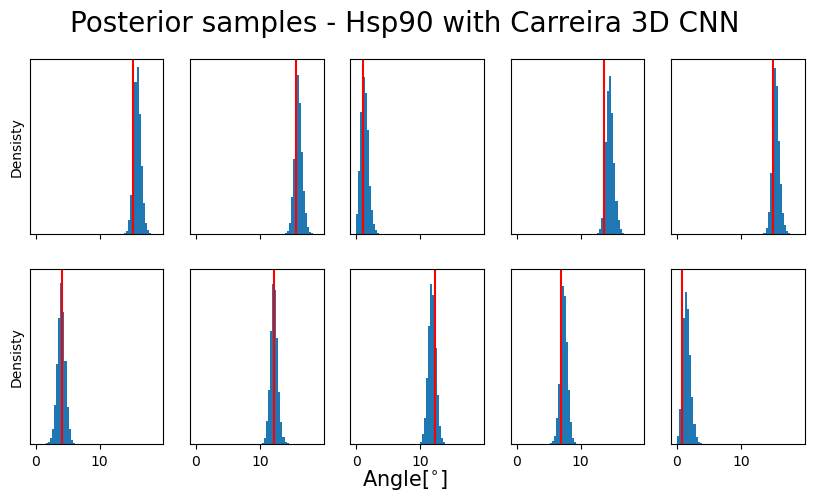

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), sharex=True, sharey=True)

fig.suptitle("Posterior samples - Hsp90 with Carreira 3D CNN", fontsize=20)
for idx, ax in enumerate(axes.flatten()):
    ax.hist(samples[:, idx].flatten(), bins=np.linspace(0, simulator_3d.max_index, 60))
    ax.axvline(parameters[0].cpu()[idx], ymax=1, ymin=0, color="red")
    ax.set_yticks([])
    if idx==0 or idx==5:
        ax.set_ylabel(f"Densisty")
#set common xlable of the plot
fig.text(0.5, 0.04, 'Angle[$^{\circ}$]', ha='center', va='center', fontsize=15)


In [ ]:
single_volume0 = volumes[0]
single_volume1 = volumes[1]
single_volume2 = volumes[2]
single_volume3 = volumes[3]
single_volume4 = volumes[4]
single_volume5 = volumes[5]
single_volume6 = volumes[6]
single_volume7 = volumes[7]
single_volume8 = volumes[8]
single_volume9 = volumes[9]


In [ ]:
mrcfile.new("test_volumes/single_volume0_hsp90_carreiraCNN.mrc", single_volume0.numpy(), overwrite=True)
mrcfile.new("test_volumes/single_volume1_hsp90_carreiraCNN.mrc", single_volume1.numpy(), overwrite=True)
mrcfile.new("test_volumes/single_volume2_hsp90_carreiraCNN.mrc", single_volume2.numpy(), overwrite=True)
mrcfile.new("test_volumes/single_volume3_hsp90_carreiraCNN.mrc", single_volume3.numpy(), overwrite=True)
mrcfile.new("test_volumes/single_volume4_hsp90_carreiraCNN.mrc", single_volume4.numpy(), overwrite=True)
mrcfile.new("test_volumes/single_volume5_hsp90_carreiraCNN.mrc", single_volume5.numpy(), overwrite=True)
mrcfile.new("test_volumes/single_volume6_hsp90_carreiraCNN.mrc", single_volume6.numpy(), overwrite=True)
mrcfile.new("test_volumes/single_volume7_hsp90_carreiraCNN.mrc", single_volume7.numpy(), overwrite=True)
mrcfile.new("test_volumes/single_volume8_hsp90_carreiraCNN.mrc", single_volume8.numpy(), overwrite=True)
mrcfile.new("test_volumes/single_volume9_hsp90_carreiraCNN.mrc", single_volume9.numpy(), overwrite=True)



MrcFile('test_volumes/single_volume9_hsp90_carreiraCNN.mrc', mode='w+')

### Plot latent space

In [ ]:
# latent_representations = est_utils_3d.compute_latent_repr(
#     estimator=posterior,
#     images=volumes,
#     batch_size=1000,
#     device="cuda",
# )

In [ ]:
# reducer = umap.UMAP(metric="euclidean", n_components=2, n_neighbors=50)
# latent_vecs_transformed = reducer.fit_transform(latent_representations.numpy())

In [ ]:
# plt.scatter(
#     latent_vecs_transformed[:, 0],
#     latent_vecs_transformed[:, 1],
#     c=dist,
#     cmap="viridis",
#     s=10,
# )
# plt.colorbar(label="Side length")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")

In [ ]:
# plt.scatter(
#     latent_vecs_transformed[:, 0],
#     latent_vecs_transformed[:, 1],
#     c=snr,
#     cmap="viridis",
#     s=10,
# )
# plt.colorbar(label="SNR")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")